In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np
import pandas as pd
import regex as re
import geopandas as gpd
import folium
from geopy.geocoders import Nominatim
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
import math

In [152]:
df = pd.read_csv("/kaggle/input/updatedflooddata/newIndianFloodInventroy(IFI).csv")
df.head()

UEI  Start Date    End Date  Duration(Days)  \
0  UEI-DFO-FL-1985-0001  23-06-1985  27-06-1985             4.0   
1  UEI-DFO-FL-1985-0002  18-07-1985  30-07-1985            12.0   
2  UEI-DFO-FL-1985-0003  13-09-1985  15-10-1985            32.0   
3  UEI-DFO-FL-1985-0004  18-10-1985  20-10-1985             2.0   
4  UEI-DFO-FL-1986-0001  15-06-1986  20-08-1986            66.0   

         Main Cause Location Districts State  Latitude  Longitude  Severity  \
0        Heavy rain      NaN       NaN   NaN   14.5398    75.0937       1.0   
1        Heavy rain      NaN       NaN   NaN   32.8353    76.9103       1.0   
2        Heavy rain      NaN       NaN   NaN   26.4816    82.8434       2.0   
3  Tropical cyclone      NaN       NaN   NaN   21.1495    86.7154       2.0   
4    Monsoonal rain      NaN       NaN   NaN   25.6339    84.0726       1.0   

   Area Affected Human fatality Human injured Human Displaced Animal Fatality  \
0      254234.60             95           NaN           25000             NaN   
1      117441.17            340           NaN           20000             NaN   
2       89994.67            557           NaN          152000             NaN   
3       46758.64             49           NaN          150000             NaN   
4      507167.44            258           NaN         3040000             NaN   

  Description of Casualties/injured Extent of damage  Event Source  \
0                               NaN               NaN          DFO   
1                               NaN               NaN          DFO   
2                               NaN               NaN          DFO   
3                               NaN               NaN          DFO   
4                               NaN               NaN          DFO   

  Event Souce ID  
0             27  
1             33  
2             53  
3             61  
4             93

In [153]:
shape = df.shape
print("Number of columns: ",shape[1])
print("Number of rows: ",shape[0])

Number of columns:  20
Number of rows:  7420


In [154]:
df.columns

Index(['UEI', 'Start Date', 'End Date', 'Duration(Days)', 'Main Cause',
       'Location', 'Districts', 'State', 'Latitude', 'Longitude', 'Severity',
       'Area Affected', 'Human fatality', 'Human injured', 'Human Displaced',
       'Animal Fatality', 'Description of Casualties/injured',
       'Extent of damage ', 'Event Source', 'Event Souce ID'],
      dtype='object')

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7420 entries, 0 to 7419
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   UEI                                7420 non-null   object 
 1   Start Date                         7420 non-null   object 
 2   End Date                           7420 non-null   object 
 3   Duration(Days)                     7272 non-null   float64
 4   Main Cause                         7267 non-null   object 
 5   Location                           276 non-null    object 
 6   Districts                          6803 non-null   object 
 7   State                              6857 non-null   object 
 8   Latitude                           325 non-null    float64
 9   Longitude                          325 non-null    float64
 10  Severity                           262 non-null    float64
 11  Area Affected                      262 non-null    float

We need to address the NULL enteries as well as the columns having object Dtype before applying any model

Percentage of missing data in each column:

In [156]:
df.isna().sum() / 74.2

UEI                                   0.000000
Start Date                            0.000000
End Date                              0.000000
Duration(Days)                        1.994609
Main Cause                            2.061995
Location                             96.280323
Districts                             8.315364
State                                 7.587601
Latitude                             95.619946
Longitude                            95.619946
Severity                             96.469003
Area Affected                        96.469003
Human fatality                       44.716981
Human injured                        85.552561
Human Displaced                      94.824798
Animal Fatality                      92.452830
Description of Casualties/injured    55.970350
Extent of damage                     49.393531
Event Source                          0.000000
Event Souce ID                       92.412399
dtype: float64

These columns : Location, Latitude , Longitude, Severity,Area affected, Human injured, Human displaced, Animal fatality and event source have most of the data missing (more than 80%)

## Analysing trend in columns

Starting with the UEI column:

In [157]:
df["UEI"]

0       UEI-DFO-FL-1985-0001
1       UEI-DFO-FL-1985-0002
2       UEI-DFO-FL-1985-0003
3       UEI-DFO-FL-1985-0004
4       UEI-DFO-FL-1986-0001
                ...         
7415    UEI-IMD-FL-2023-0649
7416    UEI-IMD-FL-2023-0650
7417    UEI-IMD-FL-2023-0651
7418    UEI-IMD-FL-2023-0652
7419    UEI-IMD-FL-2023-0653
Name: UEI, Length: 7420, dtype: object

In [158]:
df_UEI = df["UEI"].str.extractall(r'(\w+)-([A-Z-]+)-(\w+)-(\d+)-(\d+)')
df_UEI[3] = df_UEI[3].astype('int')
df_UEI

0    1   2     3     4
     match                          
0    0      UEI  DFO  FL  1985  0001
1    0      UEI  DFO  FL  1985  0002
2    0      UEI  DFO  FL  1985  0003
3    0      UEI  DFO  FL  1985  0004
4    0      UEI  DFO  FL  1986  0001
...         ...  ...  ..   ...   ...
7415 0      UEI  IMD  FL  2023  0649
7416 0      UEI  IMD  FL  2023  0650
7417 0      UEI  IMD  FL  2023  0651
7418 0      UEI  IMD  FL  2023  0652
7419 0      UEI  IMD  FL  2023  0653

[7420 rows x 5 columns]

4th columns seems to be the year and 5th is unique id in that year. Enteries of the first 3 columns of df_UEI: 

In [159]:
for i in range(3):
    print(df_UEI[i].unique())

['UEI']
['DFO' 'EM-DAT' 'IMD']
['FL']


In [160]:
df_UEI[1].value_counts()

1
IMD       6857
EM-DAT     301
DFO        262
Name: count, dtype: int64

Now as in df_UEI , 0th column and 2nd column have the same values everywhere it would be better to drop them. Also the 4th column has values equivalent to a unique id and gives no beneficial information so I am dropping that too. We will include the year and the 1st column and drop the rest

In [161]:
df['UEI_cat'] = np.array(df_UEI[1])
df['UEI_year'] = np.array(df_UEI[3])
df = df.drop(['UEI'],axis = 1)
df.head()

Start Date    End Date  Duration(Days)        Main Cause Location  \
0  23-06-1985  27-06-1985             4.0        Heavy rain      NaN   
1  18-07-1985  30-07-1985            12.0        Heavy rain      NaN   
2  13-09-1985  15-10-1985            32.0        Heavy rain      NaN   
3  18-10-1985  20-10-1985             2.0  Tropical cyclone      NaN   
4  15-06-1986  20-08-1986            66.0    Monsoonal rain      NaN   

  Districts State  Latitude  Longitude  Severity  Area Affected  \
0       NaN   NaN   14.5398    75.0937       1.0      254234.60   
1       NaN   NaN   32.8353    76.9103       1.0      117441.17   
2       NaN   NaN   26.4816    82.8434       2.0       89994.67   
3       NaN   NaN   21.1495    86.7154       2.0       46758.64   
4       NaN   NaN   25.6339    84.0726       1.0      507167.44   

  Human fatality Human injured Human Displaced Animal Fatality  \
0             95           NaN           25000             NaN   
1            340           NaN           20000             NaN   
2            557           NaN          152000             NaN   
3             49           NaN          150000             NaN   
4            258           NaN         3040000             NaN   

  Description of Casualties/injured Extent of damage  Event Source  \
0                               NaN               NaN          DFO   
1                               NaN               NaN          DFO   
2                               NaN               NaN          DFO   
3                               NaN               NaN          DFO   
4                               NaN               NaN          DFO   

  Event Souce ID UEI_cat  UEI_year  
0             27     DFO      1985  
1             33     DFO      1985  
2             53     DFO      1985  
3             61     DFO      1985  
4             93     DFO      1986

In [163]:
df.index

RangeIndex(start=0, stop=7420, step=1)

In [164]:
df.loc[0]

Start Date                           23-06-1985
End Date                             27-06-1985
Duration(Days)                              4.0
Main Cause                           Heavy rain
Location                                    NaN
Districts                                   NaN
State                                       NaN
Latitude                                14.5398
Longitude                               75.0937
Severity                                    1.0
Area Affected                          254234.6
Human fatality                               95
Human injured                               NaN
Human Displaced                           25000
Animal Fatality                             NaN
Description of Casualties/injured           NaN
Extent of damage                            NaN
Event Source                                DFO
Event Souce ID                               27
UEI_cat                                     DFO
UEI_year                                

In [165]:
df.tail(20)

Start Date    End Date  Duration(Days)            Main Cause Location  \
7400  12-09-2023  12-09-2023             1.0             Landslide      NaN   
7401  25-08-2023  25-08-2023             1.0             Landslide      NaN   
7402  25-08-2023  25-08-2023             1.0             Landslide      NaN   
7403  10-09-2023  11-09-2023             2.0  Heavy Rains & Floods      NaN   
7404  10-09-2023  11-09-2023             2.0  Heavy Rains & Floods      NaN   
7405  10-09-2023  11-09-2023             2.0  Heavy Rains & Floods      NaN   
7406  10-09-2023  11-09-2023             2.0  Heavy Rains & Floods      NaN   
7407  10-09-2023  11-09-2023             2.0  Heavy Rains & Floods      NaN   
7408  10-09-2023  11-09-2023             2.0  Heavy Rains & Floods      NaN   
7409  10-09-2023  11-09-2023             2.0  Heavy Rains & Floods      NaN   
7410  10-09-2023  11-09-2023             2.0  Heavy Rains & Floods      NaN   
7411  10-09-2023  11-09-2023             2.0  Heavy Rains & Floods      NaN   
7412  10-09-2023  11-09-2023             2.0  Heavy Rains & Floods      NaN   
7413  10-09-2023  11-09-2023             2.0  Heavy Rains & Floods      NaN   
7414  10-09-2023  11-09-2023             2.0  Heavy Rains & Floods      NaN   
7415  10-09-2023  11-09-2023             2.0  Heavy Rains & Floods      NaN   
7416  10-09-2023  11-09-2023             2.0  Heavy Rains & Floods      NaN   
7417  10-09-2023  11-09-2023             2.0  Heavy Rains & Floods      NaN   
7418  10-09-2023  11-09-2023             2.0  Heavy Rains & Floods      NaN   
7419  10-09-2023  11-09-2023             2.0  Heavy Rains & Floods      NaN   

             Districts            State  Latitude  Longitude  Severity  \
7400            Ramban  Jammu & Kashmir       NaN        NaN       NaN   
7401         Gyalshing           Sikkim       NaN        NaN       NaN   
7402        Darjeeling      West Bengal       NaN        NaN       NaN   
7403          Amethi,     Uttar Pradesh       NaN        NaN       NaN   
7404       Barabanki,     Uttar Pradesh       NaN        NaN       NaN   
7405          Budaun,     Uttar Pradesh       NaN        NaN       NaN   
7406          Deoria,     Uttar Pradesh       NaN        NaN       NaN   
7407           Hardoi,    Uttar Pradesh       NaN        NaN       NaN   
7408          Jalaun,     Uttar Pradesh       NaN        NaN       NaN   
7409          Kanpur,     Uttar Pradesh       NaN        NaN       NaN   
7410         Kannauj,     Uttar Pradesh       NaN        NaN       NaN   
7411        Mirzapur,     Uttar Pradesh       NaN        NaN       NaN   
7412  Muzaffarnagar,      Uttar Pradesh       NaN        NaN       NaN   
7413       Prayagraj,     Uttar Pradesh       NaN        NaN       NaN   
7414      Pratapgarh,     Uttar Pradesh       NaN        NaN       NaN   
7415          Rampur,     Uttar Pradesh       NaN        NaN       NaN   
7416         Sambhal,     Uttar Pradesh       NaN        NaN       NaN   
7417         Sitapur,     Uttar Pradesh       NaN        NaN       NaN   
7418       Sultanpur,     Uttar Pradesh       NaN        NaN       NaN   
7419             Unnao    Uttar Pradesh       NaN        NaN       NaN   

      Area Affected Human fatality Human injured Human Displaced  \
7400            NaN              4           NaN             NaN   
7401            NaN              1           NaN             NaN   
7402            NaN              1           NaN             NaN   
7403            NaN            NaN           NaN             NaN   
7404            NaN            NaN           NaN             NaN   
7405            NaN            NaN           NaN             NaN   
7406            NaN              1           NaN             NaN   
7407            NaN              1           NaN             NaN   
7408            NaN            NaN           NaN             NaN   
7409            NaN            NaN           NaN             NaN   
7410            NaN              2         

Now pre-processing the Start date and End date columns

In [166]:
type(df['Start Date'][0])

str

The dates are present in str and not tin date-time data type

In [167]:
list(df['Start Date'])[275:325]

['/07/1959',
 '/09/1959',
 '10-11-1960',
 '/07/1960',
 '/08/1960',
 '/09/1960',
 '/07/1961',
 '06-09-1961',
 '09-10-1961',
 '/10/1961',
 '/08/1962',
 '/09/1962',
 '/07/1963',
 '/07/1964',
 '/10/1964',
 '/09/1964',
 '/09/1964',
 '/06/1966',
 '05-09-1967',
 '12-06-1968',
 '/07/1968',
 '/08/1968',
 '/10/1968',
 '/07/1970',
 '02-09-1970',
 '/06/1971',
 '09-09-1971',
 '/06/1971',
 '/06/1974',
 '02-07-1974',
 '/07/1975',
 '/08/1977',
 '/10/1977',
 '/07/1978',
 '/09/1978',
 '/07/1979',
 '/10/1979',
 '/11/1979',
 '25-08-1979',
 '/07/1980',
 '/07/1980',
 '/08/1980',
 '/09/1980',
 '/07/1980',
 '04-07-1981',
 '/08/1982',
 '/06/1982',
 '/07/1983',
 '/08/1983',
 '/12/1983']

This was a glimpse of Start date data. We will extract the month and year from here. After extraction , we willcross check the start year with the UEI year

After checking the start dates, they appear to be either in year-month-day format or /month/year format. So I will try to use this pattern for getting the data

In [168]:
# df['start_year'] = [(x.split('-')[-1]) if ('-' in x) else (x.split('/')[-1]) for x in df['Start Date']]
# df['start_month'] = [(x.split('-')[1]) if ('-' in x) else (x.split('/')[1]) for x in df['Start Date']]

After using list comprehension to extract data, I was getting this error: 
IndexError: list index out of range
So that means there is some issue in our understanding of pattern. I have commented this code and now I will try to debug this problem

First I am checking the count of enteries which have year-month-day fromat and storing it in count 1 variable. Then I am checking out of all the values , how many enteries are there where year-month-day fromat is not been followed. This is stored in count 2. Now ideally if I store the number of enteries which have /month/year pattern in count 3, then count 2 must be equal to count 3. 

In [169]:
# df['Start Date']
count = 0
for item in df['Start Date']:
    if '-' in item:
        count = count + 1
#         print(item)
count

7341

In [170]:
count2 = 0
for item in df['Start Date']:
    if '-' not in item:
        count2 = count2+1
count2

79

In [171]:
count3 = 0
for item in df['Start Date']:
    if '/' in item:
        count3 = count3+1
count3

78

So that means there is one data which is neither in the form of year-month-day nor in /month/day. I will try to find the index of that entry and what is that entry

In [172]:
for item in df['Start Date']:
    if '-' not in item and '/' not in item:
        print(item)

#VALUE!


So there is an entry of '#VALUE!' in our dataframe. Let's look at that value and decide what to do with it

In [173]:
df[df['Start Date']=='#VALUE!']

Start Date End Date  Duration(Days)   Main Cause Location  \
2972    #VALUE!  #VALUE!             1.0  heavy rains      NaN   

                       Districts      State  Latitude  Longitude  Severity  \
2972  Bengalore, Bengaluru Rural  Karnataka       NaN        NaN       NaN   

      Area Affected Human fatality Human injured Human Displaced  \
2972            NaN            NaN             2             NaN   

     Animal Fatality      Description of Casualties/injured  \
2972             NaN  A couple injured due to wall collapse   

                         Extent of damage  Event Source Event Souce ID  \
2972  Standing crop in 450 acres submerged          IMD            NaN   

     UEI_cat  UEI_year  
2972     IMD      2001

Index 2972 has a garbage value in Start and End date so it would be sensible to drop this row

In [174]:
df=df.drop(2972)

Our new dataframe has now 7419 rows which could be seen below:

In [175]:
df.shape

(7419, 21)

Now as we have solved the issue, we can re-apply our list comprehension code which should not give an error now.

In [176]:
df['start_year'] = [(x.split('-')[-1]) if ('-' in x) else (x.split('/')[-1]) for x in df['Start Date']]
df['start_month'] = [(x.split('-')[1]) if ('-' in x) else (x.split('/')[1]) for x in df['Start Date']]

Now converting our year and months from object data type to int:

In [177]:
# df['start_year'] = df['start_year'].astype('int')
# df['start_month'] = df['start_month'].astype('int')

After running the code I received the error stating :
ValueError: invalid literal for int() with base 10: ''
This means that we have an empty string in our start month / start year column

In [178]:
df['start_year'].unique()

array(['1985', '1986', '1988', '1989', '1990', '1991', '1992', '1993',
       '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001',
       '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
       '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', '2019', '1926', '1928', '1950', '1953', '1956', '1957',
       '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1966',
       '1967', '1968', '1970', '1971', '1974', '1975', '1977', '1978',
       '1979', '1980', '1981', '1982', '1983', '1984', '1987', '1969',
       '1972', '1973', '1976', '2020', '2021', '2022', '2023'],
      dtype=object)

In [179]:
df['start_month'].unique()

array(['06', '07', '09', '10', '08', '05', '04', '03', '01', '11', '12',
       '02', ''], dtype=object)

Now it is clearly visible we have an empty string in start_month column. Checking how many such strings are there and what we could do about them

In [180]:
df['start_month'].value_counts()

start_month
07    1812
08    1483
06    1153
09    1025
10     558
05     514
11     215
03     188
04     187
01     127
12      81
02      75
         1
Name: count, dtype: int64

In [181]:
df[df['start_month']=='']

Start Date End Date  Duration(Days) Main Cause Location Districts State  \
338     //1986   //1986             NaN        NaN      NaN       NaN   NaN   

     Latitude  Longitude  Severity  Area Affected Human fatality  \
338       NaN        NaN       NaN            NaN            NaN   

    Human injured Human Displaced Animal Fatality  \
338           NaN             NaN             NaN   

    Description of Casualties/injured Extent of damage  Event Source  \
338                               NaN               NaN       EM-DAT   

    Event Souce ID UEI_cat  UEI_year start_year start_month  
338      1986-0385  EM-DAT      1986       1986

There is just a single row which has start month as empty string and this is because the start date and end date seems to just contain the year. I am deciding to drop this row as this wont cause any loosing of data.

In [182]:
df = df.drop(338)
df.shape

(7418, 23)

In [183]:
df['start_year'] = df['start_year'].astype('int')
df['start_month'] = df['start_month'].astype('int')

Succesfully changed the data type to int .Now just to check the authenticity of data, we will compare the UEI_start and start_year column as both give the same information.

In [184]:
df[df['UEI_year'] !=  df['start_year']]

Start Date    End Date  Duration(Days)               Main Cause  \
682   01-08-1975  31-08-1975             1.0              heavy rains   
4766  08-06-2018  08-07-2017             2.0  Heavy rains & landslide   

     Location                                          Districts  \
682       NaN  Mount Abu, Jodhpur, Nagaurm Sawai Modhopur, Ja...   
4766      NaN            Chamba, Hamirpur, Kangra, Kullu, Shimla   

                 State  Latitude  Longitude  Severity  Area Affected  \
682          Rajasthan       NaN        NaN       NaN            NaN   
4766  Himachal Pradesh       NaN        NaN       NaN            NaN   

     Human fatality Human injured Human Displaced Animal Fatality  \
682             NaN           NaN             NaN             NaN   
4766              3           NaN             NaN             NaN   

                 Description of Casualties/injured  \
682                                            NaN   
4766  Total 3 persons died. Kangra - 1, Kullu – 2.   

                                      Extent of damage  Event Source  \
682                                                 NaN          IMD   
4766  i) Damage to more than 6 houses reported. ii) ...          IMD   

     Event Souce ID UEI_cat  UEI_year  start_year  start_month  
682             NaN     IMD      1976        1975            8  
4766            NaN     IMD      2017        2018            6

We see there are two rows where the values of the two columns dont match. We will drop this row as well as the UEI_start column as its role will be played in exactly same way by the start_year column. We will also drop the Start Date column as we have produced the start_year and start_month column which depicts the same behaviour.

In [185]:
df = df.drop([682,4766])
df = df.drop('Start Date',axis = 1)
df = df.drop('UEI_year',axis =1)
df.head()

End Date  Duration(Days)        Main Cause Location Districts State  \
0  27-06-1985             4.0        Heavy rain      NaN       NaN   NaN   
1  30-07-1985            12.0        Heavy rain      NaN       NaN   NaN   
2  15-10-1985            32.0        Heavy rain      NaN       NaN   NaN   
3  20-10-1985             2.0  Tropical cyclone      NaN       NaN   NaN   
4  20-08-1986            66.0    Monsoonal rain      NaN       NaN   NaN   

   Latitude  Longitude  Severity  Area Affected Human fatality Human injured  \
0   14.5398    75.0937       1.0      254234.60             95           NaN   
1   32.8353    76.9103       1.0      117441.17            340           NaN   
2   26.4816    82.8434       2.0       89994.67            557           NaN   
3   21.1495    86.7154       2.0       46758.64             49           NaN   
4   25.6339    84.0726       1.0      507167.44            258           NaN   

  Human Displaced Animal Fatality Description of Casualties/injured  \
0           25000             NaN                               NaN   
1           20000             NaN                               NaN   
2          152000             NaN                               NaN   
3          150000             NaN                               NaN   
4         3040000             NaN                               NaN   

  Extent of damage  Event Source Event Souce ID UEI_cat  start_year  \
0               NaN          DFO             27     DFO        1985   
1               NaN          DFO             33     DFO        1985   
2               NaN          DFO             53     DFO        1985   
3               NaN          DFO             61     DFO        1985   
4               NaN          DFO             93     DFO        1986   

   start_month  
0            6  
1            7  
2            9  
3           10  
4            6

In [186]:
df['end_year'] = [(x.split('-')[-1]) if ('-' in x) else (x.split('/')[-1]) for x in df['End Date']]
df['end_month'] = [(x.split('-')[1]) if ('-' in x) else (x.split('/')[1]) for x in df['End Date']]

In [187]:
df['end_year'] = df['end_year'].astype('int')
df['end_month'] = df['end_month'].astype('int')

In [188]:
df = df.drop('End Date',axis = 1)

In [191]:
df.to_csv("original_df.csv")

We treated the End Date in the same way as we treated the Start Date. Till now we have completed the preprocessing of three columns. We will now preprocess Duration(days) column. Missing values will be filled with the help of start and end year and months.

In [192]:
df['Duration(Days)'].info()

<class 'pandas.core.series.Series'>
Index: 7416 entries, 0 to 7419
Series name: Duration(Days)
Non-Null Count  Dtype  
--------------  -----  
7269 non-null   float64
dtypes: float64(1)
memory usage: 373.9 KB


Note that I will be only using this duration column which I am creating to fill in the missing values only, because while calculating , I am only taking into account the year and month values and not the date values. As there is only around 3% of this data missing this should not produce any misleading data.

In [193]:
df['duration'] = (df['end_year'] - df['start_year'])*365 + (df['end_month']-df['start_month'])*30

In [194]:
df['duration']

0        0
1        0
2       30
3        0
4       60
        ..
7415     0
7416     0
7417     0
7418     0
7419     0
Name: duration, Length: 7416, dtype: int64

In [195]:
null_ind = df[df['Duration(Days)'].isnull()].index

In [196]:
for ind in null_ind:
    df.loc[ind,'Duration(Days)']=df.loc[ind,'duration']

In [197]:
df['Duration(Days)'].info()

<class 'pandas.core.series.Series'>
Index: 7416 entries, 0 to 7419
Series name: Duration(Days)
Non-Null Count  Dtype  
--------------  -----  
7416 non-null   float64
dtypes: float64(1)
memory usage: 373.9 KB


In [198]:
df[['Duration(Days)','duration']].describe()

Duration(Days)     duration
count     7416.000000  7416.000000
mean         4.480313     2.803398
std         22.011856    26.331097
min       -270.000000  -270.000000
25%          1.000000     0.000000
50%          1.000000     0.000000
75%          3.000000     0.000000
max        365.000000   330.000000

Why is duration negative? Lets check our initial data.

In [199]:
df[df['Duration(Days)']<0]

Duration(Days)        Main Cause Location Districts State  Latitude  \
11           -150.0        Heavy rain      NaN       NaN   NaN   18.4311   
13            -30.0        Heavy rain      NaN       NaN   NaN   30.9339   
19           -150.0  Tropical cyclone      NaN       NaN   NaN   16.2843   
36            -90.0        Heavy rain      NaN       NaN   NaN   26.9122   
39            -30.0  Tropical cyclone      NaN       NaN   NaN   13.0242   
..              ...               ...      ...       ...   ...       ...   
245           -60.0    Monsoonal rain      NaN       NaN   NaN   12.5238   
249           -30.0    Monsoonal rain      NaN       NaN   NaN   26.0513   
250          -210.0   Torrential rain      NaN       NaN   NaN   31.3414   
260          -120.0        Heavy Rain      NaN       NaN   NaN   27.0678   
261          -150.0        Heavy Rain      NaN       NaN   NaN   10.8488   

     Longitude  Severity  Area Affected Human fatality Human injured  \
11     80.7130       1.0       94871.79             50           NaN   
13     75.0459       2.0      268528.55            731           NaN   
19     80.6926       1.0      267344.40            430           NaN   
36     94.4600       1.0       28221.72              0           NaN   
39     78.8487       2.0      552562.43            263           NaN   
..         ...       ...            ...            ...           ...   
245    75.6883       1.5      153840.07             12           NaN   
249    94.7655       1.5       28864.54             11           NaN   
250    76.6285       1.0      114348.33             28           NaN   
260    94.2459       1.0      106818.77              2           NaN   
261    78.8554       1.5      104755.46             30           NaN   

    Human Displaced Animal Fatality Description of Casualties/injured  \
11                0             NaN                               NaN   
13          1250000             NaN                               NaN   
19           470000             NaN                               NaN   
36                0             NaN                               NaN   
39            20000             NaN                               NaN   
..              ...             ...                               ...   
245           34000             NaN                               NaN   
249            2000             NaN                               NaN   
250             935             NaN                               NaN   
260            1000             NaN                               NaN   
261            1000             NaN                               NaN   

    Extent of damage  Event Source Event Souce ID UEI_cat  start_year  \
11                NaN          DFO            214     DFO        1988   
13                NaN          DFO            253     DFO        1988   
19                NaN          DFO            411     DFO        1990   
36                NaN          DFO            667     DFO        1992   
39                NaN          DFO            694     DFO        1992   
..                ...          ...            ...     ...         ...   
245               NaN          DFO           4656     DFO        2018   
249               NaN          DFO           4675     DFO        2018   
250               NaN          DFO           4684     DFO        2018   
260               NaN          DFO           4822     DFO        2019   
261               NaN          DFO           4832     DFO        2019   

     start_month  end_year  end_month  duration  
11             7      1988          2      -150  
13             9      1988          8       -30  
19            10      1990          5      -150  
36            10      1992          7       -90  
39            12      1992         11       -30  
..           ...       ...        ...       ...  
245            9      2018          7       -60  
249            8      2018          7       -30  
250            9      2

On checking our initial data, i found that some rows had their End date before their start date. Most of these rows have their duration as NA. So our plan wont work as we extracted the year and months from the start and end dates and if we use them for filling in values of enteries, we would obviously get a non-positive result

One way can be replacing these NA values with the mean values of disaster duration based on their main cause. Or we can simply drop these rows as they comprise of just 3% data.

In [200]:
df = df.drop(null_ind)
df.head(15)

Duration(Days)        Main Cause Location Districts State  Latitude  \
0              4.0        Heavy rain      NaN       NaN   NaN   14.5398   
1             12.0        Heavy rain      NaN       NaN   NaN   32.8353   
2             32.0        Heavy rain      NaN       NaN   NaN   26.4816   
3              2.0  Tropical cyclone      NaN       NaN   NaN   21.1495   
4             66.0    Monsoonal rain      NaN       NaN   NaN   25.6339   
5              7.0    Monsoonal rain      NaN       NaN   NaN   17.4331   
6             18.0        Heavy rain      NaN       NaN   NaN   23.6547   
7            167.0    Monsoonal rain      NaN       NaN   NaN   26.4813   
8             23.0        Heavy rain      NaN       NaN   NaN   26.9880   
9            123.0    Monsoonal rain      NaN       NaN   NaN   28.8860   
10            13.0        Heavy rain      NaN       NaN   NaN   22.0189   
12            23.0    Monsoonal rain      NaN       NaN   NaN   26.5037   
14            31.0        Heavy rain      NaN       NaN   NaN   19.1131   
15             9.0    Monsoonal rain      NaN       NaN   NaN   15.1816   
16           154.0    Monsoonal rain      NaN       NaN   NaN   24.8678   

    Longitude  Severity  Area Affected Human fatality Human injured  \
0     75.0937       1.0     254234.600             95           NaN   
1     76.9103       1.0     117441.170            340           NaN   
2     82.8434       2.0      89994.670            557           NaN   
3     86.7154       2.0      46758.640             49           NaN   
4     84.0726       1.0     507167.440            258           NaN   
5     80.1870       1.0     107355.330            150           NaN   
6     89.4296       1.0     231516.280             49           NaN   
7     92.0622       1.0      42285.990             76           NaN   
8     92.9260       1.0      70501.830             34           NaN   
9     80.7246       2.0     847737.260            233           NaN   
10    71.1117       1.0      76352.550             97           NaN   
12    86.5429       1.0     626872.460            876           NaN   
14    72.8962       1.0        605.213             23           NaN   
15    76.4736       1.0     905209.240            780           NaN   
16    92.8291       2.0     112816.350             31           NaN   

   Human Displaced Animal Fatality Description of Casualties/injured  \
0            25000             NaN                               NaN   
1            20000             NaN                               NaN   
2           152000             NaN                               NaN   
3           150000             NaN                               NaN   
4          3040000             NaN                               NaN   
5          3000000             NaN                               NaN   
6           700000             NaN                               NaN   
7            43000             NaN                               NaN   
8          2000000             NaN                               NaN   
9           500000             NaN                               NaN   
10           25000             NaN                               NaN   
12            2000             NaN                               NaN   
14               0             NaN                               NaN   
15               0             NaN                               NaN   
16           32000             NaN                               NaN   

   Extent of damage  Event Source Event Souce ID UEI_cat  start_year  \
0                NaN          DFO             27     DFO        1985   
1                NaN          DFO             33     DFO        1985   
2                NaN          DFO             53     DFO        1985   
3                NaN          DFO             61     DFO        1985   
4                NaN          DFO             93     DFO        1986   
5                NaN          DFO             98     DFO        1986   
6        

In [201]:
df = df.drop('duration',axis =1)
df.head()

Duration(Days)        Main Cause Location Districts State  Latitude  \
0             4.0        Heavy rain      NaN       NaN   NaN   14.5398   
1            12.0        Heavy rain      NaN       NaN   NaN   32.8353   
2            32.0        Heavy rain      NaN       NaN   NaN   26.4816   
3             2.0  Tropical cyclone      NaN       NaN   NaN   21.1495   
4            66.0    Monsoonal rain      NaN       NaN   NaN   25.6339   

   Longitude  Severity  Area Affected Human fatality Human injured  \
0    75.0937       1.0      254234.60             95           NaN   
1    76.9103       1.0      117441.17            340           NaN   
2    82.8434       2.0       89994.67            557           NaN   
3    86.7154       2.0       46758.64             49           NaN   
4    84.0726       1.0      507167.44            258           NaN   

  Human Displaced Animal Fatality Description of Casualties/injured  \
0           25000             NaN                               NaN   
1           20000             NaN                               NaN   
2          152000             NaN                               NaN   
3          150000             NaN                               NaN   
4         3040000             NaN                               NaN   

  Extent of damage  Event Source Event Souce ID UEI_cat  start_year  \
0               NaN          DFO             27     DFO        1985   
1               NaN          DFO             33     DFO        1985   
2               NaN          DFO             53     DFO        1985   
3               NaN          DFO             61     DFO        1985   
4               NaN          DFO             93     DFO        1986   

   start_month  end_year  end_month  
0            6      1985          6  
1            7      1985          7  
2            9      1985         10  
3           10      1985         10  
4            6      1986          8

We will now pre process the Main Cause column

In [207]:
df['Main Cause'].info()

<class 'pandas.core.series.Series'>
Index: 7269 entries, 0 to 7419
Series name: Main Cause
Non-Null Count  Dtype 
--------------  ----- 
7179 non-null   object
dtypes: object(1)
memory usage: 371.6+ KB


In [208]:
df['Main Cause'].value_counts()

Main Cause
heavy rains                                                                          2626
Heavy Rains & Floods                                                                  696
Heavy Rains                                                                           515
severe                                                                                210
Heavy rains                                                                           205
                                                                                     ... 
flash flood(belgir)                                                                     1
severe flood(saktola and pahumora)                                                      1
flood(brahmaputra and its tributaries, jiadhol, kaldia, plagadia, kalo and drani)       1
flash flood(cloud burst)                                                                1
Heavy Rains, Flash Floods Landslide                                                     1

Seeing the raw data, it is necssary to convert all the strings to lower case and strip of all the leading and trailing whitespaces

In [209]:
df['Main Cause']=df["Main Cause"].str.strip()
df['Main Cause'] = df['Main Cause'].str.lower()

In [210]:
df['Main Cause'].value_counts()

Main Cause
heavy rains                                          3576
heavy rains & floods                                  806
severe                                                210
flash flood                                           193
heavy rains & flood (brahmaputra and tributaries)     158
                                                     ... 
flash flood(gavoru)                                     1
flash flood(jiabharali)                                 1
flash flood(salengi)                                    1
moderate flood(dhansiri, etc)                           1
heavy rains, flash floods landslide                     1
Name: count, Length: 507, dtype: int64

In [211]:
len(df['Main Cause'].unique())

508

There are 508 unique enteries in the main cause column, most of which comprise of heavy rains, severe floods, flash flood and riverine flood. We can once take a look at all the data and then decide how to process this data

In [212]:
list(df['Main Cause'].unique())

['heavy rain',
 'tropical cyclone',
 'monsoonal rain',
 'torrential rain',
 'extra-tropical cyclone',
 'dam/levy, break or release',
 'riverine flood',
 nan,
 'flash flood',
 'coastal flood',
 'flood',
 'heavy rains, floods',
 'floods',
 'cloud burst',
 'severe floods',
 'heavy rains',
 'heavy rains and floods',
 'flooded',
 'moderate floods',
 'severe flood',
 'inceasant rains',
 'floods, heavy landslides',
 'incessant rains',
 'torential rain and heavy floods',
 'flash floods',
 'moderate to severe',
 'moderate',
 'severe',
 'severe, moderate',
 'very severe',
 'floods and cloud burst',
 'moderate to severe, moderate',
 'severe, moderate to severe',
 'moderate, severe',
 'flash floods in lohit river',
 'moderate to severe floods',
 'erratic rains',
 'incessant heavy rains',
 'heavy rains and moderate floods',
 'heavy rains, moderate floods',
 'severe floods, heavy rains',
 'modern floods, flash floods, heavy rains',
 'flash floods due to sudden cloud burst',
 'flash floods in vamsadh

On seeing the eneteries there are a couple of problems that need to be addressed in this column,

a) Enteries such as 'flood' and 'floods', 'heavy rain' and 'heavy rains' are nothing but the same thing.There are a lot of entries with this problem.

b) Apart from the the most occuring data like heavy rain and flood, there are many other enteries which occur only once and are in the form of a long string.


In [213]:
### utlity function for pre-processing the text
import spacy

# load english language model and create nlp object from it
nlp = spacy.load("en_core_web_sm") 

def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    
    return " ".join(filtered_tokens)

Main aim of this preprocess function is to remove the stop words (such as: the, as , in, is, it ), remove punctuations and lemmatize the words (running -> run, largest -> large, meeting -> meet, gone -> go).

In [214]:
df['Main Cause'].info()

<class 'pandas.core.series.Series'>
Index: 7269 entries, 0 to 7419
Series name: Main Cause
Non-Null Count  Dtype 
--------------  ----- 
7179 non-null   object
dtypes: object(1)
memory usage: 371.6+ KB


In [215]:
# df['processed cause'] = df['Main Cause'].apply(preprocess) 

On running the previous cell, I recieved this error:

ValueError: [E1041] Expected a string, Doc, or bytes as input, but got: <class 'float'>

This means that we have to drop the missing values so as to apply preprocess function. This wouldnt lead to loss of any information because only around 3-4% of data was missing

In [216]:
null_ind = df[df['Main Cause'].isnull()].index
df=df.drop(null_ind)

In [217]:
df['processed cause'] = df['Main Cause'].apply(preprocess) 

In [218]:
len(df['processed cause'].unique())

449

In [219]:
df.loc[361]

Duration(Days)                                                                     0.0
Main Cause                                                              riverine flood
Location                             Vamanapuram, Amravilla (Trivadrum , Kerala state)
Districts                                                                          NaN
State                                                                              NaN
Latitude                                                                           NaN
Longitude                                                                          NaN
Severity                                                                           NaN
Area Affected                                                                      NaN
Human fatality                                                                     NaN
Human injured                                                                      NaN
Human Displaced                            

We have reduced the unique enteries from 508 to 449

In [220]:
df['Main Cause'].value_counts()[:10]

Main Cause
heavy rains                                           3576
heavy rains & floods                                   806
severe                                                 210
flash flood                                            193
heavy rains & flood (brahmaputra and tributaries)      158
landslide                                              136
riverine flood                                         130
severe flood                                           127
heavy rains & floods (brahmaputra and tributaries)     119
monsoonal rain                                         118
Name: count, dtype: int64

In [221]:
df['processed cause'].value_counts()[:25]

processed cause
heavy rain                                  3673
heavy rain flood                             913
heavy rain flood brahmaputra tributary       278
flash flood                                  247
severe                                       211
severe flood                                 195
landslide                                    153
riverine flood                               130
monsoonal rain                               118
flood                                        107
moderate flood                                71
heavy rain landslide                          58
heavy rain flood landslide                    49
unseasonal heavy rain                         44
cloud burst                                   33
moderate                                      31
flood brahmaputra tributary                   28
heavy rain flood landslides                   25
flood heavy rain                              25
heavy rain   flood brahmaputra tributary      23
heav

In [222]:
df['processed cause'].unique()

array(['heavy rain', 'tropical cyclone', 'monsoonal rain',
       'torrential rain', 'extra tropical cyclone',
       'dam levy break release', 'riverine flood', 'flash flood',
       'coastal flood', 'flood', 'heavy rain flood', 'cloud burst',
       'severe flood', 'moderate flood', 'inceasant rain',
       'flood heavy landslide', 'incessant rain',
       'torential rain heavy flood', 'moderate severe', 'moderate',
       'severe', 'severe moderate', 'flood cloud burst',
       'moderate severe moderate', 'severe moderate severe',
       'flash flood lohit river', 'moderate severe flood', 'erratic rain',
       'incessant heavy rain', 'heavy rain moderate flood',
       'severe flood heavy rain', 'modern flood flash flood heavy rain',
       'flash flood sudden cloud burst', 'flash flood vamsadhara river',
       'flood pennar river', 'brahmaputra tributary moderate flood',
       'brahmaputra tributary flood',
       'kosi kamala ganga mahananda river flood',
       'flash flood gh

We have got rid off the first problem. After looking at the data if we take the first word into consideration of the string then we would be able to capture the information of the cause.

In [223]:
def split(row):
    row['cause'] = row['processed cause'].split(" ")[0]
    row['cause'] = row['cause'].split("(")[0]
    return row

In [224]:
df = df.apply(split,axis = 'columns')
df.head()

Duration(Days)        Main Cause Location Districts State  Latitude  \
0             4.0        heavy rain      NaN       NaN   NaN   14.5398   
1            12.0        heavy rain      NaN       NaN   NaN   32.8353   
2            32.0        heavy rain      NaN       NaN   NaN   26.4816   
3             2.0  tropical cyclone      NaN       NaN   NaN   21.1495   
4            66.0    monsoonal rain      NaN       NaN   NaN   25.6339   

   Longitude  Severity  Area Affected Human fatality Human injured  \
0    75.0937       1.0      254234.60             95           NaN   
1    76.9103       1.0      117441.17            340           NaN   
2    82.8434       2.0       89994.67            557           NaN   
3    86.7154       2.0       46758.64             49           NaN   
4    84.0726       1.0      507167.44            258           NaN   

  Human Displaced Animal Fatality Description of Casualties/injured  \
0           25000             NaN                               NaN   
1           20000             NaN                               NaN   
2          152000             NaN                               NaN   
3          150000             NaN                               NaN   
4         3040000             NaN                               NaN   

  Extent of damage  Event Source Event Souce ID UEI_cat  start_year  \
0               NaN          DFO             27     DFO        1985   
1               NaN          DFO             33     DFO        1985   
2               NaN          DFO             53     DFO        1985   
3               NaN          DFO             61     DFO        1985   
4               NaN          DFO             93     DFO        1986   

   start_month  end_year  end_month   processed cause      cause  
0            6      1985          6        heavy rain      heavy  
1            7      1985          7        heavy rain      heavy  
2            9      1985         10        heavy rain      heavy  
3           10      1985         10  tropical cyclone   tropical  
4            6      1986          8    monsoonal rain  monsoonal

In [225]:
df['cause'].info()

<class 'pandas.core.series.Series'>
Index: 7179 entries, 0 to 7419
Series name: cause
Non-Null Count  Dtype 
--------------  ----- 
7179 non-null   object
dtypes: object(1)
memory usage: 370.2+ KB


In [226]:
df['cause'].unique()

array(['heavy', 'tropical', 'monsoonal', 'torrential', 'extra', 'dam',
       'riverine', 'flash', 'coastal', 'flood', 'cloud', 'severe',
       'moderate', 'inceasant', 'incessant', 'torential', 'erratic',
       'modern', 'brahmaputra', 'kosi', 'cauvery', 'continuous',
       'narmada', 'unseasonal', 'wardha', 'budki', 'palar', 'manu',
       'river', 'rohini', 'flodd', 'mechi', 'haldi', 'heavyh', 'heay',
       'heav', 'floash', 'belgaum', 'massive', 'landslide', 'landslip',
       'cloudburst', 'rain', 'nandadevi', 'land', 'mud', 'mudslide',
       'unprecedented'], dtype=object)

In [227]:
df['cause'].value_counts()

cause
heavy            5275
severe            522
flash             339
flood             261
moderate          160
landslide         155
riverine          130
monsoonal         118
unseasonal         49
cloud              44
torrential         22
cloudburst         15
massive            15
tropical           11
unprecedented       9
dam                 7
incessant           5
coastal             4
landslip            3
brahmaputra         3
land                3
inceasant           2
heav                2
floash              1
belgaum             1
torential           1
extra               1
heavyh              1
rain                1
nandadevi           1
mud                 1
mudslide            1
heay                1
mechi               1
haldi               1
erratic             1
flodd               1
rohini              1
river               1
manu                1
palar               1
budki               1
narmada             1
continuous          1
cauvery             1
kosi

So now almost the column is fully pre processed , I will take the first 14 unique values into consideration and replace others with 'other'.

In [228]:
cause_list = list(df['cause'].value_counts()[:14].index)
for ind in list(df.index):
    if df.loc[ind ,'cause'] not in cause_list:
        df.loc[ind,'cause'] = 'other'

In [229]:
df['cause'].value_counts()

cause
heavy         5275
severe         522
flash          339
flood          261
moderate       160
landslide      155
riverine       130
monsoonal      118
other           63
unseasonal      49
cloud           44
torrential      22
massive         15
cloudburst      15
tropical        11
Name: count, dtype: int64

In [230]:
df = df.drop(['Main Cause', 'processed cause'],axis = 1)
df.head()

Duration(Days) Location Districts State  Latitude  Longitude  Severity  \
0             4.0      NaN       NaN   NaN   14.5398    75.0937       1.0   
1            12.0      NaN       NaN   NaN   32.8353    76.9103       1.0   
2            32.0      NaN       NaN   NaN   26.4816    82.8434       2.0   
3             2.0      NaN       NaN   NaN   21.1495    86.7154       2.0   
4            66.0      NaN       NaN   NaN   25.6339    84.0726       1.0   

   Area Affected Human fatality Human injured Human Displaced Animal Fatality  \
0      254234.60             95           NaN           25000             NaN   
1      117441.17            340           NaN           20000             NaN   
2       89994.67            557           NaN          152000             NaN   
3       46758.64             49           NaN          150000             NaN   
4      507167.44            258           NaN         3040000             NaN   

  Description of Casualties/injured Extent of damage  Event Source  \
0                               NaN               NaN          DFO   
1                               NaN               NaN          DFO   
2                               NaN               NaN          DFO   
3                               NaN               NaN          DFO   
4                               NaN               NaN          DFO   

  Event Souce ID UEI_cat  start_year  start_month  end_year  end_month  \
0             27     DFO        1985            6      1985          6   
1             33     DFO        1985            7      1985          7   
2             53     DFO        1985            9      1985         10   
3             61     DFO        1985           10      1985         10   
4             93     DFO        1986            6      1986          8   

       cause  
0      heavy  
1      heavy  
2      heavy  
3   tropical  
4  monsoonal

Now we will pre process the columns giving location information

In [231]:
df_loc = df[['Location','Districts','State','Latitude','Longitude']]
df_loc.head()

Location Districts State  Latitude  Longitude
0      NaN       NaN   NaN   14.5398    75.0937
1      NaN       NaN   NaN   32.8353    76.9103
2      NaN       NaN   NaN   26.4816    82.8434
3      NaN       NaN   NaN   21.1495    86.7154
4      NaN       NaN   NaN   25.6339    84.0726

In [232]:
df_loc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7179 entries, 0 to 7419
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Location   161 non-null    object 
 1   Districts  6769 non-null   object 
 2   State      6823 non-null   object 
 3   Latitude   252 non-null    float64
 4   Longitude  252 non-null    float64
dtypes: float64(2), object(3)
memory usage: 594.6+ KB


Majority of the information is present in Districts and State columns

In [234]:
df.loc[361]

Duration(Days)                                                                     0.0
Location                             Vamanapuram, Amravilla (Trivadrum , Kerala state)
Districts                                                                          NaN
State                                                                              NaN
Latitude                                                                           NaN
Longitude                                                                          NaN
Severity                                                                           NaN
Area Affected                                                                      NaN
Human fatality                                                                     NaN
Human injured                                                                      NaN
Human Displaced                                                                    NaN
Animal Fatality                            

In [103]:
df['State'].value_counts()

State
Assam                                                       906
Kerala                                                      601
Maharastra                                                  587
Karnataka                                                   490
Uttar Pradesh                                               435
                                                           ... 
Bihar, Odisha, West Bengal, Bihar, Assam, Andhra Pradesh      1
Bihar, West Bengal                                            1
Kerala, Karnataka                                             1
West Bengal, Bihar                                            1
Ladakh                                                        1
Name: count, Length: 82, dtype: int64

In [104]:
df_loc[df['Latitude'].isnull() & df['Longitude'].isnull()]

Location    Districts  \
262                                              Bengal          NaN   
264                                          Saurashtra          NaN   
328                                         Ladakh area          NaN   
335        Kerala, Assam, Bombay, Karnataka, Goa states          NaN   
344   Punjab, Himachal Pradesh, Haryana, Jamuu and K...          NaN   
...                                                 ...          ...   
7415                                                NaN     Rampur,    
7416                                                NaN    Sambhal,    
7417                                                NaN    Sitapur,    
7418                                                NaN  Sultanpur,    
7419                                                NaN        Unnao   

              State  Latitude  Longitude  
262             NaN       NaN        NaN  
264             NaN       NaN        NaN  
328             NaN       NaN        NaN  
335             NaN       NaN        NaN  
344             NaN       NaN        NaN  
...             ...       ...        ...  
7415  Uttar Pradesh       NaN        NaN  
7416  Uttar Pradesh       NaN        NaN  
7417  Uttar Pradesh       NaN        NaN  
7418  Uttar Pradesh       NaN        NaN  
7419  Uttar Pradesh       NaN        NaN  

[6927 rows x 5 columns]

In [105]:
df_loc[ df['Latitude'].isnull() & df['State'].isnull()][100:]

Location Districts State  \
542  Lakhimpur, Bangaigaon, Jorhat, Golaghat, Cacha...       NaN   NaN   
546  Mumbai (Dadar, Khar, Bandra, Lalbaug, Kalina, ...       NaN   NaN   
550                                      Tripura state       NaN   NaN   
554  Thrissur, Chengannur (Kerala state); West Beng...       NaN   NaN   

     Latitude  Longitude  
542       NaN        NaN  
546       NaN        NaN  
550       NaN        NaN  
554       NaN        NaN

In [106]:
df_loc[df['Location'].isnull() & df['Longitude'].isnull() & df['Latitude'].isnull() & df['State'].isnull() & df['Districts'].isnull()]

Empty DataFrame
Columns: [Location, Districts, State, Latitude, Longitude]
Index: []

In [107]:
df['State'].unique()[:100]

array([nan, 'Assam', 'Maharastra, Gujarat', 'Uttar Pradesh',
       'Odisha, Bihar, Uttar Pradesh, Madhya Pradesh, Rajasthan, Haryana',
       'West Bengal', 'Kerala, Rajasthan, Haryana, Uttar Pradesh, Bihar',
       'Gujarat', 'Andhra Pradesh', 'Karnataka, Kerala',
       'Odisha, Rajasthan', 'Himachal Pradesh, Uttar Pradesh',
       'Jammu and Kashmir, Delhi, Punjab', 'Maharastra',
       'Maharastra, Telangana', 'Madras', 'Tamil Nadu', 'Uttarakhand',
       'Andhra Pradesh, Madhya Pradesh', 'Odisha', 'Kerala', 'Telangana',
       'Jammu and Kashmir',
       'Uttar Pradesh , Assam , Bihar , West Bengal, Kerala',
       'Assam, Odisha, West Bengal, Bihar',
       'Uttar Pradesh, Bihar,  Assam',
       'Madhya Pradesh, Punjab, Haryana, West Bengal',
       'Bihar, Uttar pradesh, West Bengal, Himachal Pradesh',
       'Parts of Maharastra', 'Uttar Pradesh, West Bengal, Bihar',
       'Bihar, Maharastra', 'Uttar Pradesh, Bihar, Odisha, West Bengal',
       'Karnataka', 'Delhi', 'Odisha, 

In [108]:
df['Districts'].unique()[:100]

array([nan, 'Village Subagh', 'Croach and Surat',
       'Darjeeling, Jalpaiguri and Cooch Behar',
       'Sub-Himalayan and Sikkim', 'Masulipatnam', 'Various parts',
       'Madras city and Suburbs', 'Northern ', 'Entire village',
       'Gangetic region', 'Many ', 'Aurangabad', 'Trichur', 'Tumkur',
       'Kashmir valley', 'Few ', 'North Assam', 'Southern parts of Assam',
       'Madhya Pradesh and Odisha', 'Shimla', 'Idar',
       'Eastern parts of Uttar Pradesh, North Bihar', 'Entire States',
       'Entire States and adjoining areas', 'Mumbai',
       'Shirgaon Khopi Village of Ratnagiri ',
       'All  except Thiruvananthapuram and Quilon, South Kanara ',
       'Dibrugarh', 'North Bengal, Jalpaiguri and Cooch Behar',
       'Jalpaiguri and Darjeeling', 'Kolkata,24 Parganas and Midnapore',
       'Midnapore, Burdwan and Purulia ',
       'Champaran, Muzaffarpur and Darbhanga ', 'Patna',
       'Rajauli, Koilwar, Samastipur, Hathiadah and Lalbegiaghat',
       'Puri, Koraput, Samb

We need to extract the latitude and longitude of the places inorder to do the geospatial analysis. Upon going through the data present in these columns, these observations can be made:

a) The essential data (i.e. data in latitude and longitude columns) is very less. We need to convert the district and state data into coordinates.

b) First we will consider the dataframe where these latitudes and longitudes are null and the columns will be district, state and location

c) On seeing the data, there are 410 rows where district data is null and 356 rows where state data is null. Actually state data is always present when district data is present and apart from that 54 rows contain only state information

d) For the rest rows which contain neither coordinates nor district-state information we have data present in Location column

In [109]:
import geopandas as gpd
import folium
from folium import Marker
from geopy.geocoders import Nominatim

In [110]:
geolocator = Nominatim(user_agent="kaggle_learn")
location = geolocator.geocode("Bhiwadi, Rajasthan")

print(location.point)
print(location.address)

28 12m 14.1887s N, 76 50m 14.7876s E
Bhiwadi, Tijara Tehsil, Kherthal-Tijara District, Rajasthan, 301019, India


In [111]:
df_geo = df[df['Latitude'].isnull() ]
df_geo = df_geo[['Location','Districts','State']]

In [112]:
df_geo[df_geo['Districts'].isnull()]

Location Districts  \
262                                              Bengal       NaN   
264                                          Saurashtra       NaN   
328                                         Ladakh area       NaN   
335        Kerala, Assam, Bombay, Karnataka, Goa states       NaN   
344   Punjab, Himachal Pradesh, Haryana, Jamuu and K...       NaN   
...                                                 ...       ...   
647                                                 NaN       NaN   
650                                                 NaN       NaN   
1464                                                NaN       NaN   
3385                                                NaN       NaN   
4234                                                NaN       NaN   

                  State  
262                 NaN  
264                 NaN  
328                 NaN  
335                 NaN  
344                 NaN  
...                 ...  
647               Bihar  
650              Odisha  
1464              Bihar  
3385     Madhya Pradesh  
4234  Jammu and Kashmir  

[158 rows x 3 columns]

We will be geocoding the data present in df_geo dataframe. It is nothing but converting an address to a location on map. Nominatim is geocoding software which will be used to generate locations.We begin by instantiating the geocoder. Then, we need only apply the name or address as a Python string. If the geocoding is successful, it returns a geopy.location.Location object with two important attributes: "point" attribute contains the (latitude, longitude) location, and "address" attribute contains the full address.

In [113]:
df_geo['Location'].unique()

array(['Bengal', 'Saurashtra', 'Ladakh area',
       'Kerala, Assam, Bombay, Karnataka, Goa states',
       'Punjab, Himachal Pradesh, Haryana, Jamuu and Kashmir, Delhi',
       'Maharashtra, Andhra Pradesh, Gujarat', 'Jammu, Kargil  (Kashmir)',
       'Tami Nadu state', 'Bombay (Assam state)',
       'Assam, Meghalaya states', 'Bombay, Kerala, Gujarat',
       'Assam, Tripura, Arunachal, Mizorem',
       ' Near Thondebhavi (Karnataka)', 'Kerala state',
       'Andhra Pradesh, Maharashtra, Orissa, Gujarat, Madhya Pradesh',
       'Haryana, Uttar Pradesh, Himachal Pradesh, Bihar states',
       'West Bengal state',
       'Vamanapuram, Amravilla (Trivadrum , Kerala state)',
       'Orissa state', 'Karnataka state', 'Uttar Pradesh', 'New Delhi',
       'Bihar, Haryana, Punjab, Rajasthan, Himachal Pradesh, Jammu and Kasmir, Uttar Pradesh, West Bengal, Maharashtra states',
       'Sikkim state', 'Andhra Pradesh',
       'Tamil Nadu, Andhra Pradesh, Kerala, Karnataka states',
       'West B

In [114]:
df_geo.columns

Index(['Location', 'Districts', 'State'], dtype='object')

We have seen data of state , districts and location columns in the above cells . Now inorder to extract coordinates, I will be using try except ladder as there may be a case where the geolocator is unable to find our location or the specific data is missing. This will be my order of checking the data, If the geolocator finds the adress then we will simply ignore the rest ways of finding coordinates.

1) Districts, State : First directly I will search by both districts and state names.

2) Districts split on comma: If first step is unable to fetch the location then the reason behind it could be either the state/district data is missing or as seen in the district data, there may be multiple districts which could be affected during the disaster . So here we will consider the first district.

3) State split on comma: If the 2nd way is also unable to fetch the location then we will find the location by state. I will be splitting my string on comma as there may be a case where multiple states are affected so there we will consider the first state. 

4) Location: If both district and state data is missing then none of the 3steps would fetch the coordinates. SO I will use the location data.

5) Location split on comma: If there are multiple locations then I will fetch the coordinates of the first location.

In [115]:
"""
Sample function which would be use the try except logic to fetch coordinates. This part would be incorporated in the coming cells
"""
# def my_geocoder(row):
#     try:
#         point = geolocator.geocode(row).point
#         return pd.Series({'Latitude': point.latitude, 'Longitude': point.longitude})
#     except:
#         return None

# universities[['Latitude', 'Longitude']] = universities.apply(lambda x: my_geocoder(x['Name']), axis=1)

'\nSample function which would be use the try except logic to fetch coordinates. This part would be incorporated in the coming cells\n'

In [116]:
"""
Logic to implement multiple try except statement.
"""
# continue_execution = True
# try:
#     command1
#     continue_execution = False
# except:
#     pass
# if continue_execution:
#     try:
#         command2
#     except:
#         command3

'\nLogic to implement multiple try except statement.\n'

In [117]:
df_geo

Location    Districts  \
262                                              Bengal          NaN   
264                                          Saurashtra          NaN   
328                                         Ladakh area          NaN   
335        Kerala, Assam, Bombay, Karnataka, Goa states          NaN   
344   Punjab, Himachal Pradesh, Haryana, Jamuu and K...          NaN   
...                                                 ...          ...   
7415                                                NaN     Rampur,    
7416                                                NaN    Sambhal,    
7417                                                NaN    Sitapur,    
7418                                                NaN  Sultanpur,    
7419                                                NaN        Unnao   

              State  
262             NaN  
264             NaN  
328             NaN  
335             NaN  
344             NaN  
...             ...  
7415  Uttar Pradesh  
7416  Uttar Pradesh  
7417  Uttar Pradesh  
7418  Uttar Pradesh  
7419  Uttar Pradesh  

[6927 rows x 3 columns]

In [118]:
geo_ind = list(df_geo.index)

In [119]:
df_geo['Latitude'] = 0.0
df_geo['Longitude'] = 0.0

In [120]:

for ind in geo_ind:
    execution = True
    try:
        point = geolocator.geocode(df.loc[ind,'Districts'] + ', ' + df.loc[ind,'State']).point
        execution = False
#         print("Done with Districts + State")
        df_geo.loc[ind,'Latitude'] = point.latitude
        df_geo.loc[ind,'Longitude'] = point.longitude
    except:
        pass
    if execution:
        try:
            point = geolocator.geocode(df.loc[ind,'Districts'].split(",")[0] + ', India').point
            execution = False
#             print('Done with Districts')
            df_geo.loc[ind,'Latitude'] = point.latitude
            df_geo.loc[ind,'Longitude'] = point.longitude
        except:
            pass
    if execution:
        try:
            point = geolocator.geocode(df.loc[ind,'State'].split(",")[0] + ',India').point
            execution = False
#             print('Done with State')
            df_geo.loc[ind,'Latitude'] = point.latitude
            df_geo.loc[ind,'Longitude'] = point.longitude
        except:
            pass
    if execution:
        try:
            point = geolocator.geocode(df.loc[ind,'Location'] + ',India').point
            execution = False
#             print('Done with Location')
            df_geo.loc[ind,'Latitude'] = point.latitude
            df_geo.loc[ind,'Longitude'] = point.longitude
        except:
            pass
    if execution:
        try:
            point = geolocator.geocode(df.loc[ind,'Location'].split(",")[0] + ',India').point
            execution = False
#             print('Done with splitting Location')
            df_geo.loc[ind,'Latitude'] = point.latitude
            df_geo.loc[ind,'Longitude'] = point.longitude
        except:
#             print(df_geo.loc[ind,'Location'],df.loc[ind,'Districts'],df.loc[ind,'State'])
            df_geo.loc[ind,'Latitude'] = None
            df_geo.loc[ind,'Longitude'] = None



This was our function to fetch the coordinates. It took a while to generate all the data, I have commented out this code to avoid running it again as it's work is done.

In [121]:
df_geo

Location    Districts  \
262                                              Bengal          NaN   
264                                          Saurashtra          NaN   
328                                         Ladakh area          NaN   
335        Kerala, Assam, Bombay, Karnataka, Goa states          NaN   
344   Punjab, Himachal Pradesh, Haryana, Jamuu and K...          NaN   
...                                                 ...          ...   
7415                                                NaN     Rampur,    
7416                                                NaN    Sambhal,    
7417                                                NaN    Sitapur,    
7418                                                NaN  Sultanpur,    
7419                                                NaN        Unnao   

              State   Latitude  Longitude  
262             NaN  22.996495  87.685588  
264             NaN  21.927679  70.738036  
328             NaN  27.343047  88.613485  
335             NaN  10.352874  76.512040  
344             NaN  30.929321  75.500484  
...             ...        ...        ...  
7415  Uttar Pradesh  28.801400  79.028434  
7416  Uttar Pradesh  28.618727  78.550891  
7417  Uttar Pradesh  27.626566  80.682412  
7418  Uttar Pradesh  26.334588  81.996789  
7419  Uttar Pradesh  26.478962  80.522820  

[6927 rows x 5 columns]

Now in our main df, I will fill in all the missing coordinates with the help of fetched coordinates.

In [122]:
for ind in geo_ind:
    df.loc[ind,'Latitude'] = df_geo.loc[ind,'Latitude']
    df.loc[ind,'Longitude'] = df_geo.loc[ind,'Longitude']

In [123]:
df.to_csv('coordinates_UGP.csv')

I have saved this dataframe and this is my first checkpoint. From now on I will start from here , by loading this data which would save my time as I wont be running the previous cells again.

In [2]:
new_df = pd.read_csv('/kaggle/input/coordinates-data/new_coordinates_UGP.csv')
new_df.head()

Unnamed: 0  Duration(Days) Location Districts State  Latitude  Longitude  \
0           0             4.0      NaN       NaN   NaN   14.5398    75.0937   
1           1            12.0      NaN       NaN   NaN   32.8353    76.9103   
2           2            32.0      NaN       NaN   NaN   26.4816    82.8434   
3           3             2.0      NaN       NaN   NaN   21.1495    86.7154   
4           4            66.0      NaN       NaN   NaN   25.6339    84.0726   

   Severity  Area Affected Human fatality  ...  \
0       1.0      254234.60             95  ...   
1       1.0      117441.17            340  ...   
2       2.0       89994.67            557  ...   
3       2.0       46758.64             49  ...   
4       1.0      507167.44            258  ...   

  Description of Casualties/injured Extent of damage  Event Source  \
0                               NaN               NaN          DFO   
1                               NaN               NaN          DFO   
2                               NaN               NaN          DFO   
3                               NaN               NaN          DFO   
4                               NaN               NaN          DFO   

  Event Souce ID UEI_cat start_year start_month end_year  end_month      cause  
0             27     DFO       1985           6     1985          6      heavy  
1             33     DFO       1985           7     1985          7      heavy  
2             53     DFO       1985           9     1985         10      heavy  
3             61     DFO       1985          10     1985         10   tropical  
4             93     DFO       1986           6     1986          8  monsoonal  

[5 rows x 23 columns]

In [3]:
dic = {}
for ind in new_df.index:
    dic[ind] = new_df.loc[ind,'Unnamed: 0']

In [4]:
new_df.loc[361]

Unnamed: 0                                                                         568
Duration(Days)                                                                     5.0
Location                                                                           NaN
Districts                                                                          NaN
State                                                                      West Bengal
Latitude                                                                     22.996495
Longitude                                                                    87.685588
Severity                                                                           NaN
Area Affected                                                                      NaN
Human fatality                                                                     NaN
Human injured                                                                      NaN
Human Displaced                            

In [5]:
df = new_df.drop(['Unnamed: 0', 'Location','Districts','State' ],axis = 1)
df.dropna(subset=['Latitude'], inplace=True)

In [6]:
df.loc[361]

Duration(Days)                                                                     5.0
Latitude                                                                     22.996495
Longitude                                                                    87.685588
Severity                                                                           NaN
Area Affected                                                                      NaN
Human fatality                                                                     NaN
Human injured                                                                      NaN
Human Displaced                                                                    NaN
Animal Fatality                                                                    NaN
Description of Casualties/injured                                                  NaN
Extent of damage                     Causing floods in West Bengal, Kolkata recieve...
Event Source                               

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7149 entries, 0 to 7178
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Duration(Days)                     7149 non-null   float64
 1   Latitude                           7149 non-null   float64
 2   Longitude                          7149 non-null   float64
 3   Severity                           195 non-null    float64
 4   Area Affected                      195 non-null    float64
 5   Human fatality                     4017 non-null   object 
 6   Human injured                      1063 non-null   object 
 7   Human Displaced                    316 non-null    object 
 8   Animal Fatality                    552 non-null    object 
 9   Description of Casualties/injured  3245 non-null   object 
 10  Extent of damage                   3731 non-null   object 
 11  Event Source                       7149 non-null   object 
 1

In [8]:
# Mechanical Department Of IIT BHU
m_1 = folium.Map(location=[25.2616234,82.9918120], tiles='openstreetmap', zoom_start=20, width=800, height=500)
m_1

Since we have 7000+ rows, it would be sensible to take a sample of 500 enteries for increased computational efficiency and clear visualization.

In [9]:
df_sample = df.sample(n = 500)

In [10]:
m_2 = folium.Map(location=[25.2616234,82.9918120], tiles='cartodbpositron', zoom_start=4)
for idx, row in df_sample.iterrows():
    Marker([row['Latitude'], row['Longitude']]).add_to(m_2)
m_2

We need to declutter the map in order to have a clear visualization.

In [11]:
m_3 = folium.Map(location=[25.2616234,82.9918120], tiles='cartodbpositron', zoom_start=3.5)

# Add points to the map
mc = MarkerCluster()
for idx, row in df_sample.iterrows():
    if not math.isnan(row['Longitude']) and not math.isnan(row['Latitude']):
        mc.add_child(Marker([row['Latitude'], row['Longitude']]))
m_3.add_child(mc)

# Display the map
m_3

In [12]:
# Create a base map
m_4 = folium.Map(location=[25.2616234,82.9918120], tiles='cartodbpositron', zoom_start=4)

# Add a heatmap to the base map
HeatMap(data=df_sample[['Latitude', 'Longitude']], radius=10).add_to(m_4)

# Display the map
m_4

So now from the sample maps it could be seen that the north eastern and the southern parts of India are most affected from floods, we can also do a region specific geospatial analysis.

29.572023, 97.311423
21.980969, 84.020492

In [13]:
# Plug in your coordinate range
min_lat = 21.980969
max_lat = 29.572023
min_lon = 84.020492
max_lon = 97.311423
df_sample2 = df[(df['Longitude']>min_lon) & (df['Longitude']<max_lon) & (df['Latitude']>min_lat) & (df['Latitude']<max_lat)]

In [14]:
m_5 = folium.Map(location=[(min_lat + max_lat)/2,(min_lon + max_lon)/2], tiles='cartodbpositron', zoom_start=7)
for idx, row in df_sample2.iterrows():
    Marker([row['Latitude'], row['Longitude']]).add_to(m_5)
m_5

In [15]:
m_6 = folium.Map(location=[(min_lat + max_lat)/2,(min_lon + max_lon)/2], tiles='cartodbpositron', zoom_start=7)

# Add points to the map
mc = MarkerCluster()
for idx, row in df_sample2.iterrows():
    if not math.isnan(row['Longitude']) and not math.isnan(row['Latitude']):
        mc.add_child(Marker([row['Latitude'], row['Longitude']]))
m_6.add_child(mc)

# Display the map
m_6

In [16]:
# Create a base map
m_7 = folium.Map(location=[(min_lat + max_lat)/2,(min_lon + max_lon)/2], tiles='cartodbpositron', zoom_start=5)

# Add a heatmap to the base map
HeatMap(data=df_sample2[['Latitude', 'Longitude']], radius=10).add_to(m_7)

# Display the map
m_7

In [17]:
df.columns

Index(['Duration(Days)', 'Latitude', 'Longitude', 'Severity', 'Area Affected',
       'Human fatality', 'Human injured', 'Human Displaced', 'Animal Fatality',
       'Description of Casualties/injured', 'Extent of damage ',
       'Event Source', 'Event Souce ID', 'UEI_cat', 'start_year',
       'start_month', 'end_year', 'end_month', 'cause'],
      dtype='object')

In [18]:
df['Event Source'].value_counts()

Event Source
IMD       6821
DFO        195
EM-DAT     133
Name: count, dtype: int64

In [19]:
df['UEI_cat'].value_counts()

UEI_cat
IMD       6821
DFO        195
EM-DAT     133
Name: count, dtype: int64

In [20]:
df = df.drop(['UEI_cat','Event Souce ID'],axis =1)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7149 entries, 0 to 7178
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Duration(Days)                     7149 non-null   float64
 1   Latitude                           7149 non-null   float64
 2   Longitude                          7149 non-null   float64
 3   Severity                           195 non-null    float64
 4   Area Affected                      195 non-null    float64
 5   Human fatality                     4017 non-null   object 
 6   Human injured                      1063 non-null   object 
 7   Human Displaced                    316 non-null    object 
 8   Animal Fatality                    552 non-null    object 
 9   Description of Casualties/injured  3245 non-null   object 
 10  Extent of damage                   3731 non-null   object 
 11  Event Source                       7149 non-null   object 
 1

In [22]:
df2 = df[['Event Source','Severity', 'Area Affected', 'Human fatality', 'Human injured', 'Human Displaced', 'Animal Fatality', 'Description of Casualties/injured', 'Extent of damage ']]
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7149 entries, 0 to 7178
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Event Source                       7149 non-null   object 
 1   Severity                           195 non-null    float64
 2   Area Affected                      195 non-null    float64
 3   Human fatality                     4017 non-null   object 
 4   Human injured                      1063 non-null   object 
 5   Human Displaced                    316 non-null    object 
 6   Animal Fatality                    552 non-null    object 
 7   Description of Casualties/injured  3245 non-null   object 
 8   Extent of damage                   3731 non-null   object 
dtypes: float64(2), object(7)
memory usage: 816.6+ KB


Severity, Area Affected, Human fatality, Human injured, Human Displaced, Animal Fatality, Description of Casualties/injured, Extent of damage . These are the columns that need pre processing.

In [23]:
df2[df2['Event Source']=='DFO'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 195 entries, 0 to 194
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Event Source                       195 non-null    object 
 1   Severity                           195 non-null    float64
 2   Area Affected                      195 non-null    float64
 3   Human fatality                     195 non-null    object 
 4   Human injured                      0 non-null      object 
 5   Human Displaced                    195 non-null    object 
 6   Animal Fatality                    0 non-null      object 
 7   Description of Casualties/injured  0 non-null      object 
 8   Extent of damage                   0 non-null      object 
dtypes: float64(2), object(7)
memory usage: 15.2+ KB


In [24]:
df2[df2['Event Source']=='EM-DAT'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 133 entries, 195 to 355
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Event Source                       133 non-null    object 
 1   Severity                           0 non-null      float64
 2   Area Affected                      0 non-null      float64
 3   Human fatality                     0 non-null      object 
 4   Human injured                      0 non-null      object 
 5   Human Displaced                    0 non-null      object 
 6   Animal Fatality                    0 non-null      object 
 7   Description of Casualties/injured  0 non-null      object 
 8   Extent of damage                   0 non-null      object 
dtypes: float64(2), object(7)
memory usage: 10.4+ KB


In [25]:
df2[df2['Event Source']=='IMD'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 6821 entries, 356 to 7178
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Event Source                       6821 non-null   object 
 1   Severity                           0 non-null      float64
 2   Area Affected                      0 non-null      float64
 3   Human fatality                     3822 non-null   object 
 4   Human injured                      1063 non-null   object 
 5   Human Displaced                    121 non-null    object 
 6   Animal Fatality                    552 non-null    object 
 7   Description of Casualties/injured  3245 non-null   object 
 8   Extent of damage                   3731 non-null   object 
dtypes: float64(2), object(7)
memory usage: 532.9+ KB


EM_DAT event source has no informartion regarding extent of the floods, so we will drop the corresponding rows. We will also take a range of coordinates to further narrow down our research to areas where most of the floods occur. As evident from the marker cluster map, we will take the north eastern part into consideration. 

In [26]:
# Earlier coordinates that we had taken into account.
min_lat = 21.980969
max_lat = 29.572023
min_lon = 84.020492
max_lon = 97.311423
new_df = df[(df['Longitude']>min_lon) & (df['Longitude']<max_lon) & (df['Latitude']>min_lat) & (df['Latitude']<max_lat)]
new_df = new_df[new_df['Event Source'] != 'EM-DAT']

In [27]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1883 entries, 4 to 7161
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Duration(Days)                     1883 non-null   float64
 1   Latitude                           1883 non-null   float64
 2   Longitude                          1883 non-null   float64
 3   Severity                           64 non-null     float64
 4   Area Affected                      64 non-null     float64
 5   Human fatality                     867 non-null    object 
 6   Human injured                      157 non-null    object 
 7   Human Displaced                    111 non-null    object 
 8   Animal Fatality                    129 non-null    object 
 9   Description of Casualties/injured  634 non-null    object 
 10  Extent of damage                   963 non-null    object 
 11  Event Source                       1883 non-null   object 
 1

In [28]:
new_df['Event Source'].value_counts()

Event Source
IMD    1819
DFO      64
Name: count, dtype: int64

In [29]:
new_df[new_df['Event Source'] == 'DFO']

Duration(Days)  Latitude  Longitude  Severity  Area Affected  \
4              66.0   25.6339    84.0726       1.0      507167.44   
6              18.0   23.6547    89.4296       1.0      231516.28   
7             167.0   26.4813    92.0622       1.0       42285.99   
8              23.0   26.9880    92.9260       1.0       70501.83   
11             23.0   26.5037    86.5429       1.0      626872.46   
..              ...       ...        ...       ...            ...   
177            29.0   27.6131    94.9387       1.0       65387.73   
179            73.0   22.9061    88.0848       1.0       43809.39   
184           242.0   27.2914    94.1222       1.5       73328.62   
188             3.0   23.4991    91.5736       1.5        9467.55   
189            16.0   27.3531    94.3944       1.0       67022.92   

    Human fatality Human injured Human Displaced Animal Fatality  \
4              258           NaN         3040000             NaN   
6               49           NaN          700000             NaN   
7               76           NaN           43000             NaN   
8               34           NaN         2000000             NaN   
11             876           NaN            2000             NaN   
..             ...           ...             ...             ...   
177              6           NaN             113             NaN   
179             39           NaN           47000             NaN   
184              0           NaN           25000             NaN   
188              0           NaN             750             NaN   
189              3           NaN           50000             NaN   

    Description of Casualties/injured Extent of damage  Event Source  \
4                                 NaN               NaN          DFO   
6                                 NaN               NaN          DFO   
7                                 NaN               NaN          DFO   
8                                 NaN               NaN          DFO   
11                                NaN               NaN          DFO   
..                                ...               ...          ...   
177                               NaN               NaN          DFO   
179                               NaN               NaN          DFO   
184                               NaN               NaN          DFO   
188                               NaN               NaN          DFO   
189                               NaN               NaN          DFO   

     start_year  start_month  end_year  end_month      cause  
4          1986            6      1986          8  monsoonal  
6          1986            9      1986         10      heavy  
7          1988            5      1988         11  monsoonal  
8          1988            6      1988          7      heavy  
11         1988            8      1988          9  monsoonal  
..          ...          ...       ...        ...        ...  
177        2017            2      2017          3  monsoonal  
179        2017            7      2017         10  monsoonal  
184        2018            2      2018         10  monsoonal  
188        2019            5      2019          5      heavy  
189        2019            6      2019          7  monsoonal  

[64 rows x 17 columns]

In [30]:
new_df[new_df['Event Source'] == 'DFO'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 64 entries, 4 to 189
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Duration(Days)                     64 non-null     float64
 1   Latitude                           64 non-null     float64
 2   Longitude                          64 non-null     float64
 3   Severity                           64 non-null     float64
 4   Area Affected                      64 non-null     float64
 5   Human fatality                     64 non-null     object 
 6   Human injured                      0 non-null      object 
 7   Human Displaced                    64 non-null     object 
 8   Animal Fatality                    0 non-null      object 
 9   Description of Casualties/injured  0 non-null      object 
 10  Extent of damage                   0 non-null      object 
 11  Event Source                       64 non-null     object 
 12  

In [31]:
new_df[new_df['Event Source'] == 'IMD'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1819 entries, 356 to 7161
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Duration(Days)                     1819 non-null   float64
 1   Latitude                           1819 non-null   float64
 2   Longitude                          1819 non-null   float64
 3   Severity                           0 non-null      float64
 4   Area Affected                      0 non-null      float64
 5   Human fatality                     803 non-null    object 
 6   Human injured                      157 non-null    object 
 7   Human Displaced                    47 non-null     object 
 8   Animal Fatality                    129 non-null    object 
 9   Description of Casualties/injured  634 non-null    object 
 10  Extent of damage                   963 non-null    object 
 11  Event Source                       1819 non-null   object 


DFO source contains complete information about Severity, Area affected , Human fatality and Human Displaced whereas IMD source contains some information about Human fatality, Huamn injured, animal fatality, decription and extent. 

In [32]:
new_df[new_df["Human fatality"].isnull() & new_df["Human injured"].isnull() & new_df["Animal Fatality"].isnull() & new_df["Description of Casualties/injured"].isnull() & new_df["Extent of damage "].isnull() ]

Duration(Days)   Latitude  Longitude  Severity  Area Affected  \
356              7.0  26.407384  93.255130       NaN            NaN   
365              8.0  27.037755  88.263176       NaN            NaN   
399              7.0  25.644085  85.906508       NaN            NaN   
764              7.0  27.160901  94.162668       NaN            NaN   
2391             1.0  27.160901  94.162668       NaN            NaN   
...              ...        ...        ...       ...            ...   
6798             1.0  26.304149  92.716060       NaN            NaN   
6799             1.0  26.983494  94.639423       NaN            NaN   
7030             1.0  23.916009  92.493582       NaN            NaN   
7071             1.0  27.650121  88.405848       NaN            NaN   
7072             1.0  27.128016  88.272793       NaN            NaN   

     Human fatality Human injured Human Displaced Animal Fatality  \
356             NaN           NaN             NaN             NaN   
365             NaN           NaN             NaN             NaN   
399             NaN           NaN             NaN             NaN   
764             NaN           NaN             NaN             NaN   
2391            NaN           NaN             NaN             NaN   
...             ...           ...             ...             ...   
6798            NaN           NaN             NaN             NaN   
6799            NaN           NaN             NaN             NaN   
7030            NaN           NaN             NaN             NaN   
7071            NaN           NaN             NaN             NaN   
7072            NaN           NaN             NaN             NaN   

     Description of Casualties/injured Extent of damage  Event Source  \
356                                NaN               NaN          IMD   
365                                NaN               NaN          IMD   
399                                NaN               NaN          IMD   
764                                NaN               NaN          IMD   
2391                               NaN               NaN          IMD   
...                                ...               ...          ...   
6798                               NaN               NaN          IMD   
6799                               NaN               NaN          IMD   
7030                               NaN               NaN          IMD   
7071                               NaN               NaN          IMD   
7072                               NaN               NaN          IMD   

      start_year  start_month  end_year  end_month     cause  
356         1967            7      1967          7     flood  
365         1968           10      1968         10     flood  
399         1971            9      1971          9     flood  
764         1982            7      1982          7  moderate  
2391        1998            6      1998          6     flash  
...          ...          ...       ...        ...       ...  
6798        2023            9      2023          9     heavy  
6799        2023            9      2023          9     heavy  
7030        2023            4      2023          4     heavy  
7071        2023            6      2023          6     heavy  
7072        2023            6      2023          6     heavy  

[445 rows x 17 columns]

Dropping these rows as they contain no information about the extent of the flood.

In [33]:
columns_to_consider = ['Human fatality', 'Human injured', 'Animal Fatality', 'Description of Casualties/injured', 'Extent of damage ']
new_df = new_df.dropna(subset=columns_to_consider, how='all')

In [34]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)
new_df[(new_df['Event Source'] == 'IMD') & (new_df['Human fatality'].isnull())][['Description of Casualties/injured','Extent of damage ']]
# new_df[(new_df['Event Source'] == 'IMD') ][['Description of Casualties/injured','Extent of damage ']]

Description of Casualties/injured  \
360                                NaN   
361                                NaN   
366                                NaN   
368                                NaN   
378                                NaN   
...                                ...   
7021                               NaN   
7022                               NaN   
7023                               NaN   
7024                               NaN   
7025                               NaN   

                                      Extent of damage   
360   Affecting about one million people and an area...  
361   Causing floods in West Bengal, Kolkata recieve...  
366   Pedong recorded 60 cms on 3rd, 70cms in 4th an...  
368   Rendered 5 lakhs of people homeless and inunda...  
378   Caused floods in Brahmaputra and its tributari...  
...                                                 ...  
7021                                                NaN  
7022                                                NaN  
7023                                                NaN  
7024                                                NaN  
7025                                                NaN  

[571 rows x 2 columns]

In [35]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.max_colwidth')

Converting human fatality , Human Injured, Human displaced, animal fatality to int dtype

In [36]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
fatality_ind = new_df[~new_df['Human fatality'].isnull()].index

In [37]:
# for ind in fatality_ind:
#     new_df.loc[ind,'Human fatality'] = int(new_df.loc[ind,'Human fatality'])

Upon running the above cell, this is the error I got:

ValueError: invalid literal for int() with base 10: 'D'
This means that we have some enteries as 'D' which we need to check

In [38]:
new_df[new_df['Human fatality']=='D']

Duration(Days)   Latitude  Longitude  Severity  Area Affected  \
5455             1.0  26.887282  95.320301       NaN            NaN   
5456             1.0  27.286367  93.618772       NaN            NaN   
5457             1.0  27.501344  96.524294       NaN            NaN   
5458             1.0  27.400000  92.350000       NaN            NaN   
5459             1.0  28.400000  94.550000       NaN            NaN   
6170             1.0  25.444631  89.996966       NaN            NaN   

     Human fatality Human injured Human Displaced Animal Fatality  \
5455              D           NaN               M             NaN   
5456              D           NaN               M             NaN   
5457              D           NaN               M             NaN   
5458              D           NaN               M              12   
5459              D           NaN               M             NaN   
6170              D           NaN             NaN             NaN   

     Description of Casualties/injured Extent of damage  Event Source  \
5455                               NaN               NaN          IMD   
5456                               NaN               NaN          IMD   
5457                               NaN               NaN          IMD   
5458                               NaN               NaN          IMD   
5459                               NaN               NaN          IMD   
6170                               NaN               NaN          IMD   

      start_year  start_month  end_year  end_month      cause  
5455        2022            6      2022          6      heavy  
5456        2022            6      2022          6      heavy  
5457        2022            6      2022          6      heavy  
5458        2022            6      2022          6      heavy  
5459        2022            6      2022          6      heavy  
6170        2022            6      2022          6  landslide

Dropping these columns

In [39]:
new_df = new_df.drop(new_df[new_df['Human fatality']=='D'].index)

In [40]:
for ind in new_df[~new_df['Human fatality'].isnull()].index:
    new_df.loc[ind,'Human fatality'] = int(new_df.loc[ind,'Human fatality'])

In [41]:
# new_df['Human fatality'].astype('int')
new_df['Human fatality'] = pd.to_numeric(new_df['Human fatality'], errors='coerce').astype('Int64')

In [42]:
# injured_ind = new_df[~new_df['Human injured'].isnull()].index
# for ind in injured_ind:
#     new_df.loc[ind,'Human injured'] = int(new_df.loc[ind,'Human injured'])

Upon running the above cell, this is the error I got:

ValueError: invalid literal for int() with base 10: 'M'
This means that we have some enteries as 'M' which we need to check

In [43]:
new_df[new_df['Human injured']=='M']

Duration(Days)   Latitude  Longitude  Severity  Area Affected  \
6172             1.0  25.402374  91.831718       NaN            NaN   

      Human fatality Human injured Human Displaced Animal Fatality  \
6172               4             M             NaN             NaN   

     Description of Casualties/injured Extent of damage  Event Source  \
6172                               NaN               NaN          IMD   

      start_year  start_month  end_year  end_month      cause  
6172        2022            6      2022          6  landslide

In [44]:
new_df = new_df.drop([6172])

In [45]:
injured_ind = new_df[~new_df['Human injured'].isnull()].index
for ind in injured_ind:
    new_df.loc[ind,'Human injured'] = int(new_df.loc[ind,'Human injured'])
    

In [46]:
new_df['Human injured'] = pd.to_numeric(new_df['Human injured'], errors='coerce').astype('Int64')

In [47]:
# displaced_ind = new_df[~new_df['Human Displaced'].isnull()].index
# for ind in displaced_ind:
#     new_df.loc[ind,'Human Displaced'] = int(new_df.loc[ind,'Human Displaced'])

ValueError: invalid literal for int() with base 10: 'S'

In [48]:
new_df[new_df['Human Displaced']=='S']

Duration(Days)   Latitude  Longitude  Severity  Area Affected  \
6519             1.0  26.524159  88.719751       NaN            NaN   

      Human fatality  Human injured Human Displaced Animal Fatality  \
6519               8             15               S             NaN   

     Description of Casualties/injured Extent of damage  Event Source  \
6519                               NaN               NaN          IMD   

      start_year  start_month  end_year  end_month  cause  
6519        2022           10      2022         10  flash

In [49]:
new_df.loc[new_df['Human Displaced'] == 'S', 'Human Displaced'] = np.nan

In [50]:
new_df['Human Displaced'] = pd.to_numeric(new_df['Human Displaced'], errors='coerce').astype('Int64')

In [51]:
# animal_ind = new_df[~new_df['Animal Fatality'].isnull()].index
# for ind in animal_ind:
#     new_df.loc[ind,'Animal Fatality'] = int(new_df.loc[ind,'Animal Fatality'])

ValueError: invalid literal for int() with base 10: 'S'

In [52]:
new_df[new_df['Animal Fatality']=='S']

Duration(Days)   Latitude  Longitude  Severity  Area Affected  \
5330             1.0  27.329672  88.611654       NaN            NaN   

      Human fatality  Human injured  Human Displaced Animal Fatality  \
5330            <NA>           <NA>             <NA>               S   

     Description of Casualties/injured Extent of damage  Event Source  \
5330                               NaN               NaN          IMD   

      start_year  start_month  end_year  end_month  cause  
5330        2021            6      2021          6  heavy

In [53]:
new_df = new_df.drop([5330])

In [54]:
animal_ind = new_df[~new_df['Animal Fatality'].isnull()].index
for ind in animal_ind:
    new_df.loc[ind,'Animal Fatality'] = int(new_df.loc[ind,'Animal Fatality'])

In [55]:
new_df['Animal Fatality'] = pd.to_numeric(new_df['Animal Fatality'], errors='coerce').astype('Int64')

We have changed the dtype from object to INT64 for Area affected, Human fatality, Human Injured, Human Displaced, Animal Fatality. Lets look at the Numerical data now

In [56]:
new_df.describe()

Duration(Days)     Latitude    Longitude   Severity  Area Affected  \
count     1430.000000  1430.000000  1430.000000  64.000000   6.400000e+01   
mean         7.481119    25.687724    90.733371   1.257812   1.463816e+05   
std         21.394279     1.704514     3.223156   0.377882   2.106712e+05   
min          1.000000    22.181526    84.072600   1.000000   4.179320e+01   
25%          1.000000    24.688454    88.182456   1.000000   2.691324e+04   
50%          1.000000    26.181783    91.299910   1.000000   6.810653e+04   
75%          7.000000    27.128016    93.623729   1.500000   1.694426e+05   
max        304.000000    28.829104    96.827000   2.000000   1.162598e+06   

       Human fatality  Human injured  Human Displaced  Animal Fatality  \
count           860.0          156.0             86.0            127.0   
mean        34.717442      22.153846   1450095.837209     90994.992126   
std        182.563617     160.478726   5398947.694091    460603.589784   
min               0.0            1.0              0.0              1.0   
25%               1.0            2.0              2.0             12.0   
50%               4.0            4.0           9500.0            200.0   
75%              16.0            8.0         218750.0           2136.0   
max            3083.0         2000.0       40000000.0        3500000.0   

        start_year  start_month     end_year    end_month  
count  1430.000000  1430.000000  1430.000000  1430.000000  
mean   2003.859441     6.964336  2003.859441     7.159441  
std      13.973652     1.769657    13.973652     1.621593  
min    1968.000000     1.000000  1968.000000     1.000000  
25%    1993.000000     6.000000  1993.000000     6.000000  
50%    2004.000000     7.000000  2004.000000     7.000000  
75%    2017.000000     8.000000  2017.000000     8.000000  
max    2023.000000    12.000000  2023.000000    12.000000

Now we will try to extract information for the missing values from extent and description columns

In [57]:
### utlity function for pre-processing the text
import spacy

# load english language model and create nlp object from it
nlp = spacy.load("en_core_web_sm") 

def preprocess(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    
    return " ".join(filtered_tokens)

In [58]:
# new_df.to_csv('original_df.csv')

In [59]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1430 entries, 4 to 7161
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Duration(Days)                     1430 non-null   float64
 1   Latitude                           1430 non-null   float64
 2   Longitude                          1430 non-null   float64
 3   Severity                           64 non-null     float64
 4   Area Affected                      64 non-null     float64
 5   Human fatality                     860 non-null    Int64  
 6   Human injured                      156 non-null    Int64  
 7   Human Displaced                    86 non-null     Int64  
 8   Animal Fatality                    127 non-null    Int64  
 9   Description of Casualties/injured  634 non-null    object 
 10  Extent of damage                   963 non-null    object 
 11  Event Source                       1430 non-null   object 
 1

In [60]:
# new_df[['Description of Casualties/injured','Extent of damage ']]
desc_ind = new_df[~new_df['Description of Casualties/injured'].isnull()].index
desc_df = new_df[~new_df['Description of Casualties/injured'].isnull()]

In [61]:
desc_df

Duration(Days)   Latitude  Longitude  Severity  Area Affected  \
383             14.0  22.996495  87.685588       NaN            NaN   
406              7.0  26.407384  93.255130       NaN            NaN   
415             14.0  26.181772  91.668967       NaN            NaN   
426              7.0  25.644085  85.906508       NaN            NaN   
437              7.0  27.000000  84.500000       NaN            NaN   
...              ...        ...        ...       ...            ...   
5051             1.0  27.128016  88.272793       NaN            NaN   
5052             1.0  27.128016  88.272793       NaN            NaN   
5064             1.0  27.037755  88.263176       NaN            NaN   
5065            37.0  22.996495  87.685588       NaN            NaN   
5066            13.0  22.996495  87.685588       NaN            NaN   

      Human fatality  Human injured  Human Displaced  Animal Fatality  \
383               80           <NA>             <NA>             <NA>   
406               50           <NA>             <NA>             <NA>   
415                3           <NA>             <NA>             <NA>   
426               77           <NA>             <NA>             <NA>   
437               26           <NA>             <NA>             <NA>   
...              ...            ...              ...              ...   
5051            <NA>           <NA>             <NA>                2   
5052               2              3             <NA>             <NA>   
5064               3           <NA>             <NA>             <NA>   
5065              90           <NA>             <NA>             <NA>   
5066              52           <NA>             <NA>             <NA>   

                      Description of Casualties/injured  \
383   Flooded vast areas in West Bengal resulting in...   
406                            50 persons reported dead   
415   3 lives were lost and hundreds of wild animals...   
426                                    Loss of 77 lives   
437   26 persons were reported to have been drowned ...   
...                                                 ...   
5051                              2 livestock perished.   
5052  2 persons died & 3 others injured at Boom Taaf...   
5064                   3 persons died due to landslide.   
5065                                   90 persons died.   
5066                                   52 persons died.   

                                      Extent of damage  Event Source  \
383   Rendering several thousands homeless. There wa...          IMD   
406   Floods in Brahmaputra river, caused damage to ...          IMD   
415   Caused considerable damage to paddy and other ...          IMD   
426   About 50 Lakhs of people being seriously affected          IMD   
437   Several thousands of people were dislodged, th...          IMD   
...                                                 ...          ...   
5051  i) Damage to cultivable lands & fruits orchard...          IMD   
5052                              2 houses washed away.          IMD   
5064                                                NaN          IMD   
5065                                                NaN          IMD   
5066  i) 2,000 houses submerged in Jalpaiguri  alone...          IMD   

      start_year  start_month  end_year  end_month      cause  
383         1970            9      1970          9      heavy  
406         1972            6      1972          6      heavy  
415         1973            6      1973          6      flood  
426         1973           10      1973         10     severe  
437         1975            7      1975          7      flood  
...          ...          ...       ...        ...        ...  
5051        2020            6      2020          6      heavy  
5052        2020            2      2020          2  landslide  
5064        2020            3      2020          3  landslide  
5065        2020            1      2020          7      heavy 

In [62]:
for ind in desc_ind:
    desc_df.loc[ind,'Description of Casualties/injured']= desc_df.loc[ind,'Description of Casualties/injured'].strip()
    desc_df.loc[ind,'Description of Casualties/injured'] = desc_df.loc[ind,'Description of Casualties/injured'].lower()

In [63]:
desc_df

Duration(Days)   Latitude  Longitude  Severity  Area Affected  \
383             14.0  22.996495  87.685588       NaN            NaN   
406              7.0  26.407384  93.255130       NaN            NaN   
415             14.0  26.181772  91.668967       NaN            NaN   
426              7.0  25.644085  85.906508       NaN            NaN   
437              7.0  27.000000  84.500000       NaN            NaN   
...              ...        ...        ...       ...            ...   
5051             1.0  27.128016  88.272793       NaN            NaN   
5052             1.0  27.128016  88.272793       NaN            NaN   
5064             1.0  27.037755  88.263176       NaN            NaN   
5065            37.0  22.996495  87.685588       NaN            NaN   
5066            13.0  22.996495  87.685588       NaN            NaN   

      Human fatality  Human injured  Human Displaced  Animal Fatality  \
383               80           <NA>             <NA>             <NA>   
406               50           <NA>             <NA>             <NA>   
415                3           <NA>             <NA>             <NA>   
426               77           <NA>             <NA>             <NA>   
437               26           <NA>             <NA>             <NA>   
...              ...            ...              ...              ...   
5051            <NA>           <NA>             <NA>                2   
5052               2              3             <NA>             <NA>   
5064               3           <NA>             <NA>             <NA>   
5065              90           <NA>             <NA>             <NA>   
5066              52           <NA>             <NA>             <NA>   

                      Description of Casualties/injured  \
383   flooded vast areas in west bengal resulting in...   
406                            50 persons reported dead   
415   3 lives were lost and hundreds of wild animals...   
426                                    loss of 77 lives   
437   26 persons were reported to have been drowned ...   
...                                                 ...   
5051                              2 livestock perished.   
5052  2 persons died & 3 others injured at boom taaf...   
5064                   3 persons died due to landslide.   
5065                                   90 persons died.   
5066                                   52 persons died.   

                                      Extent of damage  Event Source  \
383   Rendering several thousands homeless. There wa...          IMD   
406   Floods in Brahmaputra river, caused damage to ...          IMD   
415   Caused considerable damage to paddy and other ...          IMD   
426   About 50 Lakhs of people being seriously affected          IMD   
437   Several thousands of people were dislodged, th...          IMD   
...                                                 ...          ...   
5051  i) Damage to cultivable lands & fruits orchard...          IMD   
5052                              2 houses washed away.          IMD   
5064                                                NaN          IMD   
5065                                                NaN          IMD   
5066  i) 2,000 houses submerged in Jalpaiguri  alone...          IMD   

      start_year  start_month  end_year  end_month      cause  
383         1970            9      1970          9      heavy  
406         1972            6      1972          6      heavy  
415         1973            6      1973          6      flood  
426         1973           10      1973         10     severe  
437         1975            7      1975          7      flood  
...          ...          ...       ...        ...        ...  
5051        2020            6      2020          6      heavy  
5052        2020            2      2020          2  landslide  
5064        2020            3      2020          3  landslide  
5065        2020            1      2020          7      heavy 

In [64]:
desc_df['preprocess_desc'] = desc_df['Description of Casualties/injured'].apply(preprocess)

/tmp/ipykernel_33/1782189432.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_df['preprocess_desc'] = desc_df['Description of Casualties/injured'].apply(preprocess)


In [65]:
desc_df

Duration(Days)   Latitude  Longitude  Severity  Area Affected  \
383             14.0  22.996495  87.685588       NaN            NaN   
406              7.0  26.407384  93.255130       NaN            NaN   
415             14.0  26.181772  91.668967       NaN            NaN   
426              7.0  25.644085  85.906508       NaN            NaN   
437              7.0  27.000000  84.500000       NaN            NaN   
...              ...        ...        ...       ...            ...   
5051             1.0  27.128016  88.272793       NaN            NaN   
5052             1.0  27.128016  88.272793       NaN            NaN   
5064             1.0  27.037755  88.263176       NaN            NaN   
5065            37.0  22.996495  87.685588       NaN            NaN   
5066            13.0  22.996495  87.685588       NaN            NaN   

      Human fatality  Human injured  Human Displaced  Animal Fatality  \
383               80           <NA>             <NA>             <NA>   
406               50           <NA>             <NA>             <NA>   
415                3           <NA>             <NA>             <NA>   
426               77           <NA>             <NA>             <NA>   
437               26           <NA>             <NA>             <NA>   
...              ...            ...              ...              ...   
5051            <NA>           <NA>             <NA>                2   
5052               2              3             <NA>             <NA>   
5064               3           <NA>             <NA>             <NA>   
5065              90           <NA>             <NA>             <NA>   
5066              52           <NA>             <NA>             <NA>   

                      Description of Casualties/injured  \
383   flooded vast areas in west bengal resulting in...   
406                            50 persons reported dead   
415   3 lives were lost and hundreds of wild animals...   
426                                    loss of 77 lives   
437   26 persons were reported to have been drowned ...   
...                                                 ...   
5051                              2 livestock perished.   
5052  2 persons died & 3 others injured at boom taaf...   
5064                   3 persons died due to landslide.   
5065                                   90 persons died.   
5066                                   52 persons died.   

                                      Extent of damage  Event Source  \
383   Rendering several thousands homeless. There wa...          IMD   
406   Floods in Brahmaputra river, caused damage to ...          IMD   
415   Caused considerable damage to paddy and other ...          IMD   
426   About 50 Lakhs of people being seriously affected          IMD   
437   Several thousands of people were dislodged, th...          IMD   
...                                                 ...          ...   
5051  i) Damage to cultivable lands & fruits orchard...          IMD   
5052                              2 houses washed away.          IMD   
5064                                                NaN          IMD   
5065                                                NaN          IMD   
5066  i) 2,000 houses submerged in Jalpaiguri  alone...          IMD   

      start_year  start_month  end_year  end_month      cause  \
383         1970            9      1970          9      heavy   
406         1972            6      1972          6      heavy   
415         1973            6      1973          6      flood   
426         1973           10      1973         10     severe   
437         1975            7      1975          7      flood   
...          ...          ...       ...        ...        ...   
5051        2020            6      2020          6      heavy   
5052        2020            2      2020          2  landslide   
5064        2020            3      2020          3  landslide   
5065        2020            1      2020          7  

In [66]:
extent_ind = new_df[~new_df['Extent of damage '].isnull()].index
extent_df = new_df[~new_df['Extent of damage '].isnull()]
for ind in extent_ind:
    extent_df.loc[ind,'Extent of damage ']= extent_df.loc[ind,'Extent of damage '].strip()
    extent_df.loc[ind,'Extent of damage '] = extent_df.loc[ind,'Extent of damage '].lower()
extent_df['preprocess_extent'] = extent_df['Extent of damage '].apply(preprocess)
extent_df

/tmp/ipykernel_33/3583360046.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extent_df['preprocess_extent'] = extent_df['Extent of damage '].apply(preprocess)


Duration(Days)   Latitude  Longitude  Severity  Area Affected  \
360              7.0  26.407384  93.255130       NaN            NaN   
361              5.0  22.996495  87.685588       NaN            NaN   
366              3.0  22.996495  87.685588       NaN            NaN   
368             36.0  26.407384  93.255130       NaN            NaN   
378              8.0  26.522063  90.501724       NaN            NaN   
...              ...        ...        ...       ...            ...   
5048             1.0  27.650121  88.405848       NaN            NaN   
5050             3.0  27.442927  88.608134       NaN            NaN   
5051             1.0  27.128016  88.272793       NaN            NaN   
5052             1.0  27.128016  88.272793       NaN            NaN   
5066            13.0  22.996495  87.685588       NaN            NaN   

      Human fatality  Human injured  Human Displaced  Animal Fatality  \
360             <NA>           <NA>             <NA>             <NA>   
361             <NA>           <NA>             <NA>             <NA>   
366             <NA>           <NA>             <NA>             <NA>   
368             <NA>           <NA>             <NA>             <NA>   
378             <NA>           <NA>             <NA>             <NA>   
...              ...            ...              ...              ...   
5048               1              2                2             <NA>   
5050            <NA>           <NA>             <NA>             <NA>   
5051            <NA>           <NA>             <NA>                2   
5052               2              3             <NA>             <NA>   
5066              52           <NA>             <NA>             <NA>   

                      Description of Casualties/injured  \
360                                                 NaN   
361                                                 NaN   
366                                                 NaN   
368                                                 NaN   
378                                                 NaN   
...                                                 ...   
5048  One 50-year old woman died & 2 others injured ...   
5050                                                NaN   
5051                              2 livestock perished.   
5052  2 persons died & 3 others injured at Boom Taaf...   
5066                                   52 persons died.   

                                      Extent of damage  Event Source  \
360   affecting about one million people and an area...          IMD   
361   causing floods in west bengal, kolkata recieve...          IMD   
366   pedong recorded 60 cms on 3rd, 70cms in 4th an...          IMD   
368   rendered 5 lakhs of people homeless and inunda...          IMD   
378   caused floods in brahmaputra and its tributari...          IMD   
...                                                 ...          ...   
5048  i) damage to houses reported. ii) damage to a ...          IMD   
5050  i) several villages from north sikkim severall...          IMD   
5051  i) damage to cultivable lands & fruits orchard...          IMD   
5052                              2 houses washed away.          IMD   
5066  i) 2,000 houses submerged in jalpaiguri  alone...          IMD   

      start_year  start_month  end_year  end_month      cause  \
360         1968            6      1968          6      flood   
361         1968            6      1968          6      heavy   
366         1968           10      1968         10      heavy   
368         1969            6      1969          7      flood   
378         1970            6      1970          6      heavy   
...          ...          ...       ...        ...        ...   
5048        2020            5      2020          5  landslide   
5050        2020            6      2020          6      heavy   
5051        2020            6      2020          6      heavy   
5052        2020            2      2020          2  

We had our initial dataframe as new_df. We constructed two dataframes from this new_df.
1) desc_df : This has enteries where decription column is not null

2) extent_df: This corresponds to non null extent column.

Now we will seperately deal with these columns and once we able to extract the information from the specific rows, we will concatenate them in the original new_df column

In [30]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)

In [68]:
desc_df = desc_df[['Description of Casualties/injured','preprocess_desc']]

In [69]:
desc_df['check death'] = 0
keywords = ['drown', 'death', 'dead', 'lose', 'loss', 'life', 'die', 'kill', 'bury', 'buried']
for ind in desc_ind:
    sentence = desc_df.loc[ind,'preprocess_desc']
    if any(keyword in sentence for keyword in keywords):
        desc_df.loc[ind,'check death'] = 1

/tmp/ipykernel_33/1755061572.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_df['check death'] = 0


In [70]:
desc_df['animal'] = 0
keywords = ['cattle', 'cattlehead', 'domestic', 'animal','cow','bird','livestock','elephant','deer','rhino']
for ind in desc_ind:
    sentence = desc_df.loc[ind,'preprocess_desc']
    if any(keyword in sentence for keyword in keywords):
        desc_df.loc[ind,'animal'] = 1

/tmp/ipykernel_33/709866870.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_df['animal'] = 0


In [71]:
desc_df['displaced'] = 0
desc_df['injured'] = 0
for ind in desc_ind:
    sentence = desc_df.loc[ind,'preprocess_desc']
    if 'miss' in sentence:
        desc_df.loc[ind,'displaced'] = 1
    if 'injur' in sentence:
        desc_df.loc[ind,'injured'] = 1

/tmp/ipykernel_33/1656714085.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_df['displaced'] = 0
/tmp/ipykernel_33/1656714085.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_df['injured'] = 0


In [72]:
desc_df['sum']=desc_df['check death'] + desc_df['animal'] + desc_df['displaced'] + desc_df['injured']

/tmp/ipykernel_33/1222106282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_df['sum']=desc_df['check death'] + desc_df['animal'] + desc_df['displaced'] + desc_df['injured']


In [73]:
for ind in desc_ind:
    if desc_df.loc[ind,'sum']==0: 
        sentence = desc_df.loc[ind,'preprocess_desc']
        if 'away' in sentence:
            desc_df.loc[ind,'displaced']=1
            desc_df.loc[ind,'sum']=1

In [74]:
desc_df['sum'].value_counts()

sum
1    440
2    176
3     15
0      2
4      1
Name: count, dtype: int64

In [75]:
desc_df[(desc_df['sum']==1) & ~(desc_df['check death']==1)]

Description of Casualties/injured  \
501                      4,000 heads of cattle perished   
597   a woman and a child washed away in flood water...   
615       1 boy and several heads of cattle washed away   
656                  several heads of cattle swept away   
757                                   15 perons injured   
...                                                 ...   
4516                           several animals perished   
4749               more than 11,000 livestock perished.   
4880             few livestock including a cow perished   
5036  5 persons was washed away & other missing at w...   
5051                              2 livestock perished.   

                                        preprocess_desc  check death  animal  \
501                            4,000 head cattle perish            0       1   
597   woman child wash away flood water bakchachu river            0       0   
615                         1 boy head cattle wash away            0       1   
656                              head cattle sweep away            0       1   
757                                     15 peron injure            0       0   
...                                                 ...          ...     ...   
4516                                      animal perish            0       1   
4749                            11,000 livestock perish            0       1   
4880                       livestock include cow perish            0       1   
5036     5 person wash away miss wah tynkiang mawkyrwat            0       0   
5051                                 2 livestock perish            0       1   

      displaced  injured  sum  
501           0        0    1  
597           1        0    1  
615           0        0    1  
656           0        0    1  
757           0        1    1  
...         ...      ...  ...  
4516          0        0    1  
4749          0        0    1  
4880          0        0    1  
5036          1        0    1  
5051          0        0    1  

[63 rows x 7 columns]

In [76]:
desc_df['death_num']="0"
desc_df['animal_num']="0"
desc_df['displace_num']="0"
desc_df['injure_num']="0"
for ind in (desc_df[desc_df['sum']==1].index):
    sentence = desc_df.loc[ind,'preprocess_desc']
    pattern = r'\d+,*\d*'
    match = re.search(pattern, sentence)
    if match:
        if desc_df.loc[ind,'check death']==1:
            desc_df.loc[ind,'death_num'] = match.group(0)
        elif desc_df.loc[ind,'animal']==1:
            desc_df.loc[ind,'animal_num'] = match.group(0)
        elif desc_df.loc[ind,'displaced']==1:
            desc_df.loc[ind,'displace_num'] = match.group(0)
        elif desc_df.loc[ind,'injured']==1:
            desc_df.loc[ind,'injure_num'] = match.group(0)
    else:
        sentence2 = desc_df.loc[ind,'Description of Casualties/injured']
        if 'several' in sentence2:
            if desc_df.loc[ind,'check death']==1:
                desc_df.loc[ind,'death_num'] = '10'
            elif desc_df.loc[ind,'animal']==1:
                desc_df.loc[ind,'animal_num'] = '10'
            elif desc_df.loc[ind,'displaced']==1:
                desc_df.loc[ind,'displace_num'] = '10'
            elif desc_df.loc[ind,'injured']==1:
                desc_df.loc[ind,'injure_num'] = '10'
        else:
            if desc_df.loc[ind,'check death']==1:
                desc_df.loc[ind,'death_num'] = '1'
            elif desc_df.loc[ind,'animal']==1:
                desc_df.loc[ind,'animal_num'] = '1'
            elif desc_df.loc[ind,'displaced']==1:
                desc_df.loc[ind,'displace_num'] = '1'
            elif desc_df.loc[ind,'injured']==1:
                desc_df.loc[ind,'injure_num'] = '1'

/tmp/ipykernel_33/4276832957.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_df['death_num']="0"
/tmp/ipykernel_33/4276832957.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_df['animal_num']="0"
/tmp/ipykernel_33/4276832957.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

In [77]:
desc_df[(desc_df['sum']==1) & (desc_df['check death'] == 0)]

Description of Casualties/injured  \
501                      4,000 heads of cattle perished   
597   a woman and a child washed away in flood water...   
615       1 boy and several heads of cattle washed away   
656                  several heads of cattle swept away   
757                                   15 perons injured   
...                                                 ...   
4516                           several animals perished   
4749               more than 11,000 livestock perished.   
4880             few livestock including a cow perished   
5036  5 persons was washed away & other missing at w...   
5051                              2 livestock perished.   

                                        preprocess_desc  check death  animal  \
501                            4,000 head cattle perish            0       1   
597   woman child wash away flood water bakchachu river            0       0   
615                         1 boy head cattle wash away            0       1   
656                              head cattle sweep away            0       1   
757                                     15 peron injure            0       0   
...                                                 ...          ...     ...   
4516                                      animal perish            0       1   
4749                            11,000 livestock perish            0       1   
4880                       livestock include cow perish            0       1   
5036     5 person wash away miss wah tynkiang mawkyrwat            0       0   
5051                                 2 livestock perish            0       1   

      displaced  injured  sum death_num animal_num displace_num injure_num  
501           0        0    1         0      4,000            0          0  
597           1        0    1         0          0            1          0  
615           0        0    1         0          1            0          0  
656           0        0    1         0         10            0          0  
757           0        1    1         0          0            0         15  
...         ...      ...  ...       ...        ...          ...        ...  
4516          0        0    1         0         10            0          0  
4749          0        0    1         0     11,000            0          0  
4880          0        0    1         0          1            0          0  
5036          1        0    1         0          0            5          0  
5051          0        0    1         0          2            0          0  

[63 rows x 11 columns]

In [78]:
desc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 634 entries, 383 to 5066
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Description of Casualties/injured  634 non-null    object
 1   preprocess_desc                    634 non-null    object
 2   check death                        634 non-null    int64 
 3   animal                             634 non-null    int64 
 4   displaced                          634 non-null    int64 
 5   injured                            634 non-null    int64 
 6   sum                                634 non-null    int64 
 7   death_num                          634 non-null    object
 8   animal_num                         634 non-null    object
 9   displace_num                       634 non-null    object
 10  injure_num                         634 non-null    object
dtypes: int64(5), object(6)
memory usage: 75.6+ KB


In [79]:
desc_df[(desc_df['sum']==2) & (desc_df['check death']==1) & (desc_df['animal']==1)]

Description of Casualties/injured  \
415   3 lives were lost and hundreds of wild animals...   
439   the flood took a toll of about 200 lives and 5...   
440   11 human lives were lost and 500 cattle heads ...   
490                     2 lives and 5 cattle heads lost   
494                 86 human lives and 1266 cattle lost   
...                                                 ...   
4640  total 14 persons died. 9 due to floods & remai...   
4641         3 persons died. 45,900 livestock perished.   
4751  total 6 persons died. barpeta - 2 (on 3rd aug....   
4881  one woman died in genchen village. huge number...   
4936  total 6 persons died from goalpara – 4 (on 28t...   

                                        preprocess_desc  check death  animal  \
415           3 life lose hundred wild animal wash away            1       1   
439       flood take toll 200 life 500 cattle head lose            1       1   
440           11 human life lose 500 cattle head perish            1       1   
490                           2 life 5 cattle head lose            1       1   
494                      86 human life 1266 cattle lose            1       1   
...                                                 ...          ...     ...   
4640  total 14 person die 9 flood remain 5 landslide...            1       1   
4641               3 person die 45,900 livestock perish            1       1   
4751  total 6 person die barpeta 2 3rd aug 5th aug b...            1       1   
4881  woman die genchen village huge number castle i...            1       1   
4936  total 6 person die goalpara 4 28th 29th 31st h...            1       1   

      displaced  injured  sum death_num animal_num displace_num injure_num  
415           0        0    2         0          0            0          0  
439           0        0    2         0          0            0          0  
440           0        0    2         0          0            0          0  
490           0        0    2         0          0            0          0  
494           0        0    2         0          0            0          0  
...         ...      ...  ...       ...        ...          ...        ...  
4640          0        0    2         0          0            0          0  
4641          0        0    2         0          0            0          0  
4751          0        0    2         0          0            0          0  
4881          0        0    2         0          0            0          0  
4936          0        0    2         0          0            0          0  

[66 rows x 11 columns]

In [80]:
r'hundred wild animal|\d+,*\d* animal|\d+,*\d* lakh cattle|\d+,*\d* lakh head|\d+,*\d* cattle|hundred domestic animal|hundred cattle|thousand cattle|several cattle|large number cattle|\d+,*\d* deer|\d+,*\d* rhino|\d+,*\d* livestock|\d+,*\d* thousand big small'

'hundred wild animal|\\d+,*\\d* animal|\\d+,*\\d* lakh cattle|\\d+,*\\d* lakh head|\\d+,*\\d* cattle|hundred domestic animal|hundred cattle|thousand cattle|several cattle|large number cattle|\\d+,*\\d* deer|\\d+,*\\d* rhino|\\d+,*\\d* livestock|\\d+,*\\d* thousand big small'

In [81]:
for ind in (desc_df[(desc_df['sum']==2) & (desc_df['check death']==1) & (desc_df['animal']==1)].index):
    sentence = desc_df.loc[ind,'preprocess_desc']
    pattern = r'\d+,*\d*'
    match = re.search(pattern, sentence)
    if match:
        desc_df.loc[ind,'death_num'] = match.group(0)
    else:
        desc_df.loc[ind,'death_num'] = '1'
    pattern = r'hundred wild animal|\d+,*\d* animal|\d+,*\d* lakh cattle|\d+,*\d* lakh head|\d+,*\d* cattle|hundred domestic animal|hundred cattle|thousand cattle|several cattle|large number cattle|\d+,*\d* deer|\d+,*\d* rhino|\d+,*\d* livestock|\d+,*\d* thousand big small'
    match = re.search(pattern,sentence)
    if match:
        desc_df.loc[ind,'animal_num'] = match.group(0)
    else:
        desc_df.loc[ind,'animal_num'] = '50'
    if 'hundred wild' in desc_df.loc[ind,'animal_num']:
        desc_df.loc[ind,'animal_num'] = '100'
    elif 'hundred domestic' in desc_df.loc[ind,'animal_num']:
        desc_df.loc[ind,'animal_num'] = '100'
    elif 'hundred cattle' in desc_df.loc[ind,'animal_num']:
        desc_df.loc[ind,'animal_num'] = '100'
    elif 'thousand cattle' in desc_df.loc[ind,'animal_num']:
        desc_df.loc[ind,'animal_num'] = '1000'
    elif 'several cattle' in desc_df.loc[ind,'animal_num']:
        desc_df.loc[ind,'animal_num'] = '10'
    elif 'large number' in desc_df.loc[ind,'animal_num']:
        desc_df.loc[ind,'animal_num'] = '500'
    elif '2 lakh' in desc_df.loc[ind,'animal_num']:
        desc_df.loc[ind,'animal_num'] = '2,00,000'
    elif 'many' in desc_df.loc[ind,'animal_num']:
        desc_df.loc[ind,'animal_num'] = '50'
    elif '34 thousand' in desc_df.loc[ind,'animal_num']:
        desc_df.loc[ind,'animal_num'] = '34,000'
    else:
        sentence = desc_df.loc[ind,'animal_num']
        pattern = r'\d+,*\d*'
        match = re.search(pattern, sentence)
        if match:
            desc_df.loc[ind,'animal_num'] = match.group(0)

In [82]:
desc_df[(desc_df['sum']==2) & (desc_df['check death']==1) & (desc_df['animal']==1)]

Description of Casualties/injured  \
415   3 lives were lost and hundreds of wild animals...   
439   the flood took a toll of about 200 lives and 5...   
440   11 human lives were lost and 500 cattle heads ...   
490                     2 lives and 5 cattle heads lost   
494                 86 human lives and 1266 cattle lost   
...                                                 ...   
4640  total 14 persons died. 9 due to floods & remai...   
4641         3 persons died. 45,900 livestock perished.   
4751  total 6 persons died. barpeta - 2 (on 3rd aug....   
4881  one woman died in genchen village. huge number...   
4936  total 6 persons died from goalpara – 4 (on 28t...   

                                        preprocess_desc  check death  animal  \
415           3 life lose hundred wild animal wash away            1       1   
439       flood take toll 200 life 500 cattle head lose            1       1   
440           11 human life lose 500 cattle head perish            1       1   
490                           2 life 5 cattle head lose            1       1   
494                      86 human life 1266 cattle lose            1       1   
...                                                 ...          ...     ...   
4640  total 14 person die 9 flood remain 5 landslide...            1       1   
4641               3 person die 45,900 livestock perish            1       1   
4751  total 6 person die barpeta 2 3rd aug 5th aug b...            1       1   
4881  woman die genchen village huge number castle i...            1       1   
4936  total 6 person die goalpara 4 28th 29th 31st h...            1       1   

      displaced  injured  sum death_num animal_num displace_num injure_num  
415           0        0    2         3        100            0          0  
439           0        0    2       200        500            0          0  
440           0        0    2        11        500            0          0  
490           0        0    2         2          5            0          0  
494           0        0    2        86       1266            0          0  
...         ...      ...  ...       ...        ...          ...        ...  
4640          0        0    2        14     34,000            0          0  
4641          0        0    2         3     45,900            0          0  
4751          0        0    2         6     14,000            0          0  
4881          0        0    2         1         50            0          0  
4936          0        0    2         6     35,000            0          0  

[66 rows x 11 columns]

In [83]:
desc_df[(desc_df['sum']==2) & (desc_df['check death']==1) & (desc_df['injured']==1)]

Description of Casualties/injured  \
527   9 people died and injured to 6 persons , flood...   
680     3 persons died and 40 injured in house collapse   
1028  i)1 person killed and 10 injured on 5th ii)18 ...   
1097                10 people died and 4 others injured   
1100  24 persons died and 7 injured in differnet inc...   
...                                                 ...   
4748  2 persons died and other injured due to wall c...   
4907                   one person died & other injured.   
5039                 2 persons died & 3 others injured.   
5049  2 workers died & many injured at thaka road, ben.   
5052  2 persons died & 3 others injured at boom taaf...   

                                        preprocess_desc  check death  animal  \
527   9 people die injure 6 person flood kurla v.t d...            1       0   
680               3 person die 40 injure house collapse            1       0   
1028  i)1 person kill 10 injure 5th ii)18 die 6th ho...            1       0   
1097                             10 people die 4 injure            1       0   
1100  24 person die 7 injure differnet incident hous...            1       0   
...                                                 ...          ...     ...   
4748                  2 person die injure wall collapse            1       0   
4907                                  person die injure            1       0   
5039                              2 person die 3 injure            1       0   
5049                 2 worker die injure thaka road ben            1       0   
5052  2 person die 3 injure boom taafel samdong srib...            1       0   

      displaced  injured  sum death_num animal_num displace_num injure_num  
527           0        1    2         0          0            0          0  
680           0        1    2         0          0            0          0  
1028          0        1    2         0          0            0          0  
1097          0        1    2         0          0            0          0  
1100          0        1    2         0          0            0          0  
...         ...      ...  ...       ...        ...          ...        ...  
4748          0        1    2         0          0            0          0  
4907          0        1    2         0          0            0          0  
5039          0        1    2         0          0            0          0  
5049          0        1    2         0          0            0          0  
5052          0        1    2         0          0            0          0  

[92 rows x 11 columns]

In [84]:
r'\d+,*\d* injure|injure \d+,*\d*|\d+,*\d* seriously injure|\d+,*\d* person injure| \d+,*\d* child injure|\d+,*\d* critically injure|\d+,*\d* badly injure|\d+,*\d* dozen injure'

'\\d+,*\\d* injure|injure \\d+,*\\d*|\\d+,*\\d* seriously injure|\\d+,*\\d* person injure| \\d+,*\\d* child injure|\\d+,*\\d* critically injure|\\d+,*\\d* badly injure|\\d+,*\\d* dozen injure'

In [85]:
for ind in (desc_df[(desc_df['sum']==2) & (desc_df['check death']==1) & (desc_df['injured']==1)].index):
    sentence = desc_df.loc[ind,'preprocess_desc']
    pattern = r'\d+,*\d*'
    match = re.search(pattern, sentence)
    if match:
        desc_df.loc[ind,'death_num'] = match.group(0)
    else:
        desc_df.loc[ind,'death_num'] = '1'
    pattern = r'\d+,*\d* injure|injure \d+,*\d*|\d+,*\d* seriously injure|\d+,*\d* person injure| \d+,*\d* child injure|\d+,*\d* critically injure|\d+,*\d* badly injure|\d+,*\d* dozen injure'
    match = re.search(pattern,sentence)
    if match:
        desc_df.loc[ind,'injure_num'] = match.group(0)
    else:
        sentence = desc_df.loc[ind,'Description of Casualties/injured']
        if 'several' in sentence:
            desc_df.loc[ind,'injure_num'] = '10'
        elif 'few' in sentence:
            desc_df.loc[ind,'injure_num'] = '5'
        elif 'many' in sentence:
            desc_df.loc[ind,'injure_num'] = '50'
        else:
            desc_df.loc[ind,'injure_num'] = '1'
    sentence = desc_df.loc[ind,'injure_num']
    pattern = r'\d+,*\d*'
    match = re.search(pattern, sentence)
    desc_df.loc[ind,'injure_num'] = match.group(0)

In [86]:
desc_df[(desc_df['sum']==2) & (desc_df['check death']==1) & (desc_df['injured']==1)]

Description of Casualties/injured  \
527   9 people died and injured to 6 persons , flood...   
680     3 persons died and 40 injured in house collapse   
1028  i)1 person killed and 10 injured on 5th ii)18 ...   
1097                10 people died and 4 others injured   
1100  24 persons died and 7 injured in differnet inc...   
...                                                 ...   
4748  2 persons died and other injured due to wall c...   
4907                   one person died & other injured.   
5039                 2 persons died & 3 others injured.   
5049  2 workers died & many injured at thaka road, ben.   
5052  2 persons died & 3 others injured at boom taaf...   

                                        preprocess_desc  check death  animal  \
527   9 people die injure 6 person flood kurla v.t d...            1       0   
680               3 person die 40 injure house collapse            1       0   
1028  i)1 person kill 10 injure 5th ii)18 die 6th ho...            1       0   
1097                             10 people die 4 injure            1       0   
1100  24 person die 7 injure differnet incident hous...            1       0   
...                                                 ...          ...     ...   
4748                  2 person die injure wall collapse            1       0   
4907                                  person die injure            1       0   
5039                              2 person die 3 injure            1       0   
5049                 2 worker die injure thaka road ben            1       0   
5052  2 person die 3 injure boom taafel samdong srib...            1       0   

      displaced  injured  sum death_num animal_num displace_num injure_num  
527           0        1    2         9          0            0          6  
680           0        1    2         3          0            0         40  
1028          0        1    2         1          0            0         10  
1097          0        1    2        10          0            0          4  
1100          0        1    2        24          0            0          7  
...         ...      ...  ...       ...        ...          ...        ...  
4748          0        1    2         2          0            0          1  
4907          0        1    2         1          0            0          1  
5039          0        1    2         2          0            0          3  
5049          0        1    2         2          0            0         50  
5052          0        1    2         2          0            0          3  

[92 rows x 11 columns]

In [87]:
desc_df[(desc_df['sum']==2) & (desc_df['check death']==1) & (desc_df['displaced']==1)]

Description of Casualties/injured  \
1017  12 people buried and 20 other reported missing...   
1029  i)33 people died in cooch, behar, west dinajpu...   
1515  2 army personnel died and atleast 42 reported ...   
1713    1 person died and 10 fishermen reported missing   
2020  25 persons died and several other missing due ...   
2232  i)2 persons died at nadia ii)25 fishermen repo...   
2372  2 persons died in medinipur and 280 fishermen ...   
2596          26 persons died and 2000 reported missing   
2887    1 person died and 12 reported missing in ghatal   
2996  in all 26 persons died, of which 24 died in a ...   
3691              4 persons died and 15 others missing.   
4375               39 persons died and 8 others missing   
4404                14 persons died & 8 others missing.   
4601                        2 persons died & 5 missing.   
4637               4 persons died and 2 others missing.   
4695  7 persons including 5 children died. while, 2 ...   
5038       2 women died, 3 others missing at the laban.   

                                        preprocess_desc  check death  animal  \
1017  12 people bury 20 report miss landslide sonumu...            1       0   
1029  i)33 people die cooch behar west dinajpur jalp...            1       0   
1515        2 army personnel die atleast 42 report miss            1       0   
1713              1 person die 10 fisherman report miss            1       0   
2020                       25 person die miss landslide            1       0   
2232  i)2 person die nadia ii)25 fisherman report mi...            1       0   
2372   2 person die medinipur 280 fisherman report miss            1       0   
2596                     26 person die 2000 report miss            1       0   
2887                 1 person die 12 report miss ghatal            1       0   
2996  26 person die 24 die spate landslide 8 report ...            1       0   
3691                               4 person die 15 miss            1       0   
4375                               39 person die 8 miss            1       0   
4404                               14 person die 8 miss            1       0   
4601                                2 person die 5 miss            1       0   
4637                                4 person die 2 miss            1       0   
4695          7 person include 5 child die 2 child miss            1       0   
5038                           2 woman die 3 miss laban            1       0   

      displaced  injured  sum death_num animal_num displace_num injure_num  
1017          1        0    2         0          0            0          0  
1029          1        0    2         0          0            0          0  
1515          1        0    2         0          0            0          0  
1713          1        0    2         0          0            0          0  
2020          1        0    2         0          0            0          0  
2232          1        0    2         0          0            0          0  
2372          1        0    2         0          0            0          0  
2596          1        0    2         0          0            0          0  
2887          1        0    2         0          0            0          0  
2996          1        0    2         0          0            0          0  
3691          1        0    2         0          0            0          0  
4375          1        0    2         0          0            0          0  
4404          1        0    2         0          0            0          0  
4601          1        0    2         0          0            0          0  
4637          1        0    2         0          0            0          0  
4695          1        0    2         0          0            0          0  
5038          1        0    2         0          0            0          0

In [88]:
for ind in desc_df[(desc_df['sum']==2) & (desc_df['check death']==1) & (desc_df['displaced']==1)].index:
    sentence = desc_df.loc[ind,'preprocess_desc']
    pattern = r'\d+,*\d*'
    match = re.search(pattern, sentence)
    if match:
        desc_df.loc[ind,'death_num'] = match.group(0)
    else:
        desc_df.loc[ind,'death_num'] = '1'
    pattern = r'\d+,*\d* miss|\d+,*\d* child miss|\d+,*\d* report miss|\d+,*\d* fisherman report'
    match = re.search(pattern,sentence)
    if match:
        desc_df.loc[ind,'displace_num'] = match.group(0)
    else:
        sentence = desc_df.loc[ind,'Description of Casualties/injured']
        if 'several' in sentence:
            desc_df.loc[ind,'displace_num'] = '10'
    sentence = desc_df.loc[ind,'displace_num']
    pattern = r'\d+,*\d*'
    match = re.search(pattern, sentence)
    desc_df.loc[ind,'displace_num'] = match.group(0)

In [89]:
desc_df[(desc_df['sum']==2) & (desc_df['check death']==1) & (desc_df['displaced']==1)]

Description of Casualties/injured  \
1017  12 people buried and 20 other reported missing...   
1029  i)33 people died in cooch, behar, west dinajpu...   
1515  2 army personnel died and atleast 42 reported ...   
1713    1 person died and 10 fishermen reported missing   
2020  25 persons died and several other missing due ...   
2232  i)2 persons died at nadia ii)25 fishermen repo...   
2372  2 persons died in medinipur and 280 fishermen ...   
2596          26 persons died and 2000 reported missing   
2887    1 person died and 12 reported missing in ghatal   
2996  in all 26 persons died, of which 24 died in a ...   
3691              4 persons died and 15 others missing.   
4375               39 persons died and 8 others missing   
4404                14 persons died & 8 others missing.   
4601                        2 persons died & 5 missing.   
4637               4 persons died and 2 others missing.   
4695  7 persons including 5 children died. while, 2 ...   
5038       2 women died, 3 others missing at the laban.   

                                        preprocess_desc  check death  animal  \
1017  12 people bury 20 report miss landslide sonumu...            1       0   
1029  i)33 people die cooch behar west dinajpur jalp...            1       0   
1515        2 army personnel die atleast 42 report miss            1       0   
1713              1 person die 10 fisherman report miss            1       0   
2020                       25 person die miss landslide            1       0   
2232  i)2 person die nadia ii)25 fisherman report mi...            1       0   
2372   2 person die medinipur 280 fisherman report miss            1       0   
2596                     26 person die 2000 report miss            1       0   
2887                 1 person die 12 report miss ghatal            1       0   
2996  26 person die 24 die spate landslide 8 report ...            1       0   
3691                               4 person die 15 miss            1       0   
4375                               39 person die 8 miss            1       0   
4404                               14 person die 8 miss            1       0   
4601                                2 person die 5 miss            1       0   
4637                                4 person die 2 miss            1       0   
4695          7 person include 5 child die 2 child miss            1       0   
5038                           2 woman die 3 miss laban            1       0   

      displaced  injured  sum death_num animal_num displace_num injure_num  
1017          1        0    2        12          0           20          0  
1029          1        0    2        33          0            9          0  
1515          1        0    2         2          0           42          0  
1713          1        0    2         1          0           10          0  
2020          1        0    2        25          0           10          0  
2232          1        0    2         2          0           25          0  
2372          1        0    2         2          0          280          0  
2596          1        0    2        26          0         2000          0  
2887          1        0    2         1          0           12          0  
2996          1        0    2        26          0            8          0  
3691          1        0    2         4          0           15          0  
4375          1        0    2        39          0            8          0  
4404          1        0    2        14          0            8          0  
4601          1        0    2         2          0            5          0  
4637          1        0    2         4          0            2          0  
4695          1        0    2         7          0            2          0  
5038          1        0    2         2          0            3          0

In [90]:
desc_df[(desc_df['sum']==2) & (desc_df['check death']==0)]

Description of Casualties/injured  \
1712  i)many persons injured ii)1 cow perished when ...   

                                        preprocess_desc  check death  animal  \
1712  i)many person injure ii)1 cow perish 60 ft wid...            0       1   

      displaced  injured  sum death_num animal_num displace_num injure_num  
1712          0        1    2         0          0            0          0

In [91]:
desc_df.loc[1712,'injure_num'] = '50'
desc_df.loc[1712,'animal_num'] = '1'

In [92]:
for ind in desc_df[desc_df['sum']==3].index:
    sentence = desc_df.loc[ind,'preprocess_desc']
    if desc_df.loc[ind,'check death'] == 1:
        pattern = r'\d+,*\d*,*\d*'
        match = re.search(pattern, sentence)
        if match:
            desc_df.loc[ind,'death_num'] = match.group(0)
        else:
            desc_df.loc[ind,'death_num'] = '1'
    if desc_df.loc[ind, 'animal'] ==1:
        pattern = r'\d+,*\d* cattle|hundred cattle|\d+,*\d*,*\d* animal|\d+,*\d* lakh livestock|\d+,*\d* livestock'
        match = re.search(pattern, sentence)
        if match:
            desc_df.loc[ind,'animal_num'] = match.group(0)
            sentence2 = desc_df.loc[ind,'animal_num']
            if 'lakh' in sentence2:
                pattern = r'\d+,*\d*,*\d*'
                match = re.search(pattern, sentence2)
                desc_df.loc[ind,'animal_num'] = match.group(0) + '00000'
            elif 'hundred' in sentence2:
                desc_df.loc[ind,'animal_num'] = '100'
            else:
                pattern = r'\d+,*\d*,*\d*'
                match = re.search(pattern, sentence2)
                desc_df.loc[ind,'animal_num'] = match.group(0)
    if desc_df.loc[ind, 'displaced'] ==1:
        pattern = r'\d+,*\d* fisherman|\d+,*\d* child miss|\d+,*\d* miss'
        match = re.search(pattern, sentence)
        if match:
            desc_df.loc[ind,'displace_num'] = match.group(0)
            sentence2 = desc_df.loc[ind,'displace_num']
            pattern = r'\d+,*\d*'
            match = re.search(pattern, sentence2)
            desc_df.loc[ind,'displace_num'] = match.group(0)
        else:
            desc_df.loc[ind,'displace_num'] = '50'
    if desc_df.loc[ind, 'injured'] ==1:
        pattern = r'\d+,*\d* inj'
        match = re.search(pattern, sentence)
        if match:
            desc_df.loc[ind,'injure_num'] = match.group(0)
            sentence2 = desc_df.loc[ind,'injure_num']
            pattern = r'\d+,*\d*'
            match = re.search(pattern, sentence2)
            desc_df.loc[ind,'injure_num'] = match.group(0)
        else:
            desc_df.loc[ind,'injure_num'] = '50'

In [93]:
desc_df[desc_df['sum']==3]

Description of Casualties/injured  \
940   i)43 persons died and many reported missing ii...   
1035  i)1 child drowned ii)50,000 cattle reported ei...   
1814  (i) 5 persons died and 6 others injured. (ii) ...   
2489  i)14 persons died and 4 children missing in a ...   
4433  one person died, 11 others injured & 2 cattle ...   
4437  one person died, 7 others injured & 4 cattle h...   
4638  32 persons died & many others injured. more th...   
4750  88 persons died & many others injured. more th...   
4937  27 persons died & many others injured. more th...   
4938  81 persons died & many others injured. more th...   
4939  4 persons died & many others injured. more tha...   
4940  7 persons died & many others injured. more tha...   
4941  4 persons died & many others injured. more tha...   
4958  total 4 persons died & 5 others injured. bokar...   
5037  2 persons died, 1 missing & 2 others injuries ...   

                                        preprocess_desc  check death  animal  \
940   i)43 person die report missing ii)hundred catt...            1       1   
1035  i)1 child drown ii)50,000 cattle report perish...            1       1   
1814  5 person die 6 injure ii 4 fisherman report na...            1       0   
2489  i)14 person die 4 child miss landslide inciden...            1       1   
4433          person die 11 injure 2 cattle head perish            1       1   
4437           person die 7 injure 4 cattle head perish            1       1   
4638  32 person die injure 2,18,925 animal include p...            1       1   
4750  88 person die injure 32 lakh livestock include...            1       1   
4937  27 person die injure 20 lakh livestock include...            1       1   
4938  81 person die injure 35 lakh livestock include...            1       1   
4939  4 person die injure 9 lakh livestock include b...            1       1   
4940  7 person die injure 73,000 livestock include b...            1       1   
4941  4 person die injure 74,000 livestock include b...            1       1   
4958  total 4 person die 5 injure bokaro 1,dhanbad 1...            1       1   
5037  2 person die 1 miss 2 injury nongstoin area we...            1       0   

      displaced  injured  sum death_num animal_num displace_num injure_num  
940           1        0    3        43        100           50          0  
1035          1        0    3         1     50,000           50          0  
1814          1        1    3         5          0            4          6  
2489          1        0    3        14        200            4          0  
4433          0        1    3        11          2            0         11  
4437          0        1    3         7          4            0          7  
4638          0        1    3        32   2,18,925            0         50  
4750          0        1    3        88    3200000            0         50  
4937          0        1    3        27    2000000            0         50  
4938          0        1    3        81    3500000            0         50  
4939          0        1    3         4     900000            0         50  
4940          0        1    3         7     73,000            0         50  
4941          0        1    3         4     74,000            0         50  
4958          0        1    3         4         14            0          5  
5037          1        1    3         2          0            1          2

In [94]:
desc_df[desc_df['sum']==4]

Description of Casualties/injured  \
5048  one 50-year old woman died & 2 others injured ...   

                                        preprocess_desc  check death  animal  \
5048  50 year old woman die 2 injure upper linchom k...            1       1   

      displaced  injured  sum death_num animal_num displace_num injure_num  
5048          1        1    4         0          0            0          0

In [95]:
desc_df.loc[5048,'death_num'] = '1'
desc_df.loc[5048,'animal_num'] = '500'
desc_df.loc[5048,'displace_num'] = '2'
desc_df.loc[5048,'injure_num'] = '2'

In [96]:
desc_df

Description of Casualties/injured  \
383   flooded vast areas in west bengal resulting in...   
406                            50 persons reported dead   
415   3 lives were lost and hundreds of wild animals...   
426                                    loss of 77 lives   
437   26 persons were reported to have been drowned ...   
...                                                 ...   
5051                              2 livestock perished.   
5052  2 persons died & 3 others injured at boom taaf...   
5064                   3 persons died due to landslide.   
5065                                   90 persons died.   
5066                                   52 persons died.   

                                        preprocess_desc  check death  animal  \
383   flood vast area west bengal result death 80 pe...            1       0   
406                               50 person report dead            1       0   
415           3 life lose hundred wild animal wash away            1       1   
426                                        loss 77 life            1       0   
437                    26 person report drown champaran            1       0   
...                                                 ...          ...     ...   
5051                                 2 livestock perish            0       1   
5052  2 person die 3 injure boom taafel samdong srib...            1       0   
5064                             3 person die landslide            1       0   
5065                                      90 person die            1       0   
5066                                      52 person die            1       0   

      displaced  injured  sum death_num animal_num displace_num injure_num  
383           0        0    1        80          0            0          0  
406           0        0    1        50          0            0          0  
415           0        0    2         3        100            0          0  
426           0        0    1        77          0            0          0  
437           0        0    1        26          0            0          0  
...         ...      ...  ...       ...        ...          ...        ...  
5051          0        0    1         0          2            0          0  
5052          0        1    2         2          0            0          3  
5064          0        0    1         3          0            0          0  
5065          0        0    1        90          0            0          0  
5066          0        0    1        52          0            0          0  

[634 rows x 11 columns]

In [97]:
desc_df.columns

Index(['Description of Casualties/injured', 'preprocess_desc', 'check death',
       'animal', 'displaced', 'injured', 'sum', 'death_num', 'animal_num',
       'displace_num', 'injure_num'],
      dtype='object')

In [98]:
# desc_df.to_csv('Description.csv')

In [99]:
extent_df = extent_df[['Extent of damage ','preprocess_extent']]

In [100]:
extent_df['area']='0'
extent_df['displaced'] = '0'
extent_df['money']='0'
extent_df['house']='0'
extent_df['village']='0'
extent_df['family'] = '0'
extent_df

/tmp/ipykernel_33/2415829891.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extent_df['area']='0'
/tmp/ipykernel_33/2415829891.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extent_df['displaced'] = '0'
/tmp/ipykernel_33/2415829891.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

Extent of damage   \
360   affecting about one million people and an area...   
361   causing floods in west bengal, kolkata recieve...   
366   pedong recorded 60 cms on 3rd, 70cms in 4th an...   
368   rendered 5 lakhs of people homeless and inunda...   
378   caused floods in brahmaputra and its tributari...   
...                                                 ...   
5048  i) damage to houses reported. ii) damage to a ...   
5050  i) several villages from north sikkim severall...   
5051  i) damage to cultivable lands & fruits orchard...   
5052                              2 houses washed away.   
5066  i) 2,000 houses submerged in jalpaiguri  alone...   

                                      preprocess_extent area displaced money  \
360   affect million people area 5,00,000 hectare in...    0         0     0   
361   cause flood west bengal kolkata recieve 18cms ...    0         0     0   
366   pedong record 60 cms 3rd 70cms 4th 76 cms 5th ...    0         0     0   
368   render 5 lakh people homeless inundate vast ar...    0         0     0   
378   cause flood brahmaputra tributary inundate vas...    0         0     0   
...                                                 ...  ...       ...   ...   
5048  damage house report ii damage road upper lingc...    0         0     0   
5050  village north sikkim severally affect ii dzong...    0         0     0   
5051  damage cultivable land fruit orchard ginger fa...    0         0     0   
5052                                  2 house wash away    0         0     0   
5066  2,000 house submerge jalpaiguri   ii 5,000 peo...    0         0     0   

     house village family  
360      0       0      0  
361      0       0      0  
366      0       0      0  
368      0       0      0  
378      0       0      0  
...    ...     ...    ...  
5048     0       0      0  
5050     0       0      0  
5051     0       0      0  
5052     0       0      0  
5066     0       0      0  

[963 rows x 8 columns]

In [101]:
for ind in extent_df.index:
    sentence = extent_df.loc[ind,'preprocess_extent']
    disp_pat=r'\d[0-9.,]* lakh people|\d[0-9.,]* population|population \d[0-9.,]* affect|\d[0-9.,]* lakhs people|\d[0-9.,]* people|\d[0-9.,]* person|\d[0-9.,]* crore people|\d[0-9.,]* lakh population|\d[0-9.,]* million people|population affect \d[0-9.,]* lakh|population affect \d[0-9.,]*|one lakh people|1 lac people|many people|lakh people|one million people|thousand homeless|thousand people|half million people|hundred people'
    match = re.search(disp_pat, sentence)
    if match:
        extent_df.loc[ind,'displaced'] = match.group(0)
    else:
        if 'million people' in sentence:
            extent_df.loc[ind,'displaced'] = 'million people'
    area_pat = r'\d[0-9.,]* hect|\d[0-9.,]* bigha|\d[0-9.,]* lakh hectare|\d[0-9.,]* lakh acre|\d[0-9.,]* acre|\d[0-9.,]* million hectare|\d[0-9.,]* lakh chest|thousand acre|hundred hectare|\d[0-9.,]* sq km|\d[0-9.,]* sq.km|\d[0-9.,]* ha'
    match = re.search(area_pat, sentence)
    if match:
        extent_df.loc[ind,'area'] = match.group(0)
    money_pat = r'crore rupee|rs \d[0-9.,]* crore|r \d[0-9.,]* crore|rs \d[0-9.,]* lakh|rs \d[0-9.,]* lac|rs.\d[0-9.,]* crore|worth \d[0-9.,]* crore'
    match = re.search(money_pat, sentence)
    if match:
        extent_df.loc[ind,'money'] = match.group(0)
    house_pat = r'\d[0-9.,]* house|\d[0-9.,]*house|\d[0-9.,]* lakh house|\d[0-9.,]* mud|\d[0-9.,]* hut|\d[0-9.,]* building|\d[0-9.,]* thousand house|hundred house|thousand house'
    match = re.search(house_pat,sentence)
    if match:
        extent_df.loc[ind,'house'] = match.group(0)
    village_pat = r'\d[0-9.,]* village|several village|thousand village'
    match = re.search(village_pat,sentence)
    if match:
        extent_df.loc[ind,'village'] = match.group(0)
    family_pat = r'\d[0-9.,]* family|hundred family|several family|many family'
    match = re.search(family_pat,sentence)
    if match:
        extent_df.loc[ind,'family'] = match.group(0)
    

In [102]:
for ind in extent_df[extent_df['family']!='0'].index:
    sentence = (extent_df.loc[ind,'family'])
    pattern = r'\d[0-9.,]*'
    match = re.search(pattern,sentence)
    if match:
        extent_df.loc[ind,'family'] = match.group(0)
    else:
        if 'hundred' in sentence:
            extent_df.loc[ind,'family'] = '100'
        elif 'several' in sentence:
            extent_df.loc[ind,'family'] = '20'
        elif 'many' in sentence:
            extent_df.loc[ind,'family'] = '20'

In [103]:
for ind in extent_df[extent_df['village']!='0'].index:
    sentence = (extent_df.loc[ind,'village'])
    pattern = r'\d[0-9.,]*'
    match = re.search(pattern,sentence)
    if match:
        extent_df.loc[ind,'village'] = match.group(0)
    else:
        if 'thousand' in sentence:
            extent_df.loc[ind,'village'] = '1000'
        elif 'several' in sentence:
            extent_df.loc[ind,'village'] = '20'

In [104]:
for ind in extent_df[extent_df['house']!='0'].index:
    sentence = extent_df.loc[ind,'house'] 
    if 'lakh' in sentence:
        if '.' in sentence:
            extent_df.loc[ind,'house']  = (sentence.split(".")[0] + (sentence.split(".")[1]).split(" ")[0] + '0000')
        else:
            extent_df.loc[ind,'house'] = sentence.split(" ")[0] + "00000"
    elif 'hundred' in sentence:
        extent_df.loc[ind,'house'] = '100'
    elif '37 thousand' in sentence:
        extent_df.loc[ind,'house'] = '37000'
    elif 'thousand' in sentence:
        extent_df.loc[ind,'house'] = '1000'
    else :
        pattern = r'\d[0-9.,]*'
        match = re.search(pattern,sentence)
        if match:
            extent_df.loc[ind,'house'] = match.group(0)
#     print( extent_df.loc[ind,'house'])

In [105]:
for ind in extent_df[extent_df['money']!='0'].index:
    sentence = extent_df.loc[ind,'money']
    if len(sentence.split(" "))==2:
        if '.' in sentence:
            extent_df.loc[ind,'money'] = (((sentence.split(" ")[0]).split('.')[-1]) + '0000000')
        else: 
            extent_df.loc[ind,'money'] = '1,00,00,000'
    else:
        if sentence.split(" ")[-1]=='crore':
            if '.' in sentence:
                amount_cr = sentence.split(" ")[1]
                if len(amount_cr.split('.')[1])==2:
                    extent_df.loc[ind,'money']=(amount_cr.split('.')[0]+amount_cr.split('.')[1]+'00000')
                else:
                    extent_df.loc[ind,'money']=(amount_cr.split('.')[0]+amount_cr.split('.')[1]+'000000')
            else:
                extent_df.loc[ind,'money']= sentence.split(' ')[1]+'0000000'
        else:
            amount = sentence.split(" ")[1]
            if '.' in amount:
                if len(amount.split('.')[1])==2:
                    extent_df.loc[ind,'money']=(amount.split('.')[0]+amount.split('.')[1]+'000')
                else:
                    extent_df.loc[ind,'money']=(amount.split('.')[0]+amount.split('.')[1]+'0000')
            else:
                extent_df.loc[ind,'money']= sentence.split(' ')[1]+'00000'

In [106]:
for ind in extent_df[extent_df['displaced']!='0'].index:
    sentence = (extent_df.loc[ind,'displaced'])
    if 'lakh' in sentence:
        if '.' in sentence:
            if 'affect' in sentence:
                extent_df.loc[ind,'displaced'] = (sentence.split(" ")[2]).split('.')[0] + (sentence.split(" ")[2]).split('.')[1] + '0000'
            else:
                amount = sentence.split(" ")[0]
                if len(amount.split('.')[1])==2:
                    extent_df.loc[ind,'displaced']=(amount.split('.')[0]+amount.split('.')[1]+'000')
                else:
                    extent_df.loc[ind,'displaced']=(amount.split('.')[0]+amount.split('.')[1]+'0000')
        else:
            if len(sentence.split(" "))==2:
                extent_df.loc[ind,'displaced'] = '1,00,000'
            elif 'one' in sentence:
                extent_df.loc[ind,'displaced'] = '1,00,000'
            else:
                extent_df.loc[ind,'displaced'] = sentence.split(" ")[0] + '00000'
                
    elif 'million' in sentence:
        if sentence == 'million people':
            extent_df.loc[ind,'displaced'] = '1000000'
        elif sentence == 'half million people':
            extent_df.loc[ind,'displaced'] = '500000'
        elif '.' in sentence:
            extent_df.loc[ind,'displaced'] = "".join(sentence.split(" ")[0].split('.')) + '00000'
        else:
            extent_df.loc[ind,'displaced'] = sentence.split(" ")[0] + '000000'
    elif 'thousand' in sentence:
        extent_df.loc[ind,'displaced'] = '1000'
    elif 'crore' in sentence:
        extent_df.loc[ind,'displaced'] = "".join(sentence.split(" ")[0].split('.')) + '000000'
    else:
        if sentence == 'many people':
            extent_df.loc[ind,'displaced'] = '50'
        elif 'lac' in sentence:
            extent_df.loc[ind,'displaced'] = '100000'
        elif sentence == 'hundred people':
            extent_df.loc[ind,'displaced'] = '100'
        else:
            pattern = r'\d[0-9.,]*'
            match = re.search(pattern,sentence)
            if match:
                extent_df.loc[ind,'displaced'] = match.group(0)
        

In [107]:
# 1 acre = 0.404686 hectare
# 1 sq km = 100 hectare
# 1 bigha = 0.1337803776 hectare (For assam)
for ind in extent_df[extent_df['area']!='0'].index:
    sentence = (extent_df.loc[ind,'area'])
    if 'hect' in sentence:
        if 'lakh' in sentence:
            if '.' in sentence:
                amount = sentence.split(" ")[0]
                if len(amount.split('.')[1])==2:
                    extent_df.loc[ind,'area']=(amount.split('.')[0]+amount.split('.')[1]+'000')
                else:
                    extent_df.loc[ind,'area']=(amount.split('.')[0]+amount.split('.')[1]+'0000')
            else:
                extent_df.loc[ind,'area'] = sentence.split(" ")[0] + '00000'
        elif 'million' in sentence:
            extent_df.loc[ind,'area'] = (sentence.split(" ")[0]).split('.')[0] + (sentence.split(" ")[0]).split('.')[1] + '0000'
        elif 'hundred' in sentence:
            extent_df.loc[ind,'area'] = '100'
        else:
            extent_df.loc[ind,'area'] = sentence.split(" ")[0]
    elif 'acre' in sentence:
        if 'lakh' in sentence:
            extent_df.loc[ind,'area'] = str(int(sentence.split(" ")[0])*100000 * 0.404686) 
        elif 'thousand' in sentence:
            extent_df.loc[ind,'area'] = '404.686'
        elif ',' in sentence:
            extent_df.loc[ind,'area']=(str(int("".join((sentence.split(" ")[0]).split(','))) * 0.404686))
        else:
            extent_df.loc[ind,'area']=str(int(sentence.split(" ")[0]) * 0.404686)
    elif 'sq km' in sentence or 'sq.km' in sentence:
        if '.' in sentence and 'sq km' in sentence:
            extent_df.loc[ind,'area'] = str(1713199)
        else:
            extent_df.loc[ind,'area']=str(int(sentence.split(" ")[0]) * 100)
    elif 'bigha' in sentence:
        if ',' in sentence:
            extent_df.loc[ind,'area']=(str(int("".join((sentence.split(" ")[0]).split(','))) * 0.1337803776 ))
        else:
            extent_df.loc[ind,'area']=str(int(sentence.split(" ")[0]) * 0.1337803776)
    elif 'ha' in sentence:
        extent_df.loc[ind,'area'] = sentence.split(" ")[0]
    else:
        extent_df.loc[ind,'area'] = '150000'
        

In [108]:
extent_df.loc[4396]

Extent of damage     i) cropland of area 1,00,651.71 hectares affec...
preprocess_extent    cropland area 1,00,651.71 hectare affect ii 11...
area                                                       1,00,651.71
displaced                                                    11,00,618
money                                                                0
house                                                                0
village                                                           1659
family                                                               0
Name: 4396, dtype: object

In [109]:
extent_df.head(200)

Extent of damage   \
360   affecting about one million people and an area...   
361   causing floods in west bengal, kolkata recieve...   
366   pedong recorded 60 cms on 3rd, 70cms in 4th an...   
368   rendered 5 lakhs of people homeless and inunda...   
378   caused floods in brahmaputra and its tributari...   
...                                                 ...   
1344  i)malda and west dinajpur worst affected ii)1....   
1349  i)thousands of people rendered homeless ii)num...   
1350  i)due to breaches of the embankment of river p...   
1351  i)3,230 villages covering the land area of 6,3...   
1352  i)vast area of south assam inundated by flood ...   

                                      preprocess_extent      area  displaced  \
360   affect million people area 5,00,000 hectare in...  5,00,000    1000000   
361   cause flood west bengal kolkata recieve 18cms ...         0          0   
366   pedong record 60 cms 3rd 70cms 4th 76 cms 5th ...         0          0   
368   render 5 lakh people homeless inundate vast ar...         0     500000   
378   cause flood brahmaputra tributary inundate vas...         0          0   
...                                                 ...       ...        ...   
1344  i)malda west dinajpur worst affect ii)1.2 mill...    756100    1200000   
1349  i)thousand people render homeless ii)number ma...         0       1000   
1350  i)due breach embankment river puthimari kamalp...      5000     24,000   
1351  i)3,230 village cover land area 6,38,240 hecta...  6,38,240  23,97,076   
1352  i)vast area south assam inundate flood water r...         0          0   

           money     house village family  
360            0         0       0      0  
361            0         0       0      0  
366            0         0       0      0  
368            0         0       0      0  
378            0         0       0      0  
...          ...       ...     ...    ...  
1344  6,29790000  1,16,968    4559      0  
1349           0         0       0      0  
1350           0        20       0    400  
1351           0    30,457   3,230      0  
1352           0         0       0      0  

[200 rows x 8 columns]

In [110]:
extent_df.columns

Index(['Extent of damage ', 'preprocess_extent', 'area', 'displaced', 'money',
       'house', 'village', 'family'],
      dtype='object')

In [111]:
for ind in extent_df.index:
    if ',' in extent_df.loc[ind,'area']:
        sentence = extent_df.loc[ind,'area']
        sentence = "".join(sentence.split(","))
        extent_df.loc[ind,'area'] = sentence
    if ',' in extent_df.loc[ind,'displaced']:
        sentence = extent_df.loc[ind,'displaced']
        sentence = "".join(sentence.split(","))
        extent_df.loc[ind,'displaced'] = sentence
    if ',' in extent_df.loc[ind,'money']:
        sentence = extent_df.loc[ind,'money']
        sentence = "".join(sentence.split(","))
        extent_df.loc[ind,'money'] = sentence
    if ',' in extent_df.loc[ind,'house']:
        sentence = extent_df.loc[ind,'house']
        sentence = "".join(sentence.split(","))
        extent_df.loc[ind,'house'] = sentence
    if ',' in extent_df.loc[ind,'village']:
        sentence = extent_df.loc[ind,'village']
        sentence = "".join(sentence.split(","))
        extent_df.loc[ind,'village'] = sentence
    if ',' in extent_df.loc[ind,'family']:
        sentence = extent_df.loc[ind,'family']
        sentence = "".join(sentence.split(","))
        extent_df.loc[ind,'family'] = sentence
    extent_df.loc[ind,'area'] = float(extent_df.loc[ind,'area'])
    extent_df.loc[ind,'displaced'] = float(extent_df.loc[ind,'displaced'])
    extent_df.loc[ind,'money'] = float(extent_df.loc[ind,'money'])
    extent_df.loc[ind,'house'] = float(extent_df.loc[ind,'house'])
    extent_df.loc[ind,'village'] = float(extent_df.loc[ind,'village'])
    extent_df.loc[ind,'family'] = float(extent_df.loc[ind,'family'])

In [112]:
extent_df['area'] = pd.to_numeric(extent_df['area'], errors='coerce')
extent_df['displaced'] = pd.to_numeric(extent_df['displaced'], errors='coerce')
extent_df['money'] = pd.to_numeric(extent_df['money'], errors='coerce')
extent_df['house'] = pd.to_numeric(extent_df['house'], errors='coerce')
extent_df['village'] = pd.to_numeric(extent_df['village'], errors='coerce')
extent_df['family'] = pd.to_numeric(extent_df['family'], errors='coerce')

/tmp/ipykernel_33/937852427.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extent_df['area'] = pd.to_numeric(extent_df['area'], errors='coerce')
/tmp/ipykernel_33/937852427.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extent_df['displaced'] = pd.to_numeric(extent_df['displaced'], errors='coerce')
/tmp/ipykernel_33/937852427.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [113]:
extent_df.describe()

area     displaced         money         house       village  \
count  9.630000e+02  9.630000e+02  9.630000e+02  9.630000e+02    963.000000   
mean   5.695116e+04  3.491803e+05  6.056222e+07  4.748099e+03    173.535826   
std    6.009992e+05  1.656642e+06  1.262850e+09  6.877410e+04    829.816808   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00      0.000000   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00      0.000000   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00      0.000000   
75%    0.000000e+00  2.500000e+04  0.000000e+00  0.000000e+00     10.000000   
max    1.601283e+07  2.600000e+07  3.868000e+10  2.000000e+06  15191.000000   

             family  
count    963.000000  
mean     381.272066  
std     3686.684982  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max    80000.000000

In [114]:
# extent_df.to_csv('FinalExtent.csv')

In [115]:
desc_df.head(10)

Description of Casualties/injured  \
383  flooded vast areas in west bengal resulting in...   
406                           50 persons reported dead   
415  3 lives were lost and hundreds of wild animals...   
426                                   loss of 77 lives   
437  26 persons were reported to have been drowned ...   
439  the flood took a toll of about 200 lives and 5...   
440  11 human lives were lost and 500 cattle heads ...   
460  3 memebers in a family were buried alive when ...   
462                                 about 200 families   
489                                 9 lost their lives   

                                       preprocess_desc  check death  animal  \
383  flood vast area west bengal result death 80 pe...            1       0   
406                              50 person report dead            1       0   
415          3 life lose hundred wild animal wash away            1       1   
426                                       loss 77 life            1       0   
437                   26 person report drown champaran            1       0   
439      flood take toll 200 life 500 cattle head lose            1       1   
440          11 human life lose 500 cattle head perish            1       1   
460           3 memeber family bury alive hillock cave            1       0   
462                                         200 family            0       0   
489                                        9 lose life            1       0   

     displaced  injured  sum death_num animal_num displace_num injure_num  
383          0        0    1        80          0            0          0  
406          0        0    1        50          0            0          0  
415          0        0    2         3        100            0          0  
426          0        0    1        77          0            0          0  
437          0        0    1        26          0            0          0  
439          0        0    2       200        500            0          0  
440          0        0    2        11        500            0          0  
460          0        0    1         3          0            0          0  
462          0        0    0         0          0            0          0  
489          0        0    1         9          0            0          0

In [116]:
for ind in desc_df.index:
    if ',' in desc_df.loc[ind,'death_num']:
        sentence = desc_df.loc[ind,'death_num']
        sentence = "".join(sentence.split(","))
        desc_df.loc[ind,'death_num'] = sentence
    if ',' in desc_df.loc[ind,'animal_num']:
        sentence = desc_df.loc[ind,'animal_num']
        sentence = "".join(sentence.split(","))
        desc_df.loc[ind,'animal_num'] = sentence
    if ',' in desc_df.loc[ind,'displace_num']:
        sentence = desc_df.loc[ind,'displace_num']
        sentence = "".join(sentence.split(","))
        desc_df.loc[ind,'displace_num'] = sentence
    if ',' in desc_df.loc[ind,'injure_num']:
        sentence = desc_df.loc[ind,'injure_num']
        sentence = "".join(sentence.split(","))
        desc_df.loc[ind,'injure_num'] = sentence
    desc_df.loc[ind,'death_num'] = float(desc_df.loc[ind,'death_num'])
    desc_df.loc[ind,'animal_num'] = float(desc_df.loc[ind,'animal_num'])
    desc_df.loc[ind,'displace_num'] = float(desc_df.loc[ind,'displace_num'])
    desc_df.loc[ind,'injure_num'] = float(desc_df.loc[ind,'injure_num'])

In [117]:
desc_df['death_num'] = pd.to_numeric(desc_df['death_num'], errors='coerce')
desc_df['animal_num'] = pd.to_numeric(desc_df['animal_num'], errors='coerce')
desc_df['displace_num'] = pd.to_numeric(desc_df['displace_num'], errors='coerce')
desc_df['injure_num'] = pd.to_numeric(desc_df['injure_num'], errors='coerce')

/tmp/ipykernel_33/4163742205.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_df['death_num'] = pd.to_numeric(desc_df['death_num'], errors='coerce')
/tmp/ipykernel_33/4163742205.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_df['animal_num'] = pd.to_numeric(desc_df['animal_num'], errors='coerce')
/tmp/ipykernel_33/4163742205.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [118]:
desc_df.drop(['check death','animal','displaced','injured','sum'],axis=1,inplace=True)

/tmp/ipykernel_33/3400178048.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desc_df.drop(['check death','animal','displaced','injured','sum'],axis=1,inplace=True)


In [119]:
# desc_df.to_csv('FinalDesc.csv')

In [120]:
extent_df

Extent of damage   \
360   affecting about one million people and an area...   
361   causing floods in west bengal, kolkata recieve...   
366   pedong recorded 60 cms on 3rd, 70cms in 4th an...   
368   rendered 5 lakhs of people homeless and inunda...   
378   caused floods in brahmaputra and its tributari...   
...                                                 ...   
5048  i) damage to houses reported. ii) damage to a ...   
5050  i) several villages from north sikkim severall...   
5051  i) damage to cultivable lands & fruits orchard...   
5052                              2 houses washed away.   
5066  i) 2,000 houses submerged in jalpaiguri  alone...   

                                      preprocess_extent      area  displaced  \
360   affect million people area 5,00,000 hectare in...  500000.0  1000000.0   
361   cause flood west bengal kolkata recieve 18cms ...       0.0        0.0   
366   pedong record 60 cms 3rd 70cms 4th 76 cms 5th ...       0.0        0.0   
368   render 5 lakh people homeless inundate vast ar...       0.0   500000.0   
378   cause flood brahmaputra tributary inundate vas...       0.0        0.0   
...                                                 ...       ...        ...   
5048  damage house report ii damage road upper lingc...       0.0        0.0   
5050  village north sikkim severally affect ii dzong...       0.0        0.0   
5051  damage cultivable land fruit orchard ginger fa...       0.0        0.0   
5052                                  2 house wash away       0.0        0.0   
5066  2,000 house submerge jalpaiguri   ii 5,000 peo...       0.0     5000.0   

      money   house  village  family  
360     0.0     0.0      0.0     0.0  
361     0.0     0.0      0.0     0.0  
366     0.0     0.0      0.0     0.0  
368     0.0     0.0      0.0     0.0  
378     0.0     0.0      0.0     0.0  
...     ...     ...      ...     ...  
5048    0.0     0.0      0.0     0.0  
5050    0.0     0.0      0.0    35.0  
5051    0.0     0.0      0.0     0.0  
5052    0.0     2.0      0.0     0.0  
5066    0.0  2000.0      0.0     0.0  

[963 rows x 8 columns]

In [121]:
desc_df

Description of Casualties/injured  \
383   flooded vast areas in west bengal resulting in...   
406                            50 persons reported dead   
415   3 lives were lost and hundreds of wild animals...   
426                                    loss of 77 lives   
437   26 persons were reported to have been drowned ...   
...                                                 ...   
5051                              2 livestock perished.   
5052  2 persons died & 3 others injured at boom taaf...   
5064                   3 persons died due to landslide.   
5065                                   90 persons died.   
5066                                   52 persons died.   

                                        preprocess_desc  death_num  \
383   flood vast area west bengal result death 80 pe...       80.0   
406                               50 person report dead       50.0   
415           3 life lose hundred wild animal wash away        3.0   
426                                        loss 77 life       77.0   
437                    26 person report drown champaran       26.0   
...                                                 ...        ...   
5051                                 2 livestock perish        0.0   
5052  2 person die 3 injure boom taafel samdong srib...        2.0   
5064                             3 person die landslide        3.0   
5065                                      90 person die       90.0   
5066                                      52 person die       52.0   

      animal_num  displace_num  injure_num  
383          0.0           0.0         0.0  
406          0.0           0.0         0.0  
415        100.0           0.0         0.0  
426          0.0           0.0         0.0  
437          0.0           0.0         0.0  
...          ...           ...         ...  
5051         2.0           0.0         0.0  
5052         0.0           0.0         3.0  
5064         0.0           0.0         0.0  
5065         0.0           0.0         0.0  
5066         0.0           0.0         0.0  

[634 rows x 6 columns]

In [122]:
new_df

Duration(Days)   Latitude  Longitude  Severity  Area Affected  \
4               66.0  25.633900  84.072600       1.0      507167.44   
6               18.0  23.654700  89.429600       1.0      231516.28   
7              167.0  26.481300  92.062200       1.0       42285.99   
8               23.0  26.988000  92.926000       1.0       70501.83   
11              23.0  26.503700  86.542900       1.0      626872.46   
...              ...        ...        ...       ...            ...   
7070             1.0  27.128016  88.272793       NaN            NaN   
7127             1.0  26.485157  89.524693       NaN            NaN   
7157             1.0  23.385892  92.930599       NaN            NaN   
7160             1.0  27.418517  88.180834       NaN            NaN   
7161             1.0  27.037755  88.263176       NaN            NaN   

      Human fatality  Human injured  Human Displaced  Animal Fatality  \
4                258           <NA>          3040000             <NA>   
6                 49           <NA>           700000             <NA>   
7                 76           <NA>            43000             <NA>   
8                 34           <NA>          2000000             <NA>   
11               876           <NA>             2000             <NA>   
...              ...            ...              ...              ...   
7070               1           <NA>             <NA>             <NA>   
7127               2           <NA>             <NA>             <NA>   
7157               1              1             <NA>             <NA>   
7160               1           <NA>             <NA>             <NA>   
7161               1           <NA>             <NA>             <NA>   

     Description of Casualties/injured Extent of damage  Event Source  \
4                                  NaN               NaN          DFO   
6                                  NaN               NaN          DFO   
7                                  NaN               NaN          DFO   
8                                  NaN               NaN          DFO   
11                                 NaN               NaN          DFO   
...                                ...               ...          ...   
7070                               NaN               NaN          IMD   
7127                               NaN               NaN          IMD   
7157                               NaN               NaN          IMD   
7160                               NaN               NaN          IMD   
7161                               NaN               NaN          IMD   

      start_year  start_month  end_year  end_month      cause  
4           1986            6      1986          8  monsoonal  
6           1986            9      1986         10      heavy  
7           1988            5      1988         11  monsoonal  
8           1988            6      1988          7      heavy  
11          1988            8      1988          9  monsoonal  
...          ...          ...       ...        ...        ...  
7070        2023            6      2023          6      other  
7127        2023            7      2023          7      heavy  
7157        2023            9      2023          9  landslide  
7160        2023            8      2023          8  landslide  
7161        2023            8      2023          8  landslide  

[1430 rows x 17 columns]

In [123]:
new_df['Human fatality'] = new_df['Human fatality'].astype('Float64')
new_df['Human injured'] = new_df['Human injured'].astype('Float64')
new_df['Human Displaced'] = new_df['Human Displaced'].astype('Float64')
new_df['Animal Fatality'] = new_df['Animal Fatality'].astype('Float64')

In [124]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1430 entries, 4 to 7161
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Duration(Days)                     1430 non-null   float64
 1   Latitude                           1430 non-null   float64
 2   Longitude                          1430 non-null   float64
 3   Severity                           64 non-null     float64
 4   Area Affected                      64 non-null     float64
 5   Human fatality                     860 non-null    Float64
 6   Human injured                      156 non-null    Float64
 7   Human Displaced                    86 non-null     Float64
 8   Animal Fatality                    127 non-null    Float64
 9   Description of Casualties/injured  634 non-null    object 
 10  Extent of damage                   963 non-null    object 
 11  Event Source                       1430 non-null   object 
 1

In [125]:
new_df.columns

Index(['Duration(Days)', 'Latitude', 'Longitude', 'Severity', 'Area Affected',
       'Human fatality', 'Human injured', 'Human Displaced', 'Animal Fatality',
       'Description of Casualties/injured', 'Extent of damage ',
       'Event Source', 'start_year', 'start_month', 'end_year', 'end_month',
       'cause'],
      dtype='object')

In [126]:
extent_df.columns

Index(['Extent of damage ', 'preprocess_extent', 'area', 'displaced', 'money',
       'house', 'village', 'family'],
      dtype='object')

In [127]:
desc_df.columns

Index(['Description of Casualties/injured', 'preprocess_desc', 'death_num',
       'animal_num', 'displace_num', 'injure_num'],
      dtype='object')

In [128]:
new_df['money']=0.0
new_df['house']=0.0
new_df['village']=0.0
new_df['family']=0.0

In [129]:
for ind in new_df.index:
    if(pd.isna(new_df.loc[ind,'Area Affected'])):
        if ind in extent_df.index:
            new_df.loc[ind,'Area Affected'] = extent_df.loc[ind,'area']
    if(pd.isna(new_df.loc[ind,'Human fatality'])):
        if ind in desc_df.index:
            new_df.loc[ind,'Human fatality'] = desc_df.loc[ind,'death_num']
    if(pd.isna(new_df.loc[ind,'Human injured'])):
        if ind in desc_df.index:
            new_df.loc[ind,'Human injured'] = desc_df.loc[ind,'injure_num']
    if(pd.isna(new_df.loc[ind,'Animal Fatality'])):
        if ind in desc_df.index:
            new_df.loc[ind,'Animal Fatality'] = desc_df.loc[ind,'animal_num']
    if(pd.isna(new_df.loc[ind,'Human Displaced'])):
        if ((ind in desc_df.index) and (ind in extent_df.index)):
            new_df.loc[ind,'Human Displaced'] = max(desc_df.loc[ind,'displace_num'],extent_df.loc[ind,'displaced'])
        elif (ind in desc_df.index):
            new_df.loc[ind,'Human Displaced'] = desc_df.loc[ind,'displace_num']
        elif (ind in extent_df.index):
            new_df.loc[ind,'Human Displaced'] = extent_df.loc[ind,'displaced']
    if ind in extent_df.index:
        new_df.loc[ind,'money'] = extent_df.loc[ind,'money']
        new_df.loc[ind,'house'] = extent_df.loc[ind,'house']
        new_df.loc[ind,'village'] = extent_df.loc[ind,'village']
        new_df.loc[ind,'family'] = extent_df.loc[ind,'family']

In [130]:
new_df.columns

Index(['Duration(Days)', 'Latitude', 'Longitude', 'Severity', 'Area Affected',
       'Human fatality', 'Human injured', 'Human Displaced', 'Animal Fatality',
       'Description of Casualties/injured', 'Extent of damage ',
       'Event Source', 'start_year', 'start_month', 'end_year', 'end_month',
       'cause', 'money', 'house', 'village', 'family'],
      dtype='object')

In [131]:
new_df[(~new_df['family'].isnull()) & (new_df['family'] != 0.0)].shape

(68, 21)

In [132]:
desc_df.columns

Index(['Description of Casualties/injured', 'preprocess_desc', 'death_num',
       'animal_num', 'displace_num', 'injure_num'],
      dtype='object')

In [133]:
desc_df[(desc_df['animal_num'] != 0.0)].shape

(94, 6)

In [134]:
# new_df.to_csv('final.csv')

In [135]:
new_df

Duration(Days)   Latitude  Longitude  Severity  Area Affected  \
4               66.0  25.633900  84.072600       1.0      507167.44   
6               18.0  23.654700  89.429600       1.0      231516.28   
7              167.0  26.481300  92.062200       1.0       42285.99   
8               23.0  26.988000  92.926000       1.0       70501.83   
11              23.0  26.503700  86.542900       1.0      626872.46   
...              ...        ...        ...       ...            ...   
7070             1.0  27.128016  88.272793       NaN            NaN   
7127             1.0  26.485157  89.524693       NaN            NaN   
7157             1.0  23.385892  92.930599       NaN            NaN   
7160             1.0  27.418517  88.180834       NaN            NaN   
7161             1.0  27.037755  88.263176       NaN            NaN   

      Human fatality  Human injured  Human Displaced  Animal Fatality  \
4              258.0           <NA>        3040000.0             <NA>   
6               49.0           <NA>         700000.0             <NA>   
7               76.0           <NA>          43000.0             <NA>   
8               34.0           <NA>        2000000.0             <NA>   
11             876.0           <NA>           2000.0             <NA>   
...              ...            ...              ...              ...   
7070             1.0           <NA>             <NA>             <NA>   
7127             2.0           <NA>             <NA>             <NA>   
7157             1.0            1.0             <NA>             <NA>   
7160             1.0           <NA>             <NA>             <NA>   
7161             1.0           <NA>             <NA>             <NA>   

     Description of Casualties/injured  ... Event Source start_year  \
4                                  NaN  ...          DFO       1986   
6                                  NaN  ...          DFO       1986   
7                                  NaN  ...          DFO       1988   
8                                  NaN  ...          DFO       1988   
11                                 NaN  ...          DFO       1988   
...                                ...  ...          ...        ...   
7070                               NaN  ...          IMD       2023   
7127                               NaN  ...          IMD       2023   
7157                               NaN  ...          IMD       2023   
7160                               NaN  ...          IMD       2023   
7161                               NaN  ...          IMD       2023   

      start_month  end_year  end_month      cause money  house  village  \
4               6      1986          8  monsoonal   0.0    0.0      0.0   
6               9      1986         10      heavy   0.0    0.0      0.0   
7               5      1988         11  monsoonal   0.0    0.0      0.0   
8               6      1988          7      heavy   0.0    0.0      0.0   
11              8      1988          9  monsoonal   0.0    0.0      0.0   
...           ...       ...        ...        ...   ...    ...      ...   
7070            6      2023          6      other   0.0    0.0      0.0   
7127            7      2023          7      heavy   0.0    0.0      0.0   
7157            9      2023          9  landslide   0.0    0.0      0.0   
7160            8      2023          8  landslide   0.0    0.0      0.0   
7161            8      2023          8  landslide   0.0    0.0      0.0   

      family  
4        0.0  
6        0.0  
7        0.0  
8        0.0  
11       0.0  
...      ...  
7070     0.0  
7127     0.0  
7157     0.0  
7160     0.0  
7161     0.0  

[1430 rows x 21 columns]

In [136]:
df = pd.read_csv("/kaggle/input/updatedflooddata/newIndianFloodInventroy(IFI).csv")

In [137]:
new_df.loc[360]

Duration(Days)                                                                     7.0
Latitude                                                                     26.407384
Longitude                                                                     93.25513
Severity                                                                           NaN
Area Affected                                                                 500000.0
Human fatality                                                                    <NA>
Human injured                                                                     <NA>
Human Displaced                                                              1000000.0
Animal Fatality                                                                   <NA>
Description of Casualties/injured                                                  NaN
Extent of damage                     Affecting about one million people and an area...
Event Source                               

In [138]:
df.loc[dic[360]]

UEI                                                               UEI-IMD-FL-1968-0001
Start Date                                                                  22-06-1968
End Date                                                                    28-06-1968
Duration(Days)                                                                     7.0
Main Cause                                                                       flood
Location                                                                           NaN
Districts                                                                          NaN
State                                                                            Assam
Latitude                                                                           NaN
Longitude                                                                          NaN
Severity                                                                           NaN
Area Affected                              

In [139]:
df.tail(10)

UEI  Start Date    End Date  Duration(Days)  \
7410  UEI-IMD-FL-2023-0644  10-09-2023  11-09-2023             2.0   
7411  UEI-IMD-FL-2023-0645  10-09-2023  11-09-2023             2.0   
7412  UEI-IMD-FL-2023-0646  10-09-2023  11-09-2023             2.0   
7413  UEI-IMD-FL-2023-0647  10-09-2023  11-09-2023             2.0   
7414  UEI-IMD-FL-2023-0648  10-09-2023  11-09-2023             2.0   
7415  UEI-IMD-FL-2023-0649  10-09-2023  11-09-2023             2.0   
7416  UEI-IMD-FL-2023-0650  10-09-2023  11-09-2023             2.0   
7417  UEI-IMD-FL-2023-0651  10-09-2023  11-09-2023             2.0   
7418  UEI-IMD-FL-2023-0652  10-09-2023  11-09-2023             2.0   
7419  UEI-IMD-FL-2023-0653  10-09-2023  11-09-2023             2.0   

                Main Cause Location         Districts          State  \
7410  Heavy Rains & Floods      NaN         Kannauj,   Uttar Pradesh   
7411  Heavy Rains & Floods      NaN        Mirzapur,   Uttar Pradesh   
7412  Heavy Rains & Floods      NaN  Muzaffarnagar,    Uttar Pradesh   
7413  Heavy Rains & Floods      NaN       Prayagraj,   Uttar Pradesh   
7414  Heavy Rains & Floods      NaN      Pratapgarh,   Uttar Pradesh   
7415  Heavy Rains & Floods      NaN          Rampur,   Uttar Pradesh   
7416  Heavy Rains & Floods      NaN         Sambhal,   Uttar Pradesh   
7417  Heavy Rains & Floods      NaN         Sitapur,   Uttar Pradesh   
7418  Heavy Rains & Floods      NaN       Sultanpur,   Uttar Pradesh   
7419  Heavy Rains & Floods      NaN             Unnao  Uttar Pradesh   

      Latitude  Longitude  Severity  Area Affected Human fatality  \
7410       NaN        NaN       NaN            NaN              2   
7411       NaN        NaN       NaN            NaN            NaN   
7412       NaN        NaN       NaN            NaN              1   
7413       NaN        NaN       NaN            NaN            NaN   
7414       NaN        NaN       NaN            NaN            NaN   
7415       NaN        NaN       NaN            NaN            NaN   
7416       NaN        NaN       NaN            NaN            NaN   
7417       NaN        NaN       NaN            NaN            NaN   
7418       NaN        NaN       NaN            NaN            NaN   
7419       NaN        NaN       NaN            NaN            NaN   

     Human injured Human Displaced Animal Fatality  \
7410           NaN             NaN             NaN   
7411           NaN             NaN             NaN   
7412             1             NaN             NaN   
7413           NaN             NaN             NaN   
7414           NaN             NaN             NaN   
7415           NaN             NaN             NaN   
7416           NaN             NaN             NaN   
7417           NaN             NaN             NaN   
7418           NaN             NaN             NaN   
7419           NaN             NaN             NaN   

     Description of Casualties/injured Extent of damage  Event Source  \
7410                               NaN               NaN          IMD   
7411                               NaN               NaN          IMD   
7412                               NaN               NaN          IMD   
7413                               NaN               NaN          IMD   
7414                               NaN               NaN          IMD   
7415                               NaN               NaN          IMD   
7416                               NaN               NaN          IMD   
7417                               NaN               NaN          IMD   
7418                               NaN               NaN          IMD   
7419                               NaN               NaN          IMD   

     Event Souce ID  
7410            NaN  
7411            NaN  
7412            NaN  
7413            NaN  
7414            NaN  
7415            NaN  
7416            NaN  
7417            NaN  
7418            NaN  
7419            NaN

In [140]:
df[df['Event Source']=='DFO'].isnull().sum()

UEI                                    0
Start Date                             0
End Date                               0
Duration(Days)                        67
Main Cause                             0
Location                             262
Districts                            262
State                                262
Latitude                               0
Longitude                              0
Severity                               0
Area Affected                          0
Human fatality                         0
Human injured                        262
Human Displaced                        0
Animal Fatality                      262
Description of Casualties/injured    262
Extent of damage                     262
Event Source                           0
Event Souce ID                         0
dtype: int64

In [141]:
df[df['Event Source']=='IMD'].isnull().sum()

UEI                                     0
Start Date                              0
End Date                                0
Duration(Days)                          0
Main Cause                             31
Location                             6857
Districts                              54
State                                   0
Latitude                             6857
Longitude                            6857
Severity                             6857
Area Affected                        6857
Human fatality                       3017
Human injured                        5785
Human Displaced                      6735
Animal Fatality                      6297
Description of Casualties/injured    3590
Extent of damage                     3102
Event Source                            0
Event Souce ID                       6857
dtype: int64

In [142]:
new_df['District'] = ""
new_df['State'] = ""
new_df['Start Date'] = ""
new_df['End Date'] = ""

In [143]:
new_df.index

Index([   4,    6,    7,    8,   11,   14,   17,   21,   23,   25,
       ...
       7026, 7027, 7028, 7029, 7031, 7070, 7127, 7157, 7160, 7161],
      dtype='int64', length=1430)

In [144]:
df.columns

Index(['UEI', 'Start Date', 'End Date', 'Duration(Days)', 'Main Cause',
       'Location', 'Districts', 'State', 'Latitude', 'Longitude', 'Severity',
       'Area Affected', 'Human fatality', 'Human injured', 'Human Displaced',
       'Animal Fatality', 'Description of Casualties/injured',
       'Extent of damage ', 'Event Source', 'Event Souce ID'],
      dtype='object')

In [145]:
for ind in new_df.index:
    new_df.loc[ind,"District"] = df.loc[dic[ind],"Districts"]
    new_df.loc[ind,"State"] = df.loc[dic[ind],"State"]
    new_df.loc[ind,'Start Date'] = df.loc[dic[ind],"Start Date"]
    new_df.loc[ind,'End Date'] = df.loc[dic[ind],"End Date"]

In [146]:
new_df['State'].value_counts()

State
Assam                                                       536
West Bengal                                                 321
Bihar                                                       143
Arunachal Pradesh                                            91
Sikkim                                                       53
Meghalaya                                                    52
Tripura                                                      45
Jharkhand                                                    27
Mizoram                                                      26
Manipur                                                      19
Nagaland                                                     14
Uttar Pradesh                                                12
Bihar                                                         5
Bihar, Jharkhand                                              5
West Bengal                                                   3
Maharastra                        

In [147]:
new_df

Duration(Days)   Latitude  Longitude  Severity  Area Affected  \
4               66.0  25.633900  84.072600       1.0      507167.44   
6               18.0  23.654700  89.429600       1.0      231516.28   
7              167.0  26.481300  92.062200       1.0       42285.99   
8               23.0  26.988000  92.926000       1.0       70501.83   
11              23.0  26.503700  86.542900       1.0      626872.46   
...              ...        ...        ...       ...            ...   
7070             1.0  27.128016  88.272793       NaN            NaN   
7127             1.0  26.485157  89.524693       NaN            NaN   
7157             1.0  23.385892  92.930599       NaN            NaN   
7160             1.0  27.418517  88.180834       NaN            NaN   
7161             1.0  27.037755  88.263176       NaN            NaN   

      Human fatality  Human injured  Human Displaced  Animal Fatality  \
4              258.0           <NA>        3040000.0             <NA>   
6               49.0           <NA>         700000.0             <NA>   
7               76.0           <NA>          43000.0             <NA>   
8               34.0           <NA>        2000000.0             <NA>   
11             876.0           <NA>           2000.0             <NA>   
...              ...            ...              ...              ...   
7070             1.0           <NA>             <NA>             <NA>   
7127             2.0           <NA>             <NA>             <NA>   
7157             1.0            1.0             <NA>             <NA>   
7160             1.0           <NA>             <NA>             <NA>   
7161             1.0           <NA>             <NA>             <NA>   

     Description of Casualties/injured  ... end_month      cause  money  \
4                                  NaN  ...         8  monsoonal    0.0   
6                                  NaN  ...        10      heavy    0.0   
7                                  NaN  ...        11  monsoonal    0.0   
8                                  NaN  ...         7      heavy    0.0   
11                                 NaN  ...         9  monsoonal    0.0   
...                                ...  ...       ...        ...    ...   
7070                               NaN  ...         6      other    0.0   
7127                               NaN  ...         7      heavy    0.0   
7157                               NaN  ...         9  landslide    0.0   
7160                               NaN  ...         8  landslide    0.0   
7161                               NaN  ...         8  landslide    0.0   

      house  village  family     District        State  Start Date    End Date  
4       0.0      0.0     0.0          NaN          NaN  15-06-1986  20-08-1986  
6       0.0      0.0     0.0          NaN          NaN  22-09-1986  10-10-1986  
7       0.0      0.0     0.0          NaN          NaN  23-05-1988  06-11-1988  
8       0.0      0.0     0.0          NaN          NaN  21-06-1988  14-07-1988  
11      0.0      0.0     0.0          NaN          NaN  23-08-1988  15-09-1988  
...     ...      ...     ...          ...          ...         ...         ...  
7070    0.0      0.0     0.0  West Sikkim       Sikkim  15-06-2023  15-06-2023  
7127    0.0      0.0     0.0   Alipurduar  West Bengal  13-07-2023  13-07-2023  
7157    0.0      0.0     0.0     Serchhip      Mizoram  10-09-2023  10-09-2023  
7160    0.0      0.0     0.0    Gyalshing       Sikkim  25-08-2023  25-08-2023  
7161    0.0      0.0     0.0   Darjeeling  West Bengal  25-08-2023  25-08-2023  

[1430 rows x 25 columns]

In [148]:
# import module
from geopy.geocoders import Nominatim

In [149]:
geolocator = Nominatim(user_agent="geoapiExercises")

In [150]:
geolocator = Nominatim(user_agent="MyApp")
coordinates = "17.3850 , 78.4867"

location = geolocator.reverse(coordinates)
address = location.raw['address']

# Traverse the data
city = address.get('city', '')
state = address.get('state', '')
country = address.get('country', '')
# print(location)
print(address)

{'road': 'Womens College to Esamia Bazar Road', 'neighbourhood': 'Esamia Bazaar', 'suburb': 'Ward 78 Gunfoundry', 'city_district': 'Greater Hyderabad Municipal Corporation Central Zone', 'city': 'Hyderabad', 'county': 'Nampally mandal', 'state_district': 'Hyderabad District', 'state': 'Telangana', 'ISO3166-2-lvl4': 'IN-TS', 'postcode': '500095', 'country': 'India', 'country_code': 'in'}


In [151]:
ind = 11
geolocator = Nominatim(user_agent="MyApp")
lat = new_df.loc[ind,'Latitude']
lon = new_df.loc[ind,'Longitude']
coordinates = str(lat) + " , " + str(lon)
location = geolocator.reverse(coordinates)
address = location.raw['address']
district = address.get('state_district', '')
state = address.get('state', '')
print(district)
print(state)

Madhubani District
Bihar


In [155]:
pip install googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.6 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17396 sha256=b5ed8604978e86fd4bc426a069407f0f1d17896585f184fb29bc04ead90531e4
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: h11
    Found existing installation: h11 0.14.0
    Uninstalling h11-0.14.0:
    

In [152]:
# for ind in new_df.index:
#     if pd.isnull(new_df.loc[ind,'State']):
#         geolocator = Nominatim(user_agent="MyApp")
#         lat = new_df.loc[ind,'Latitude']
#         lon = new_df.loc[ind,'Longitude']
#         coordinates = str(lat) + " , " + str(lon)
#         location = geolocator.reverse(coordinates)
#         address = location.raw['address']
#         district = address.get('state_district', '')
#         state = address.get('state', '')
#         print("index : ", ind, ", district: ",district, ", state : ",  state)
#     elif pd.isnull(new_df.loc[ind,'District']):
#         geolocator = Nominatim(user_agent="MyApp")
#         lat = new_df.loc[ind,'Latitude']
#         lon = new_df.loc[ind,'Longitude']
#         coordinates = str(lat) + " , " + str(lon)
#         location = geolocator.reverse(coordinates)
#         address = location.raw['address']
#         district = address.get('state_district', '')
#         print("index : ", ind, ", district: ",district)

index :  4 , district:  Buxar District , state :  Bihar
index :  6 , district:  মাগুরা জেলা , state :  খুলনা বিভাগ
index :  7 , district:  Darrang District , state :  Assam
index :  8 , district:  Pakke-Kessang District , state :  Arunachal Pradesh
index :  11 , district:  Madhubani District , state :  Bihar
index :  14 , district:  Cachar District , state :  Assam
index :  17 , district:  Sonitpur District , state :  Assam
index :  21 , district:  Hojai District , state :  Assam
index :  23 , district:  Karimganj District , state :  Assam
index :  25 , district:  Nagaon District , state :  Assam
index :  29 , district:  Kodarma District , state :  Jharkhand
index :  30 , district:  Birbhum District , state :  West Bengal
index :  34 , district:  সিলেট জেলা , state :  সিলেট বিভাগ
index :  35 , district:  জামালপুর জেলা , state :  ময়মনসিংহ বিভাগ
index :  46 , district:  Serchhip District , state :  Mizoram
index :  47 , district:  Hojai District , state :  Assam
index :  49 , district: 

In [156]:
from googletrans import Translator

def translate_to_english(text):
    translator = Translator()
    translated_text = translator.translate(text, src='auto', dest='en')
    return translated_text.text

# Example text to translate
text_to_translate = "জামালপুর জেলা"

# Translate text to English
translated_text = translate_to_english(text_to_translate)

print("Original Text:", text_to_translate)
print("Translated Text:", translated_text)


Original Text: জামালপুর জেলা
Translated Text: Jamalpur district


In [157]:
# for ind in new_df.index:
#     if pd.isnull(new_df.loc[ind,'State']):
#         geolocator = Nominatim(user_agent="MyApp")
#         lat = new_df.loc[ind,'Latitude']
#         lon = new_df.loc[ind,'Longitude']
#         coordinates = str(lat) + " , " + str(lon)
#         location = geolocator.reverse(coordinates)
#         address = location.raw['address']
#         district = address.get('state_district', '')
#         state = address.get('state', '')
#         if ind in [6,34,35,66,73,85,94,98,125]:
#             if district != "":
#                 district = (translate_to_english(district))
#             state = translate_to_english(state)
#         district = " ".join(district.split(" ")[:-1])
#         print("index : ", ind, ", district: ",district, ", state : ",  state)
#     elif pd.isnull(new_df.loc[ind,'District']):
#         geolocator = Nominatim(user_agent="MyApp")
#         lat = new_df.loc[ind,'Latitude']
#         lon = new_df.loc[ind,'Longitude']
#         coordinates = str(lat) + " , " + str(lon)
#         location = geolocator.reverse(coordinates)
#         address = location.raw['address']
#         district = address.get('state_district', '')
#         print("index : ", ind, ", district: ",district)

In [158]:
s = "Karbi Anglong District"
" ".join(s.split(" ")[:-1])

'Karbi Anglong'

In [161]:
for ind in new_df.index:
    if pd.isnull(new_df.loc[ind,'State']):
        geolocator = Nominatim(user_agent="MyApp")
        lat = new_df.loc[ind,'Latitude']
        lon = new_df.loc[ind,'Longitude']
        coordinates = str(lat) + " , " + str(lon)
        location = geolocator.reverse(coordinates)
        address = location.raw['address']
        district = address.get('state_district', '')
        state = address.get('state', '')
        if ind in [6,34,35,66,73,85,94,98,125]:
            if district != "":
                district = translate_to_english(district)
            state = translate_to_english(state)
#         print("index : ", ind, ", district: ",district, ", state : ",  state)
        district = " ".join(district.split(" ")[:-1])
        new_df.loc[ind,'District'] = district
        new_df.loc[ind,'State'] = state
    elif pd.isnull(new_df.loc[ind,'District']):
        geolocator = Nominatim(user_agent="MyApp")
        lat = new_df.loc[ind,'Latitude']
        lon = new_df.loc[ind,'Longitude']
        coordinates = str(lat) + " , " + str(lon)
        location = geolocator.reverse(coordinates)
        address = location.raw['address']
        district = address.get('state_district', '')
#         print("index : ", ind, ", district: ",district)
        district = " ".join(district.split(" ")[:-1])
        new_df.loc[ind,'District'] = district

In [162]:
new_df

Duration(Days)   Latitude  Longitude  Severity  Area Affected  \
4               66.0  25.633900  84.072600       1.0      507167.44   
6               18.0  23.654700  89.429600       1.0      231516.28   
7              167.0  26.481300  92.062200       1.0       42285.99   
8               23.0  26.988000  92.926000       1.0       70501.83   
11              23.0  26.503700  86.542900       1.0      626872.46   
...              ...        ...        ...       ...            ...   
7070             1.0  27.128016  88.272793       NaN            NaN   
7127             1.0  26.485157  89.524693       NaN            NaN   
7157             1.0  23.385892  92.930599       NaN            NaN   
7160             1.0  27.418517  88.180834       NaN            NaN   
7161             1.0  27.037755  88.263176       NaN            NaN   

      Human fatality  Human injured  Human Displaced  Animal Fatality  \
4              258.0           <NA>        3040000.0             <NA>   
6               49.0           <NA>         700000.0             <NA>   
7               76.0           <NA>          43000.0             <NA>   
8               34.0           <NA>        2000000.0             <NA>   
11             876.0           <NA>           2000.0             <NA>   
...              ...            ...              ...              ...   
7070             1.0           <NA>             <NA>             <NA>   
7127             2.0           <NA>             <NA>             <NA>   
7157             1.0            1.0             <NA>             <NA>   
7160             1.0           <NA>             <NA>             <NA>   
7161             1.0           <NA>             <NA>             <NA>   

     Description of Casualties/injured  ... end_month      cause  money  \
4                                  NaN  ...         8  monsoonal    0.0   
6                                  NaN  ...        10      heavy    0.0   
7                                  NaN  ...        11  monsoonal    0.0   
8                                  NaN  ...         7      heavy    0.0   
11                                 NaN  ...         9  monsoonal    0.0   
...                                ...  ...       ...        ...    ...   
7070                               NaN  ...         6      other    0.0   
7127                               NaN  ...         7      heavy    0.0   
7157                               NaN  ...         9  landslide    0.0   
7160                               NaN  ...         8  landslide    0.0   
7161                               NaN  ...         8  landslide    0.0   

      house  village  family       District              State  Start Date  \
4       0.0      0.0     0.0          Buxar              Bihar  15-06-1986   
6       0.0      0.0     0.0         Magura    Khulna Division  22-09-1986   
7       0.0      0.0     0.0        Darrang              Assam  23-05-1988   
8       0.0      0.0     0.0  Pakke-Kessang  Arunachal Pradesh  21-06-1988   
11      0.0      0.0     0.0      Madhubani              Bihar  23-08-1988   
...     ...      ...     ...            ...                ...         ...   
7070    0.0      0.0     0.0    West Sikkim             Sikkim  15-06-2023   
7127    0.0      0.0     0.0     Alipurduar        West Bengal  13-07-2023   
7157    0.0      0.0     0.0       Serchhip            Mizoram  10-09-2023   
7160    0.0      0.0     0.0      Gyalshing             Sikkim  25-08-2023   
7161    0.0      0.0     0.0     Darjeeling        West Bengal  25-08-2023   

        End Date  
4     20-08-1986  
6     10-10-1986  
7     06-11-1988  
8     14-07-1988  
11    15-09-1988  
...          ...  
7070  15-06-2023  
7127  13-07-2023  
7157  10-09-2023  
7160  25-08-2023  
7161  25-08-2023  

[1430 rows x 25 columns]

In [163]:
new_df.to_csv("Fetched_Address.csv")

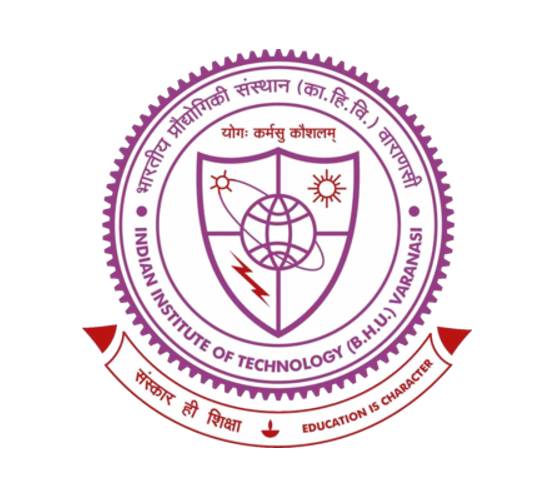

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("/kaggle/input/ugp-data-with-address/Fetched_Address (1).csv")
df.head()

Unnamed: 0  Duration(Days)  Latitude  Longitude  Severity  Area Affected  \
0           4            66.0   25.6339    84.0726       1.0      507167.44   
1           6            18.0   23.6547    89.4296       1.0      231516.28   
2           7           167.0   26.4813    92.0622       1.0       42285.99   
3           8            23.0   26.9880    92.9260       1.0       70501.83   
4          11            23.0   26.5037    86.5429       1.0      626872.46   

   Human fatality  Human injured  Human Displaced  Animal Fatality  ...  \
0           258.0            NaN        3040000.0              NaN  ...   
1            49.0            NaN         700000.0              NaN  ...   
2            76.0            NaN          43000.0              NaN  ...   
3            34.0            NaN        2000000.0              NaN  ...   
4           876.0            NaN           2000.0              NaN  ...   

  end_month      cause money  house  village  family       District  \
0         8  monsoonal   0.0    0.0      0.0     0.0          Buxar   
1        10      heavy   0.0    0.0      0.0     0.0         Magura   
2        11  monsoonal   0.0    0.0      0.0     0.0        Darrang   
3         7      heavy   0.0    0.0      0.0     0.0  Pakke-Kessang   
4         9  monsoonal   0.0    0.0      0.0     0.0      Madhubani   

               State  Start Date    End Date  
0              Bihar  15-06-1986  20-08-1986  
1    Khulna Division  22-09-1986  10-10-1986  
2              Assam  23-05-1988  06-11-1988  
3  Arunachal Pradesh  21-06-1988  14-07-1988  
4              Bihar  23-08-1988  15-09-1988  

[5 rows x 26 columns]

In [3]:
df.rename(columns = {'Unnamed: 0':'Index'}, inplace = True)
df.set_index("Index",inplace= True)
df.head()

Duration(Days)  Latitude  Longitude  Severity  Area Affected  \
Index                                                                 
4                66.0   25.6339    84.0726       1.0      507167.44   
6                18.0   23.6547    89.4296       1.0      231516.28   
7               167.0   26.4813    92.0622       1.0       42285.99   
8                23.0   26.9880    92.9260       1.0       70501.83   
11               23.0   26.5037    86.5429       1.0      626872.46   

       Human fatality  Human injured  Human Displaced  Animal Fatality  \
Index                                                                    
4               258.0            NaN        3040000.0              NaN   
6                49.0            NaN         700000.0              NaN   
7                76.0            NaN          43000.0              NaN   
8                34.0            NaN        2000000.0              NaN   
11              876.0            NaN           2000.0              NaN   

      Description of Casualties/injured  ... end_month      cause  money  \
Index                                    ...                               
4                                   NaN  ...         8  monsoonal    0.0   
6                                   NaN  ...        10      heavy    0.0   
7                                   NaN  ...        11  monsoonal    0.0   
8                                   NaN  ...         7      heavy    0.0   
11                                  NaN  ...         9  monsoonal    0.0   

       house  village  family       District              State  Start Date  \
Index                                                                         
4        0.0      0.0     0.0          Buxar              Bihar  15-06-1986   
6        0.0      0.0     0.0         Magura    Khulna Division  22-09-1986   
7        0.0      0.0     0.0        Darrang              Assam  23-05-1988   
8        0.0      0.0     0.0  Pakke-Kessang  Arunachal Pradesh  21-06-1988   
11       0.0      0.0     0.0      Madhubani              Bihar  23-08-1988   

         End Date  
Index              
4      20-08-1986  
6      10-10-1986  
7      06-11-1988  
8      14-07-1988  
11     15-09-1988  

[5 rows x 25 columns]

In [4]:
df['State'] = df['State'].str.strip().str.lower()
df['District'] = df['District'].str.strip().str.lower()

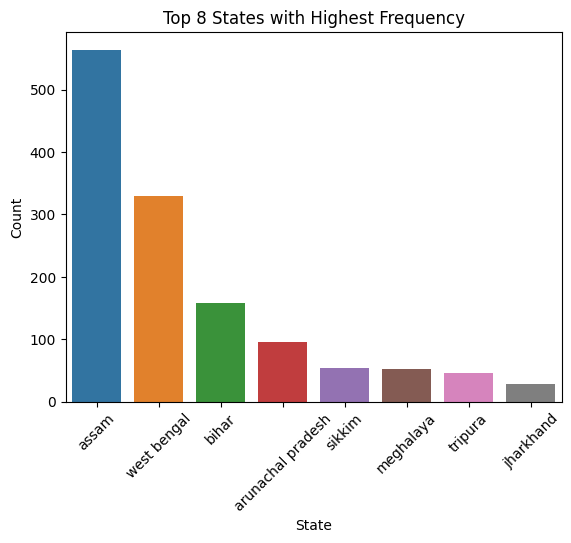

In [5]:
sns.barplot(x=df['State'].value_counts().index[:8], y=df['State'].value_counts()[:8])

# Rotate x-axis labels
plt.xticks(rotation=45)

# Add labels and show plot
plt.xlabel('State')
plt.ylabel('Count')
plt.title('Top 8 States with Highest Frequency')
plt.show()

In [6]:
df['State'].value_counts()

State
assam                                                       564
west bengal                                                 330
bihar                                                       158
arunachal pradesh                                            95
sikkim                                                       54
meghalaya                                                    53
tripura                                                      46
jharkhand                                                    29
mizoram                                                      27
manipur                                                      20
nagaland                                                     14
uttar pradesh                                                12
bihar, jharkhand                                              5
sylhet division                                               2
khulna division                                               2
maharastra                        

In [7]:
min(df['start_year'])

1968

In [8]:
df['time'] = ''
for ind in df.index:
    df.loc[ind,'time'] = str((df.loc[ind,'start_year'] - 1968)*12 + df.loc[ind,'start_month']) + "_" + df.loc[ind,'State']

In [9]:
df.head(10)

Duration(Days)  Latitude  Longitude  Severity  Area Affected  \
Index                                                                 
4                66.0   25.6339    84.0726       1.0      507167.44   
6                18.0   23.6547    89.4296       1.0      231516.28   
7               167.0   26.4813    92.0622       1.0       42285.99   
8                23.0   26.9880    92.9260       1.0       70501.83   
11               23.0   26.5037    86.5429       1.0      626872.46   
14              154.0   24.8678    92.8291       2.0      112816.35   
17                5.0   26.7553    92.7754       2.0       53045.31   
21                1.0   26.0747    92.8170       1.0       93839.75   
23              123.0   24.4696    92.4232       1.0       26042.82   
25                6.0   26.6059    92.9592       1.0       55550.83   

       Human fatality  Human injured  Human Displaced  Animal Fatality  \
Index                                                                    
4               258.0            NaN        3040000.0              NaN   
6                49.0            NaN         700000.0              NaN   
7                76.0            NaN          43000.0              NaN   
8                34.0            NaN        2000000.0              NaN   
11              876.0            NaN           2000.0              NaN   
14               31.0            NaN          32000.0              NaN   
17               21.0            NaN              0.0              NaN   
21               10.0            NaN           6000.0              NaN   
23               13.0            NaN          25000.0              NaN   
25               25.0            NaN         400000.0              NaN   

      Description of Casualties/injured  ...      cause money  house  village  \
Index                                    ...                                    
4                                   NaN  ...  monsoonal   0.0    0.0      0.0   
6                                   NaN  ...      heavy   0.0    0.0      0.0   
7                                   NaN  ...  monsoonal   0.0    0.0      0.0   
8                                   NaN  ...      heavy   0.0    0.0      0.0   
11                                  NaN  ...  monsoonal   0.0    0.0      0.0   
14                                  NaN  ...  monsoonal   0.0    0.0      0.0   
17                                  NaN  ...  monsoonal   0.0    0.0      0.0   
21                                  NaN  ...      heavy   0.0    0.0      0.0   
23                                  NaN  ...   tropical   0.0    0.0      0.0   
25                                  NaN  ...  monsoonal   0.0    0.0      0.0   

       family       District              State  Start Date    End Date  \
Index                                                                     
4         0.0          buxar              bihar  15-06-1986  20-08-1986   
6         0.0         magura    khulna division  22-09-1986  10-10-1986   
7         0.0        darrang              assam  23-05-1988  06-11-1988   
8         0.0  pakke-kessang  arunachal pradesh  21-06-1988  14-07-1988   
11        0.0      madhubani              bihar  23-08-1988  15-09-1988   
14        0.0         cachar              assam  07-05-1989  08-10-1989   
17        0.0       sonitpur              assam  13-06-1990  18-06-1990   
21        0.0          hojai              assam  17-10-1990  18-10-1990   
23        0.0      karimganj              assam  05-07-1991  05-11-1991   
25        0.0         nagaon              assam  13-07-1991  19-07-1991   

                        time  
Index                         
4                  222_bihar  
6        225_khulna division  
7                  245_assam  
8      246_arunachal pradesh  
11                 248_bihar  
14                 257_assam  
17                 270_assam  
21                 274_assam  
23                 283_assam  
25                 283_assam  

[10 rows x 26 colu

In [9]:
unique_hash = df['time'].unique()
len(unique_hash)

772

In [10]:
# df = df.sort_values(by = ['time'])

In [11]:
grouped = df.groupby('time')

In [12]:
grouped.first().head(20)

Duration(Days)   Latitude  \
time                                                                         
102_assam, manipur, tripura,  arunachal pradesh             7.0  25.083333   
102_west bengal                                             7.0  27.037755   
104_west bengal                                             7.0  26.709709   
105_bihar                                                  14.0  25.644085   
105_west bengal                                             7.0  22.996495   
10_west bengal                                              3.0  22.996495   
126_assam                                                   7.0  26.333333   
126_maharastra                                              7.0  27.156368   
127_assam                                                   7.0  26.333333   
127_bihar                                                  14.0  25.377352   
127_tripura                                                 7.0  23.916667   
128_assam                                                   7.0  25.856337   
128_bihar                                                   7.0  25.609324   
128_west bengal                                            14.0  25.005745   
129_bihar                                                   7.0  25.429412   
129_uttar pradesh                                          14.0  25.833333   
129_west bengal                                             7.0  22.420531   
130_bihar                                                   7.0  25.136491   
130_west bengal                                             7.0  22.181526   
138_assam                                                   1.0  26.180598   

                                                 Longitude  Severity  \
time                                                                   
102_assam, manipur, tripura,  arunachal pradesh  92.916667       NaN   
102_west bengal                                  88.263176       NaN   
104_west bengal                                  88.353818       NaN   
105_bihar                                        85.906508       NaN   
105_west bengal                                  87.685588       NaN   
10_west bengal                                   87.685588       NaN   
126_assam                                        91.250000       NaN   
126_maharastra                                   84.324412       NaN   
127_assam                                        91.250000       NaN   
127_bihar                                        86.473104       NaN   
127_tripura                                      91.500000       NaN   
128_assam                                        93.464967       NaN   
128_bihar                                        85.123525       NaN   
128_west bengal                                  88.139848       NaN   
129_bihar                                        86.710662       NaN   
129_uttar pradesh                                84.166667       NaN   
129_west bengal                                  87.321911       NaN   
130_bihar                                        85.443655       NaN   
130_west bengal                                  88.548438       NaN   
138_assam                                        91.753943       NaN   

                                                 Area Affected  \
time                                                             
102_assam, manipur, tripura,  arunachal pradesh            0.0   
102_west bengal                                            0.0   
104_west bengal                                            0.0   
105_bihar                                            1120000.0   
105_west bengal                                            0.0   
10_west bengal                                             0.0   
126_assam                                                  0.0   
126_maharastra                                             0.0   
127_assam                                             210000.0   
127_bihar            

In [13]:
grouped.first().shape

(772, 25)

In [14]:
grouped.get_group('138_assam')

Duration(Days)   Latitude  Longitude  Severity  Area Affected  \
Index                                                                  
554               1.0  26.180598  91.753943       NaN            0.0   

       Human fatality  Human injured  Human Displaced  Animal Fatality  \
Index                                                                    
554               NaN            NaN              0.0              NaN   

      Description of Casualties/injured  ...  cause money  house  village  \
Index                                    ...                                
554                                 NaN  ...  heavy   0.0  100.0      0.0   

       family  District  State  Start Date    End Date       time  
Index                                                              
554       0.0  guwahati  assam  30-06-1979  30-06-1979  138_assam  

[1 rows x 26 columns]

In [15]:
group_df = grouped.get_group('138_assam')
len(group_df['Event Source'].unique())

1

In [16]:
check_hash = []
for hashs in unique_hash:
    group_df = grouped.get_group(hashs)
    if len(group_df['Event Source'].unique()) == 2:
        check_hash.append(hashs)

In [17]:
len(check_hash)

33

In [18]:
check_hash

['222_bihar',
 '245_assam',
 '248_bihar',
 '270_assam',
 '274_assam',
 '285_west bengal',
 '330_assam',
 '343_bihar',
 '353_assam',
 '393_west bengal',
 '414_assam',
 '414_west bengal',
 '438_bihar',
 '461_assam',
 '474_assam',
 '478_manipur',
 '485_assam',
 '500_assam',
 '507_assam',
 '508_assam',
 '509_assam',
 '513_bihar',
 '534_assam',
 '537_assam',
 '546_assam',
 '561_assam',
 '566_assam',
 '572_assam',
 '582_assam',
 '583_bihar',
 '590_assam',
 '595_west bengal',
 '617_tripura']

In [19]:
grouped.get_group('561_assam')

Duration(Days)   Latitude  Longitude  Severity  Area Affected  \
Index                                                                  
165              47.0  26.746500  92.489100       1.5       61894.97   
4194              9.0  27.466832  94.517865       NaN    16012834.00   

       Human fatality  Human injured  Human Displaced  Animal Fatality  \
Index                                                                    
165              59.0            NaN          30000.0              NaN   
4194             45.0            0.0         311001.0              0.0   

                       Description of Casualties/injured  ...      cause  \
Index                                                     ...              
165                                                  NaN  ...  monsoonal   
4194   More than 45 people including 3 died in a land...  ...      flood   

      money  house  village  family  District  State  Start Date    End Date  \
Index                                                                          
165     0.0    0.0      0.0     0.0  sonitpur  assam  24-09-2014  10-11-2014   
4194    0.0    0.0   2500.0     0.0   dhemaji  assam  22-09-2014  30-09-2014   

            time  
Index             
165    561_assam  
4194   561_assam  

[2 rows x 26 columns]

537_assam
566_assam
343_bihar
438_bihar
393_west bengal
595_west bengal

area affected --> 775 zero enteries & 403 Nan Enteries

In [10]:
pd.set_option('display.max_columns', None)
df

Duration(Days)   Latitude  Longitude  Severity  Area Affected  \
Index                                                                  
4                66.0  25.633900  84.072600       1.0      507167.44   
6                18.0  23.654700  89.429600       1.0      231516.28   
7               167.0  26.481300  92.062200       1.0       42285.99   
8                23.0  26.988000  92.926000       1.0       70501.83   
11               23.0  26.503700  86.542900       1.0      626872.46   
...               ...        ...        ...       ...            ...   
7070              1.0  27.128016  88.272793       NaN            NaN   
7127              1.0  26.485157  89.524693       NaN            NaN   
7157              1.0  23.385892  92.930599       NaN            NaN   
7160              1.0  27.418517  88.180834       NaN            NaN   
7161              1.0  27.037755  88.263176       NaN            NaN   

       Human fatality  Human injured  Human Displaced  Animal Fatality  \
Index                                                                    
4               258.0            NaN        3040000.0              NaN   
6                49.0            NaN         700000.0              NaN   
7                76.0            NaN          43000.0              NaN   
8                34.0            NaN        2000000.0              NaN   
11              876.0            NaN           2000.0              NaN   
...               ...            ...              ...              ...   
7070              1.0            NaN              NaN              NaN   
7127              2.0            NaN              NaN              NaN   
7157              1.0            1.0              NaN              NaN   
7160              1.0            NaN              NaN              NaN   
7161              1.0            NaN              NaN              NaN   

      Description of Casualties/injured Extent of damage  Event Source  \
Index                                                                    
4                                   NaN               NaN          DFO   
6                                   NaN               NaN          DFO   
7                                   NaN               NaN          DFO   
8                                   NaN               NaN          DFO   
11                                  NaN               NaN          DFO   
...                                 ...               ...          ...   
7070                                NaN               NaN          IMD   
7127                                NaN               NaN          IMD   
7157                                NaN               NaN          IMD   
7160                                NaN               NaN          IMD   
7161                                NaN               NaN          IMD   

       start_year  start_month  end_year  end_month      cause  money  house  \
Index                                                                          
4            1986            6      1986          8  monsoonal    0.0    0.0   
6            1986            9      1986         10      heavy    0.0    0.0   
7            1988            5      1988         11  monsoonal    0.0    0.0   
8            1988            6      1988          7      heavy    0.0    0.0   
11           1988            8      1988          9  monsoonal    0.0    0.0   
...           ...          ...       ...        ...        ...    ...    ...   
7070         2023            6      2023          6      other    0.0    0.0   
7127         2023            7      2023          7      heavy    0.0    0.0   
7157         2023            9      2023          9  landslide    0.0    0.0   
7160         2023            8      2023          8  landslide    0.0    0.0   
7161         2023            8      2023          8  landslide    0.0    0.0   

       village  family       District              State  Start Date  \
Index                          

In [11]:
df_new = df.replace([0],[np.nan])

In [12]:
df_new.isnull().sum()/df_new.shape[0]*100

Duration(Days)                        0.000000
Latitude                              0.000000
Longitude                             0.000000
Severity                             95.524476
Area Affected                        82.377622
Human fatality                       39.790210
Human injured                        86.853147
Human Displaced                      68.111888
Animal Fatality                      89.370629
Description of Casualties/injured    55.664336
Extent of damage                     32.657343
Event Source                          0.000000
start_year                            0.000000
start_month                           0.000000
end_year                              0.000000
end_month                             0.000000
cause                                 0.000000
money                                96.363636
house                                87.902098
village                              82.237762
family                               95.244755
District     

In [23]:
df_new = df_new.drop(['Latitude','Longitude','Description of Casualties/injured','Extent of damage ','start_year','end_year','District','State','Start Date','End Date','time'],axis = 1)
df_new.describe()

Duration(Days)   Severity  Area Affected  Human fatality  \
count     1430.000000  64.000000   2.520000e+02      861.000000   
mean         7.481119   1.257812   2.548111e+05       34.867596   
std         21.394279   0.377882   1.161129e+06      182.438651   
min          1.000000   1.000000   1.337804e+01        1.000000   
25%          1.000000   1.000000   6.646907e+03        1.000000   
50%          1.000000   1.000000   4.248745e+04        4.000000   
75%          7.000000   1.500000   1.620547e+05       17.000000   
max        304.000000   2.000000   1.601283e+07     3083.000000   

       Human injured  Human Displaced  Animal Fatality  start_month  \
count     188.000000     4.560000e+02     1.520000e+02  1430.000000   
mean       21.941489     1.010897e+06     7.606802e+04     6.964336   
std       146.461478     3.298374e+06     4.221019e+05     1.769657   
min         1.000000     1.000000e+00     1.000000e+00     1.000000   
25%         2.000000     3.000000e+03     1.000000e+01     6.000000   
50%         4.000000     6.585850e+04     1.000000e+02     7.000000   
75%        10.000000     4.398800e+05     1.282000e+03     8.000000   
max      2000.000000     4.000000e+07     3.500000e+06    12.000000   

         end_month         money         house       village        family  
count  1430.000000  5.200000e+01  1.730000e+02    254.000000     68.000000  
mean      7.159441  1.121566e+09  2.643017e+04    657.933071   5399.485294  
std       1.621593  5.372970e+09  1.608661e+05   1516.026692  12948.031225  
min       1.000000  7.000000e+05  2.000000e+00      3.000000     15.000000  
25%       6.000000  1.000000e+07  6.000000e+01     32.000000    159.250000  
50%       7.000000  7.750000e+07  4.000000e+02    100.000000    500.000000  
75%       8.000000  5.000000e+08  5.708000e+03    449.750000   4659.500000  
max      12.000000  3.868000e+10  2.000000e+06  15191.000000  80000.000000

In [24]:
df_new

Duration(Days)  Severity  Area Affected  Human fatality  Human injured  \
Index                                                                           
4                66.0       1.0      507167.44           258.0            NaN   
6                18.0       1.0      231516.28            49.0            NaN   
7               167.0       1.0       42285.99            76.0            NaN   
8                23.0       1.0       70501.83            34.0            NaN   
11               23.0       1.0      626872.46           876.0            NaN   
...               ...       ...            ...             ...            ...   
7070              1.0       NaN            NaN             1.0            NaN   
7127              1.0       NaN            NaN             2.0            NaN   
7157              1.0       NaN            NaN             1.0            1.0   
7160              1.0       NaN            NaN             1.0            NaN   
7161              1.0       NaN            NaN             1.0            NaN   

       Human Displaced  Animal Fatality Event Source  start_month  end_month  \
Index                                                                          
4            3040000.0              NaN          DFO            6          8   
6             700000.0              NaN          DFO            9         10   
7              43000.0              NaN          DFO            5         11   
8            2000000.0              NaN          DFO            6          7   
11              2000.0              NaN          DFO            8          9   
...                ...              ...          ...          ...        ...   
7070               NaN              NaN          IMD            6          6   
7127               NaN              NaN          IMD            7          7   
7157               NaN              NaN          IMD            9          9   
7160               NaN              NaN          IMD            8          8   
7161               NaN              NaN          IMD            8          8   

           cause  money  house  village  family  
Index                                            
4      monsoonal    NaN    NaN      NaN     NaN  
6          heavy    NaN    NaN      NaN     NaN  
7      monsoonal    NaN    NaN      NaN     NaN  
8          heavy    NaN    NaN      NaN     NaN  
11     monsoonal    NaN    NaN      NaN     NaN  
...          ...    ...    ...      ...     ...  
7070       other    NaN    NaN      NaN     NaN  
7127       heavy    NaN    NaN      NaN     NaN  
7157   landslide    NaN    NaN      NaN     NaN  
7160   landslide    NaN    NaN      NaN     NaN  
7161   landslide    NaN    NaN      NaN     NaN  

[1430 rows x 15 columns]

<Axes: xlabel='Index', ylabel='Duration(Days)'>

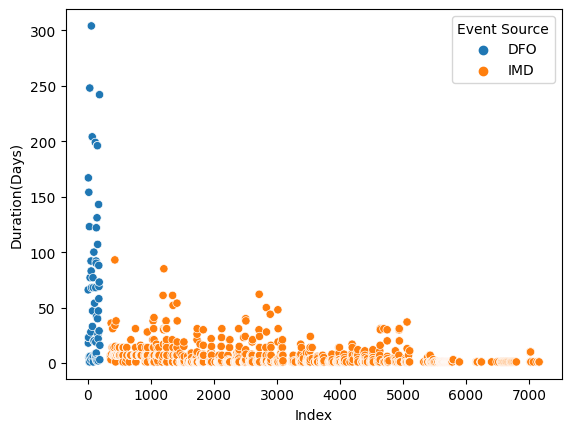

In [25]:
sns.scatterplot(x=df_new.index, y=df_new['Duration(Days)'], hue=df_new['Event Source'])

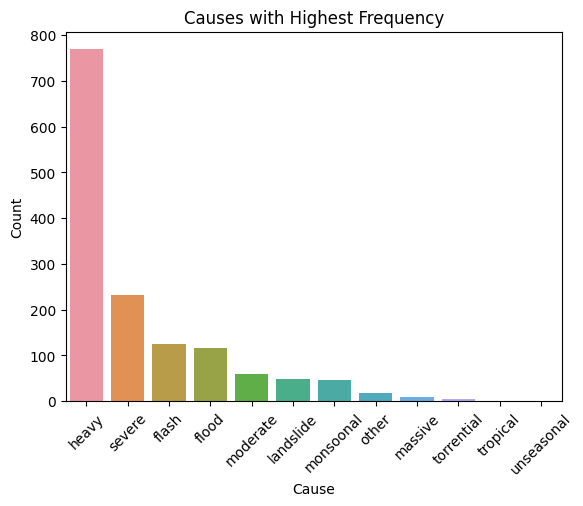

In [26]:
sns.barplot(x=df['cause'].value_counts().index, y=df['cause'].value_counts())

# Rotate x-axis labels
plt.xticks(rotation=45)

# Add labels and show plot
plt.xlabel('Cause')
plt.ylabel('Count')
plt.title('Causes with Highest Frequency')
plt.show()

<Axes: title={'center': 'Range of duration of floods corresponding to different causes'}, xlabel='cause', ylabel='Duration(Days)'>

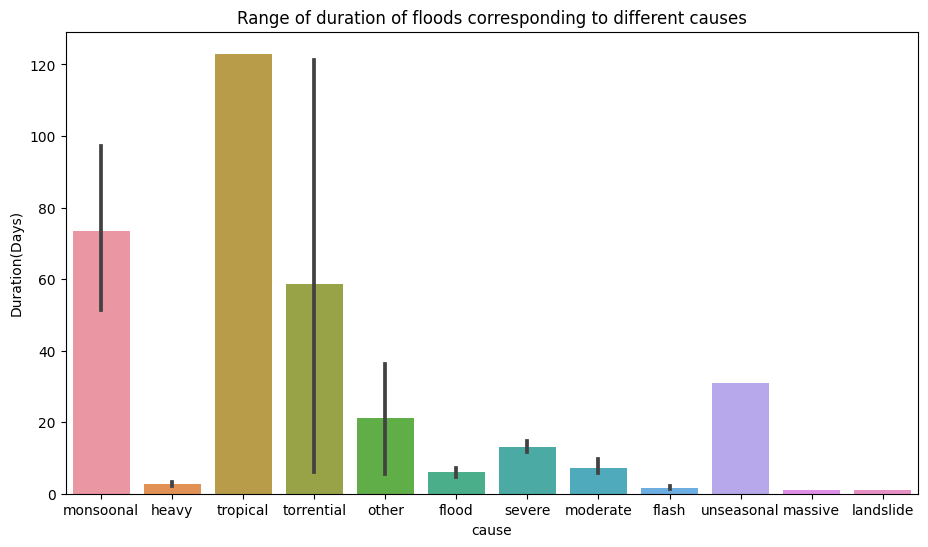

In [27]:
plt.figure(figsize=(11,6))
plt.title("Range of duration of floods corresponding to different causes")
sns.barplot(x=df_new['cause'], y= df_new['Duration(Days)'])

/opt/conda/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


<Axes: xlabel='cause', ylabel='Human Displaced'>

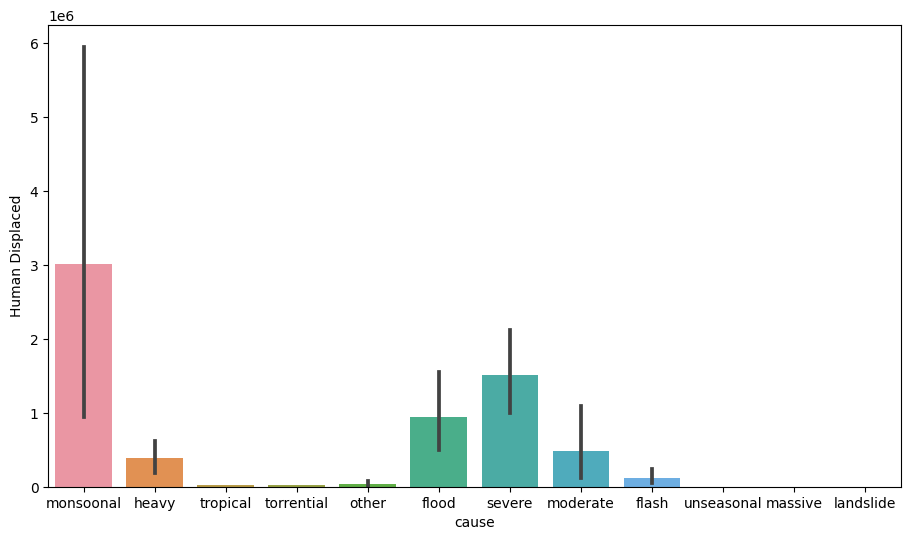

In [28]:
plt.figure(figsize=(11,6))
# plt.title("Range of duration of floods corresponding to different causes")
sns.barplot(x=df_new['cause'], y= df_new['Human Displaced'])

<Axes: xlabel='cause', ylabel='Human fatality'>

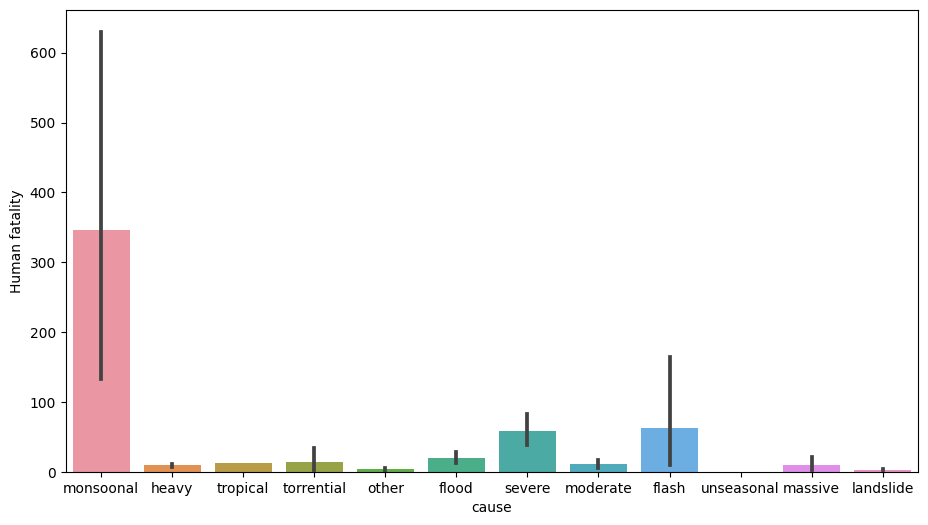

In [29]:
plt.figure(figsize=(11,6))
sns.barplot(x=df_new['cause'], y= df_new['Human fatality'])

/opt/conda/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


<Axes: xlabel='cause', ylabel='Area Affected'>

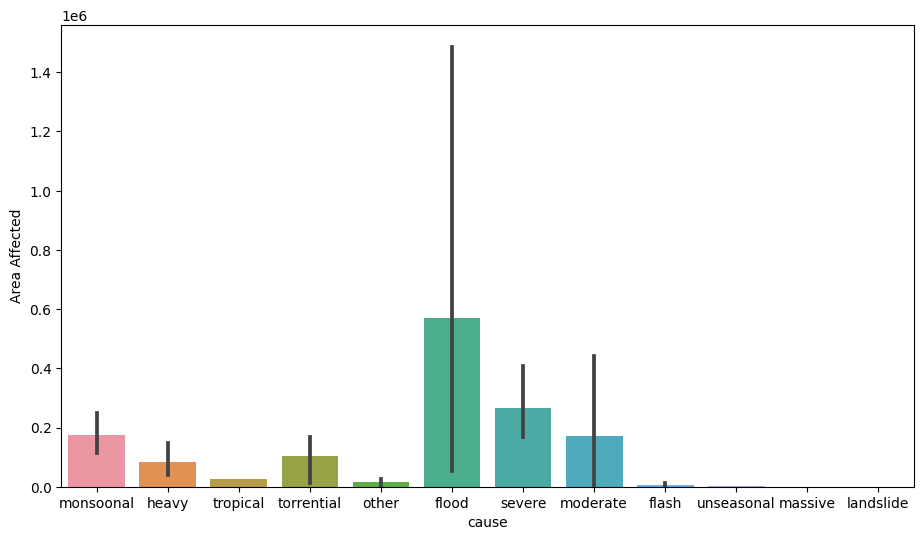

In [30]:
plt.figure(figsize=(11,6))
sns.barplot(x=df_new['cause'], y= df_new['Area Affected'])

/opt/conda/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


<Axes: xlabel='cause', ylabel='house'>

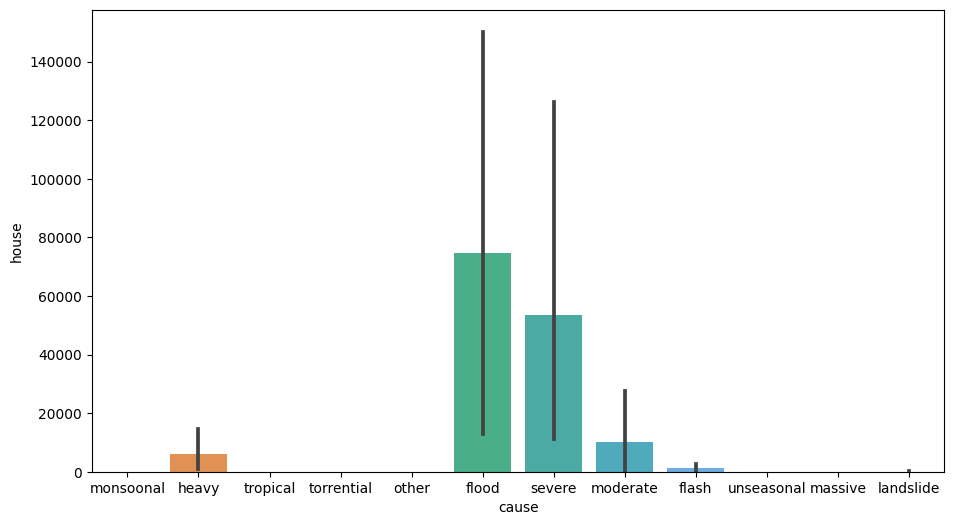

In [31]:
plt.figure(figsize=(11,6))
sns.barplot(x=df_new['cause'], y= df_new['house'])

/opt/conda/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


<Axes: xlabel='cause', ylabel='Human injured'>

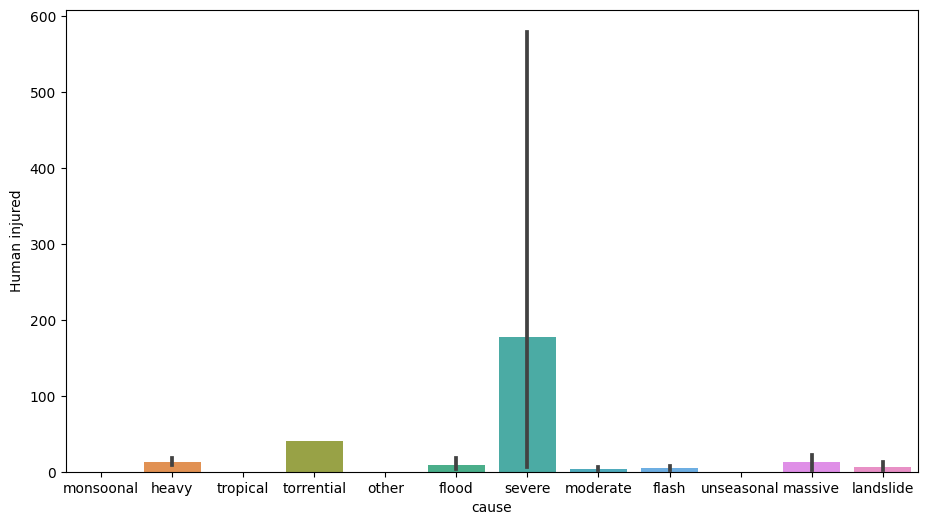

In [32]:
plt.figure(figsize=(11,6))
sns.barplot(x=df_new['cause'], y= df_new['Human injured'])

<Axes: xlabel='Duration(Days)', ylabel='Human Displaced'>

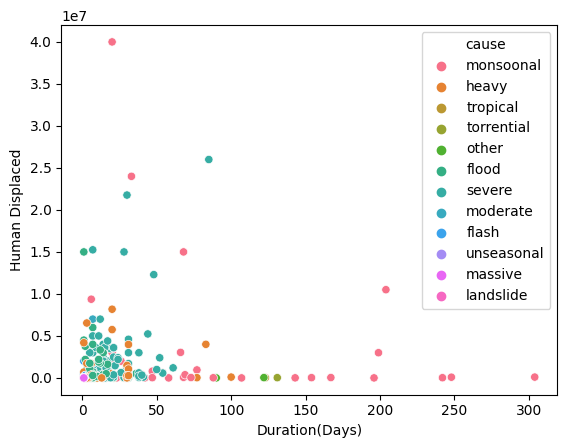

In [33]:
sns.scatterplot(x=df_new['Duration(Days)'], y=df_new['Human Displaced'], hue=df_new['cause'])

<Axes: xlabel='Duration(Days)', ylabel='Human Displaced'>

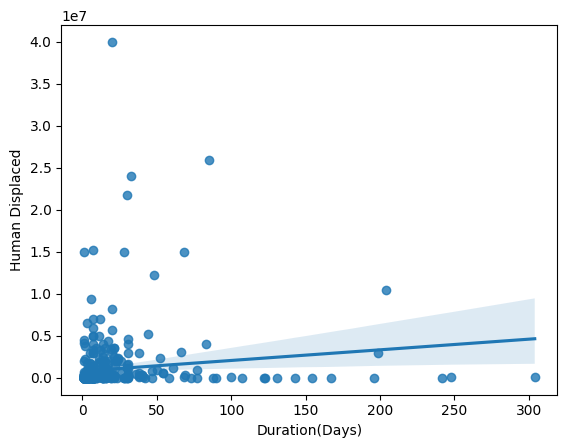

In [34]:
sns.regplot(x=df_new['Duration(Days)'], y=df_new['Human Displaced'])

In [35]:
df_new.columns

Index(['Duration(Days)', 'Severity', 'Area Affected', 'Human fatality',
       'Human injured', 'Human Displaced', 'Animal Fatality', 'Event Source',
       'start_month', 'end_month', 'cause', 'money', 'house', 'village',
       'family'],
      dtype='object')

<Axes: xlabel='Severity', ylabel='Human Displaced'>

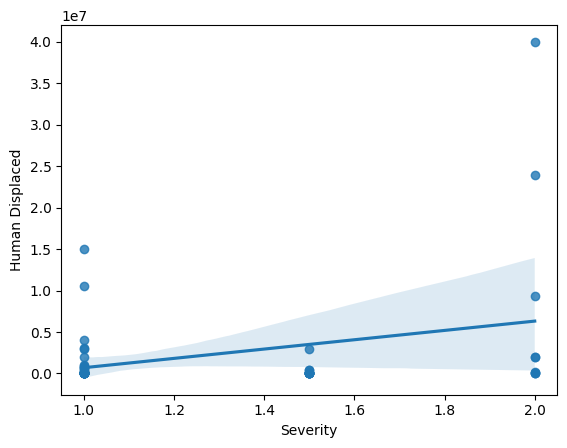

In [36]:
sns.regplot(x=df_new['Severity'], y=df_new['Human Displaced'])

In [37]:
df_new[df_new['Area Affected']<1.620547e+06]

Duration(Days)  Severity  Area Affected  Human fatality  Human injured  \
Index                                                                           
4                66.0       1.0      507167.44           258.0            NaN   
6                18.0       1.0      231516.28            49.0            NaN   
7               167.0       1.0       42285.99            76.0            NaN   
8                23.0       1.0       70501.83            34.0            NaN   
11               23.0       1.0      626872.46           876.0            NaN   
...               ...       ...            ...             ...            ...   
4938             31.0       NaN      131300.00            81.0           50.0   
4939             31.0       NaN       75710.00             4.0           50.0   
4940             30.0       NaN       26652.00             7.0           50.0   
4941             31.0       NaN       25300.00             4.0           50.0   
5039              1.0       NaN          44.50             2.0            3.0   

       Human Displaced  Animal Fatality Event Source  start_month  end_month  \
Index                                                                          
4            3040000.0              NaN          DFO            6          8   
6             700000.0              NaN          DFO            9         10   
7              43000.0              NaN          DFO            5         11   
8            2000000.0              NaN          DFO            6          7   
11              2000.0              NaN          DFO            8          9   
...                ...              ...          ...          ...        ...   
4938         3979000.0        3500000.0          IMD            1          7   
4939         1062000.0         900000.0          IMD            1          8   
4940          280000.0          73000.0          IMD            1          9   
4941          270700.0          74000.0          IMD            1         10   
5039             531.0              NaN          IMD           10         10   

           cause  money  house  village  family  
Index                                            
4      monsoonal    NaN    NaN      NaN     NaN  
6          heavy    NaN    NaN      NaN     NaN  
7      monsoonal    NaN    NaN      NaN     NaN  
8          heavy    NaN    NaN      NaN     NaN  
11     monsoonal    NaN    NaN      NaN     NaN  
...          ...    ...    ...      ...     ...  
4938       heavy    NaN    NaN   3200.0     NaN  
4939       heavy    NaN    NaN   1000.0     NaN  
4940       heavy    NaN    NaN    450.0     NaN  
4941       heavy    NaN    NaN    400.0     NaN  
5039       heavy    NaN    NaN      7.0     NaN  

[247 rows x 15 columns]

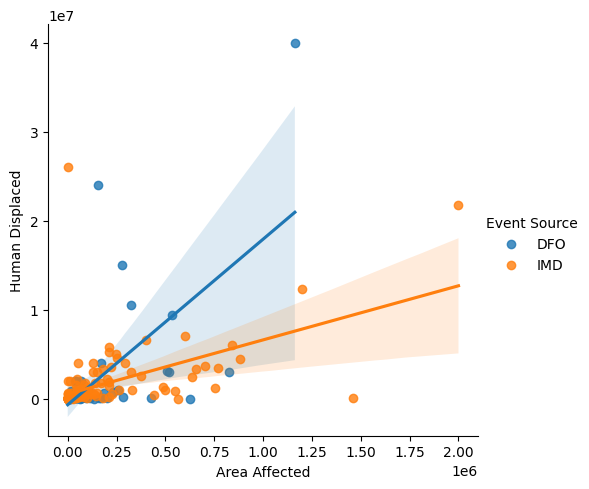

In [38]:
# sns.lmplot(x=df_new['Area Affected'], y=df_new['Human Displaced'],hue = df_new['Event Source'])
sns.lmplot(x="Area Affected", y="Human Displaced", hue="Event Source", data=df_new[df_new['Area Affected']<5.620547e+06])

In [39]:
df_new[df_new['Human fatality']<1000]

Duration(Days)  Severity  Area Affected  Human fatality  Human injured  \
Index                                                                           
4                66.0       1.0      507167.44           258.0            NaN   
6                18.0       1.0      231516.28            49.0            NaN   
7               167.0       1.0       42285.99            76.0            NaN   
8                23.0       1.0       70501.83            34.0            NaN   
11               23.0       1.0      626872.46           876.0            NaN   
...               ...       ...            ...             ...            ...   
7070              1.0       NaN            NaN             1.0            NaN   
7127              1.0       NaN            NaN             2.0            NaN   
7157              1.0       NaN            NaN             1.0            1.0   
7160              1.0       NaN            NaN             1.0            NaN   
7161              1.0       NaN            NaN             1.0            NaN   

       Human Displaced  Animal Fatality Event Source  start_month  end_month  \
Index                                                                          
4            3040000.0              NaN          DFO            6          8   
6             700000.0              NaN          DFO            9         10   
7              43000.0              NaN          DFO            5         11   
8            2000000.0              NaN          DFO            6          7   
11              2000.0              NaN          DFO            8          9   
...                ...              ...          ...          ...        ...   
7070               NaN              NaN          IMD            6          6   
7127               NaN              NaN          IMD            7          7   
7157               NaN              NaN          IMD            9          9   
7160               NaN              NaN          IMD            8          8   
7161               NaN              NaN          IMD            8          8   

           cause  money  house  village  family  
Index                                            
4      monsoonal    NaN    NaN      NaN     NaN  
6          heavy    NaN    NaN      NaN     NaN  
7      monsoonal    NaN    NaN      NaN     NaN  
8          heavy    NaN    NaN      NaN     NaN  
11     monsoonal    NaN    NaN      NaN     NaN  
...          ...    ...    ...      ...     ...  
7070       other    NaN    NaN      NaN     NaN  
7127       heavy    NaN    NaN      NaN     NaN  
7157   landslide    NaN    NaN      NaN     NaN  
7160   landslide    NaN    NaN      NaN     NaN  
7161   landslide    NaN    NaN      NaN     NaN  

[855 rows x 15 columns]

<Axes: xlabel='Human fatality', ylabel='Human Displaced'>

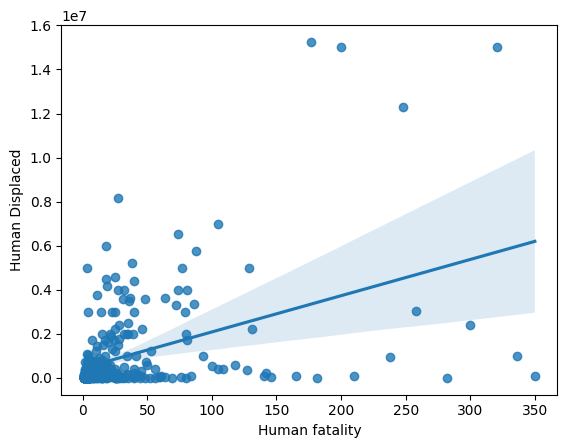

In [40]:
sns.regplot(x=df_new[df_new['Human fatality']<400]['Human fatality'], y=df_new[df_new['Human fatality']<400]['Human Displaced'])

In [41]:
from sklearn.preprocessing import LabelEncoder

In [42]:
df_new['Event Source']=df_new['Event Source'].replace(['DFO','IMD'],[0,1])

/tmp/ipykernel_55/1525638398.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_new['Event Source']=df_new['Event Source'].replace(['DFO','IMD'],[0,1])


In [43]:
df_new['Event Source'].value_counts()

Event Source
1    1366
0      64
Name: count, dtype: int64

In [44]:
df_new['cause'].unique()

array(['monsoonal', 'heavy', 'tropical', 'torrential', 'other', 'flood',
       'severe', 'moderate', 'flash', 'unseasonal', 'massive',
       'landslide'], dtype=object)

In [45]:
df_new['cause'].value_counts()

cause
heavy         769
severe        231
flash         125
flood         117
moderate       60
landslide      49
monsoonal      46
other          18
massive         9
torrential      4
tropical        1
unseasonal      1
Name: count, dtype: int64

In [46]:
# encoder = LabelEncoder()
# df_new['cause'] = encoder.fit_transform(df_new['cause'])

df_new = df_new.replace(['unseasonal','other','tropical','landslide','massive','torrential','flash','heavy','moderate','flood','severe','monsoonal'],[1,2,3,4,5,6,7,8,9,10,11,12])

/tmp/ipykernel_55/101060692.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_new = df_new.replace(['unseasonal','other','tropical','landslide','massive','torrential','flash','heavy','moderate','flood','severe','monsoonal'],[1,2,3,4,5,6,7,8,9,10,11,12])


In [47]:
df_new['cause'].value_counts()

cause
8     769
11    231
7     125
10    117
9      60
4      49
12     46
2      18
5       9
6       4
3       1
1       1
Name: count, dtype: int64

<Axes: xlabel='start_month', ylabel='Duration(Days)'>

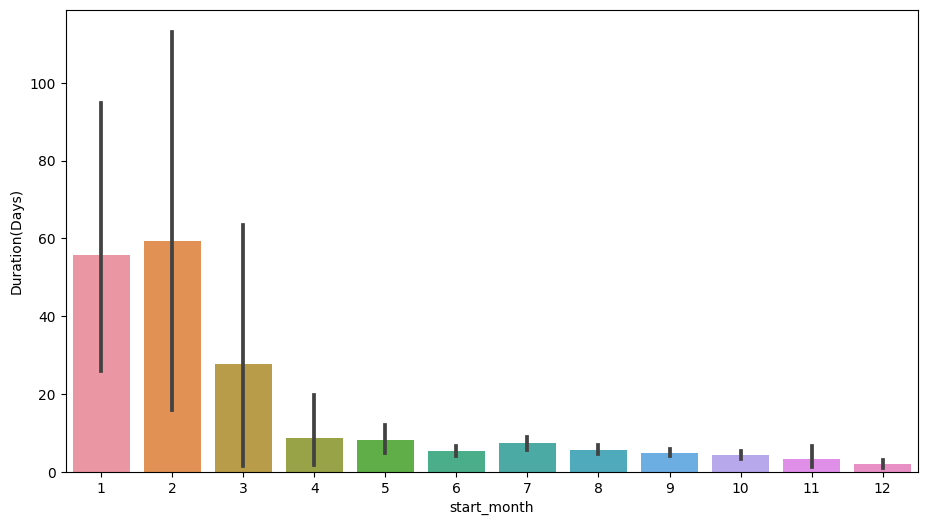

In [48]:
plt.figure(figsize=(11,6))
sns.barplot(x=df_new['start_month'], y= df_new['Duration(Days)'])

/opt/conda/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


<Axes: xlabel='start_month', ylabel='village'>

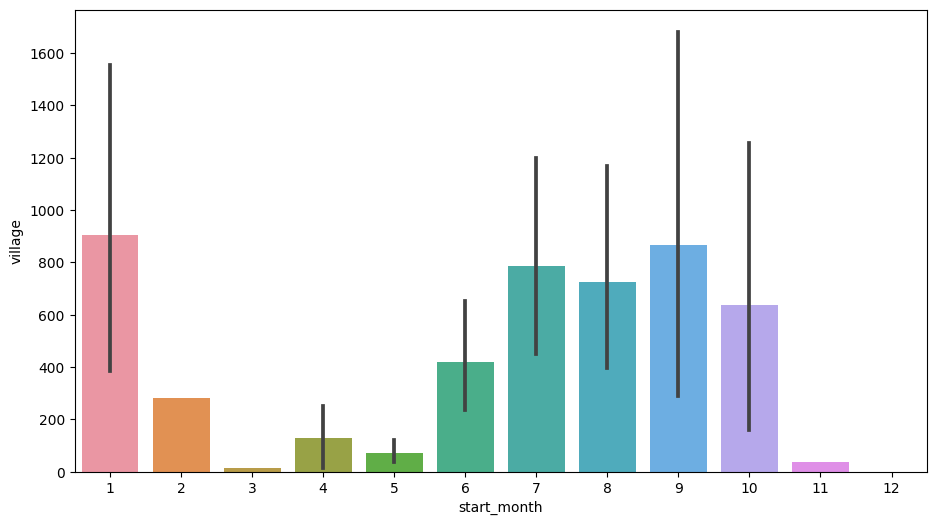

In [49]:
plt.figure(figsize=(11,6))
sns.barplot(x=df_new['start_month'], y= df_new['village'])

/opt/conda/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


<Axes: xlabel='start_month', ylabel='money'>

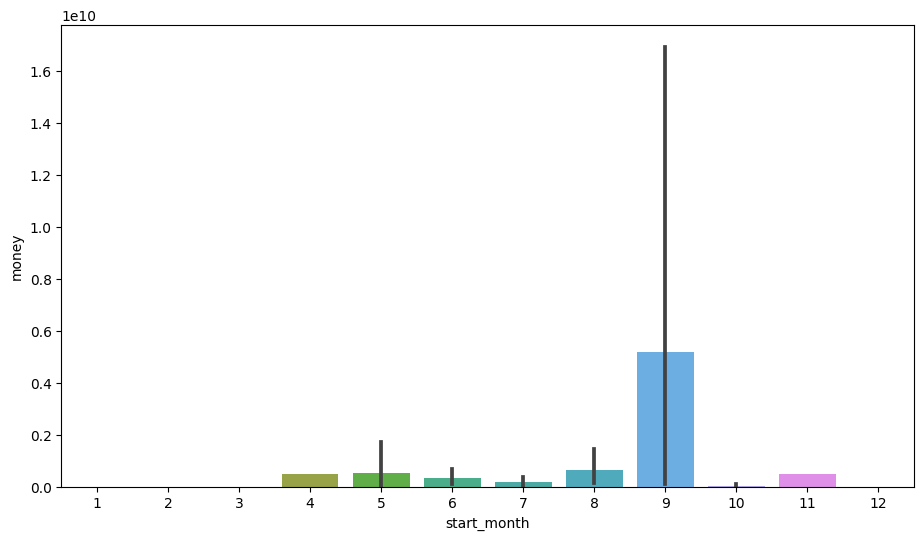

In [50]:
plt.figure(figsize=(11,6))
sns.barplot(x=df_new['start_month'], y= df_new['money'])

/opt/conda/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


<Axes: xlabel='start_month', ylabel='house'>

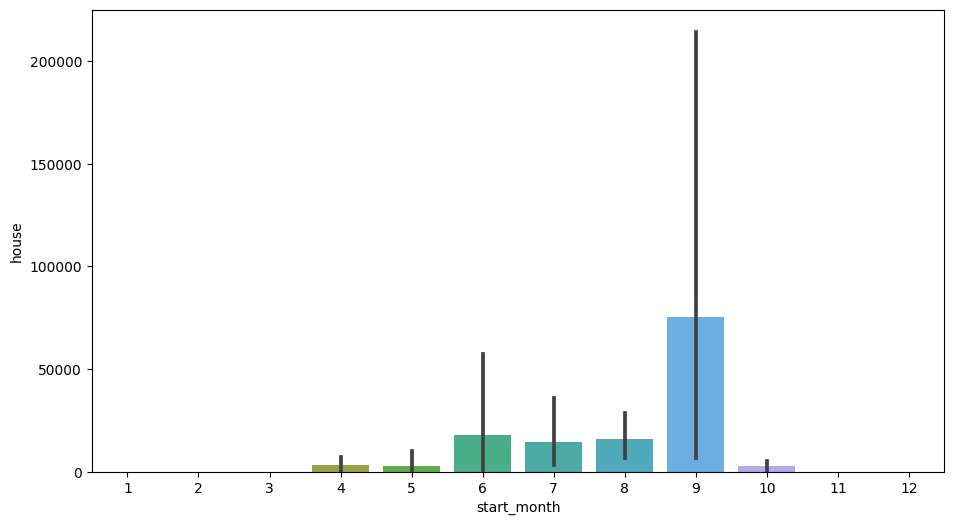

In [51]:
plt.figure(figsize=(11,6))
sns.barplot(x=df_new['start_month'], y= df_new['house'])

/opt/conda/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


<Axes: xlabel='start_month', ylabel='Human fatality'>

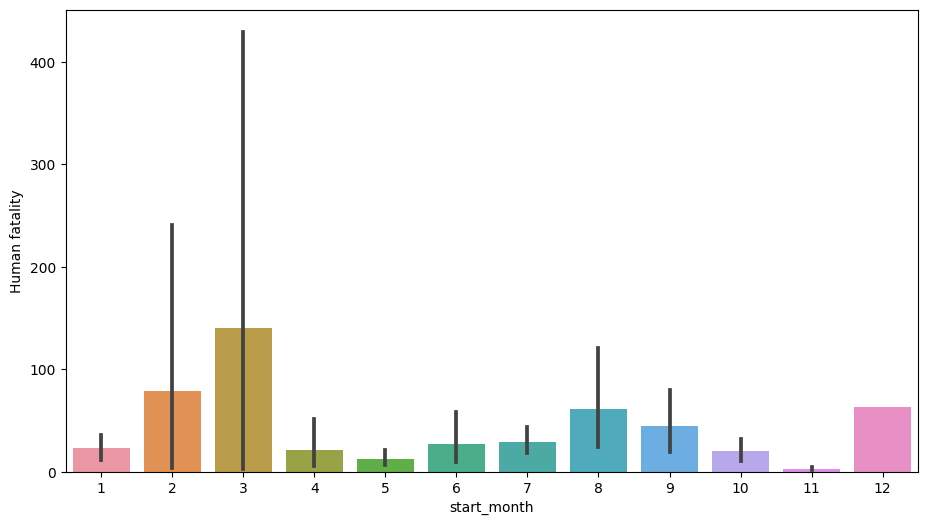

In [52]:
plt.figure(figsize=(11,6))
sns.barplot(x=df_new['start_month'], y= df_new['Human fatality'])

/opt/conda/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


<Axes: xlabel='start_month', ylabel='Human Displaced'>

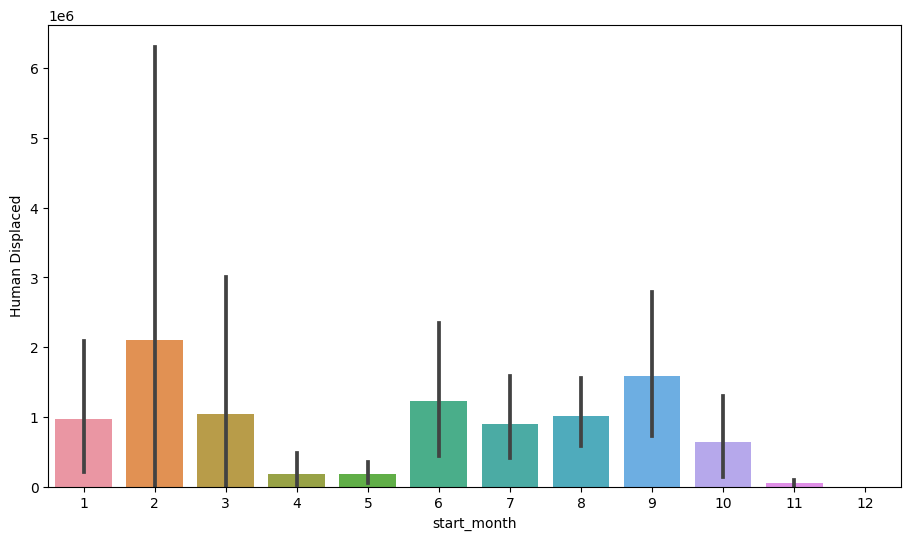

In [53]:
plt.figure(figsize=(11,6))
sns.barplot(x=df_new['start_month'], y= df_new['Human Displaced'])

In [54]:
df_new['Season'] = 0
for ind in df_new.index:
    if df_new.loc[ind,'start_month']>=10:
        df_new.loc[ind,'Season'] = 1
    elif df_new.loc[ind,'start_month']>=6:
        df_new.loc[ind,'Season'] = 3
    elif df_new.loc[ind,'start_month']>=4:
        df_new.loc[ind,'Season'] = 1
    else:
        df_new.loc[ind,'Season'] = 0

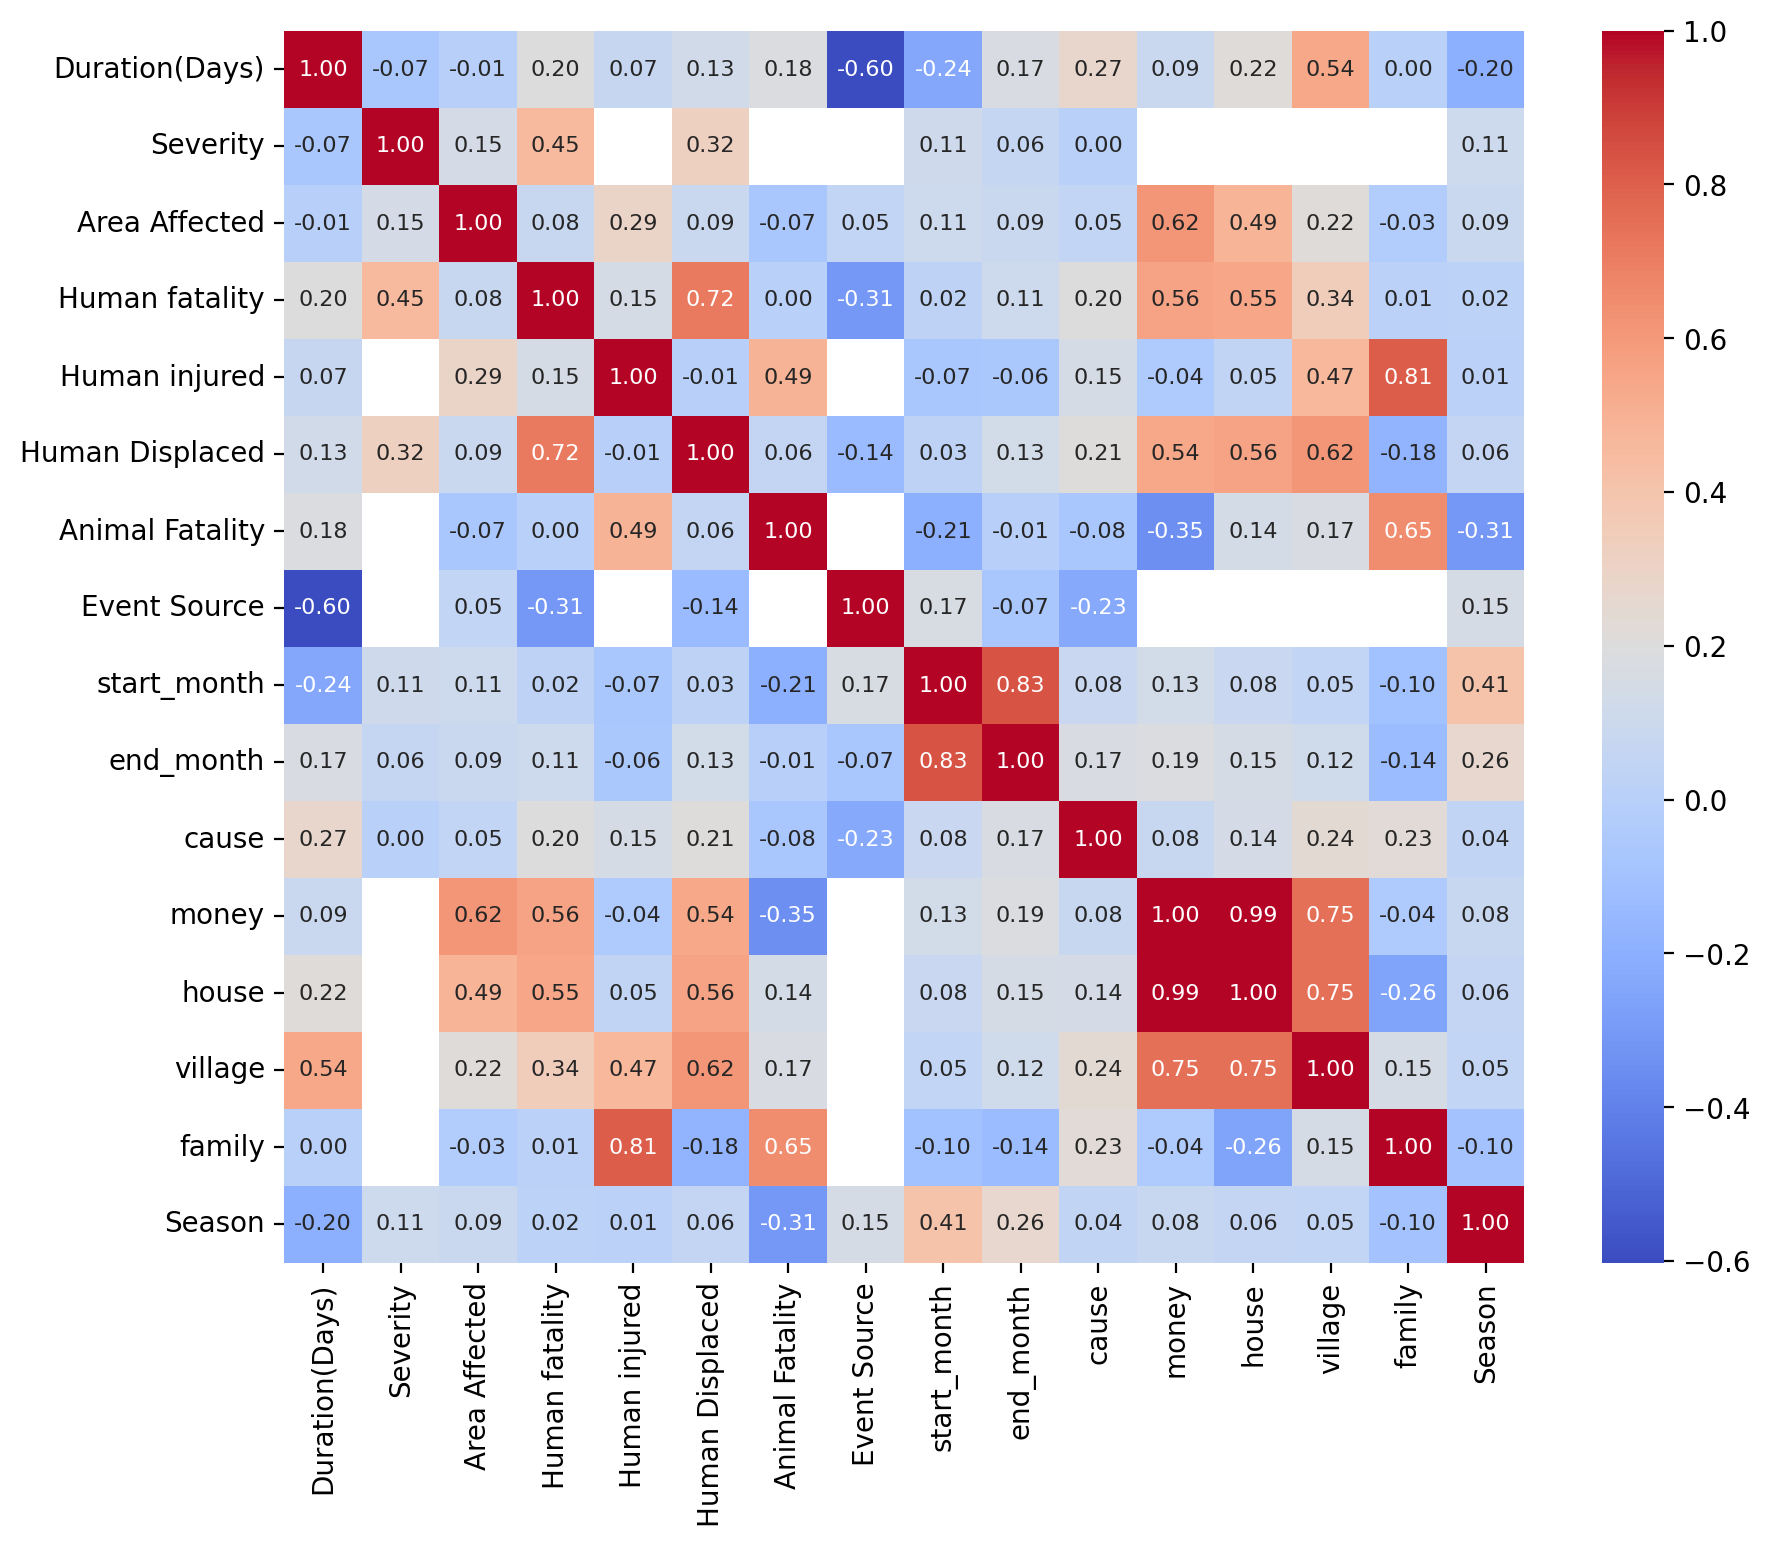

In [55]:
# Calculate correlation matrix
corr = df_new.corr()

# Set figure size and DPI
plt.figure(figsize=(10, 8), dpi=200)

# Plot heatmap
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 8})

# Rotate y-axis labels for better readability (optional)
plt.yticks(rotation=0)

# Show plot
plt.show()


In [207]:
see = df_new[['Human fatality','Season','Human Displaced']]
see[(~see['Human Displaced'].isnull()) & (~see['Human fatality'].isnull())]

Human fatality  Season  Human Displaced
Index                                         
4               258.0       3        3040000.0
6                49.0       3         700000.0
7                76.0       1          43000.0
8                34.0       3        2000000.0
11              876.0       3           2000.0
...               ...     ...              ...
5709              5.0       3              1.0
5714              3.0       3              1.0
5752              1.0       3              1.0
6161             56.0       3              5.0
7031              8.0       1             11.0

[298 rows x 3 columns]

In [238]:
df_HF=df_new[['Duration(Days)','Event Source','start_month','end_month','cause','Human fatality','Season','Human Displaced']]

In [239]:
df_HF=df_HF.dropna()

In [240]:
df_HF

Duration(Days)  Event Source  start_month  end_month  cause  \
Index                                                                
4                66.0             0            6          8     12   
6                18.0             0            9         10      8   
7               167.0             0            5         11     12   
8                23.0             0            6          7      8   
11               23.0             0            8          9     12   
...               ...           ...          ...        ...    ...   
5709              1.0             1            6          6      8   
5714              1.0             1            6          6      8   
5752              1.0             1            7          7      8   
6161              1.0             1            6          6      5   
7031              1.0             1            5          5      5   

       Human fatality  Season  Human Displaced  
Index                                           
4               258.0       3        3040000.0  
6                49.0       3         700000.0  
7                76.0       1          43000.0  
8                34.0       3        2000000.0  
11              876.0       3           2000.0  
...               ...     ...              ...  
5709              5.0       3              1.0  
5714              3.0       3              1.0  
5752              1.0       3              1.0  
6161             56.0       3              5.0  
7031              8.0       1             11.0  

[298 rows x 8 columns]

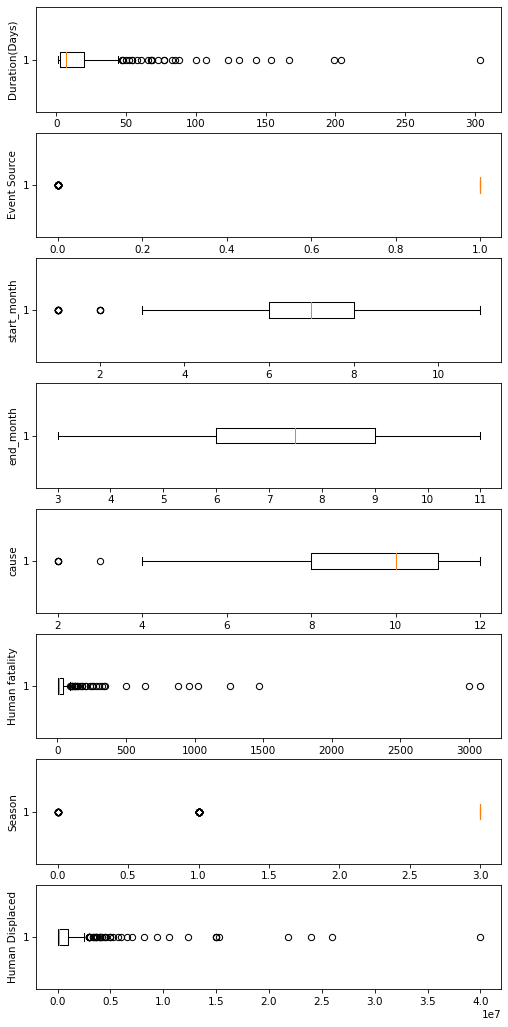

In [241]:
fig, axs = plt.subplots(8,1,dpi=75, figsize=(8,17))
i = 0
for col in df_HF.columns:
    axs[i].boxplot(df_HF[col], vert=False)
    axs[i].set_ylabel(col)
    i+=1
plt.show()

In [242]:
df_HF.describe()

Duration(Days)  Event Source  start_month   end_month       cause  \
count      298.000000    298.000000   298.000000  298.000000  298.000000   
mean        18.761745      0.855705     6.919463    7.543624    9.617450   
std         33.450304      0.351980     1.955797    1.563400    2.038674   
min          1.000000      0.000000     1.000000    3.000000    2.000000   
25%          3.000000      1.000000     6.000000    6.000000    8.000000   
50%          7.000000      1.000000     7.000000    7.500000   10.000000   
75%         20.000000      1.000000     8.000000    9.000000   11.000000   
max        304.000000      1.000000    11.000000   11.000000   12.000000   

       Human fatality      Season  Human Displaced  
count      298.000000  298.000000     2.980000e+02  
mean        75.308725    2.513423     1.462547e+06  
std        291.257841    0.954250     3.981371e+06  
min          1.000000    0.000000     1.000000e+00  
25%          4.000000    3.000000     1.000000e+04  
50%         14.000000    3.000000     1.514885e+05  
75%         39.000000    3.000000     1.000000e+06  
max       3083.000000    3.000000     4.000000e+07

In [243]:
print(df_HF['Human fatality'].mean())
print(df_HF['Human fatality'].median())

75.30872483221476
14.0


In [219]:
# q1,q3 = np.percentile(df_HF['Duration(Days)'],[25,75])
# iqr = q3-q1
# lower_bound = q1 - 1.5*iqr
# upper_bound = q3 + 1.5*iqr
# df_HF = df_HF[(df_HF['Duration(Days)']>=lower_bound) & (df_HF['Duration(Days)']<=upper_bound)]

# q1,q3 = np.percentile(df_HF['Human fatality'],[25,75])
# iqr = q3-q1
# lower_bound = q1 - 1.5*iqr
# upper_bound = q3 + 1.5*iqr
# df_HF = df_HF[(df_HF['Human fatality']>=lower_bound) & (df_HF['Human fatality']<=upper_bound)]

In [244]:
df_HF.describe()

Duration(Days)  Event Source  start_month   end_month       cause  \
count      298.000000    298.000000   298.000000  298.000000  298.000000   
mean        18.761745      0.855705     6.919463    7.543624    9.617450   
std         33.450304      0.351980     1.955797    1.563400    2.038674   
min          1.000000      0.000000     1.000000    3.000000    2.000000   
25%          3.000000      1.000000     6.000000    6.000000    8.000000   
50%          7.000000      1.000000     7.000000    7.500000   10.000000   
75%         20.000000      1.000000     8.000000    9.000000   11.000000   
max        304.000000      1.000000    11.000000   11.000000   12.000000   

       Human fatality      Season  Human Displaced  
count      298.000000  298.000000     2.980000e+02  
mean        75.308725    2.513423     1.462547e+06  
std        291.257841    0.954250     3.981371e+06  
min          1.000000    0.000000     1.000000e+00  
25%          4.000000    3.000000     1.000000e+04  
50%         14.000000    3.000000     1.514885e+05  
75%         39.000000    3.000000     1.000000e+06  
max       3083.000000    3.000000     4.000000e+07

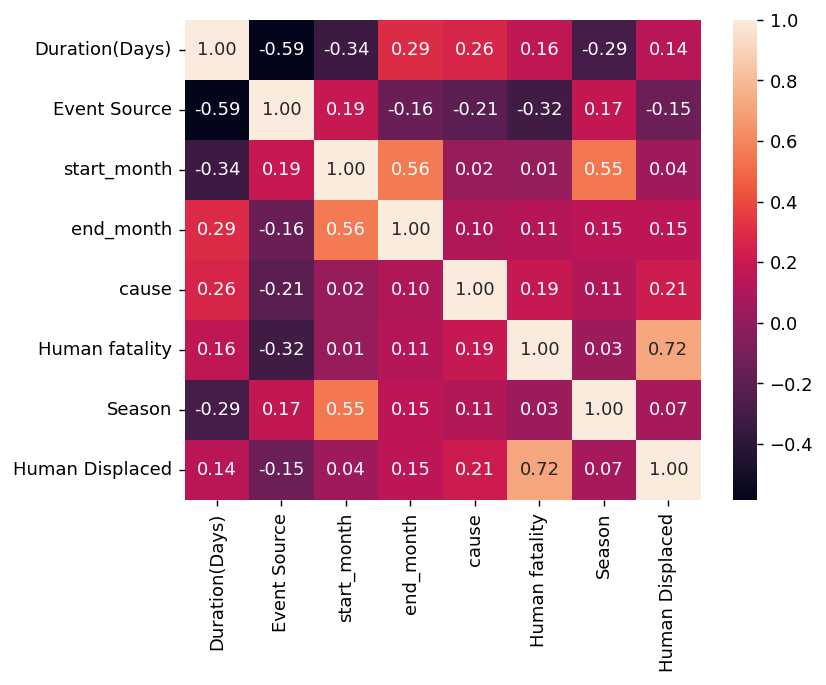

In [245]:
import seaborn as sns
corr = df_HF.corr()
 
plt.figure(dpi=130)
sns.heatmap(df_HF.corr(), annot=True, fmt= '.2f')
plt.show()

In [246]:
from sklearn.model_selection import train_test_split

In [247]:
x_hf = df_HF.drop('Human fatality',axis=1)
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
x_hf = scaler.fit_transform(x_hf)

In [248]:
x_hf

array([[ 3.47058824, -1.        , -0.5       , ...,  0.66666667,
         0.        ,  2.91768838],
       [ 0.64705882, -1.        ,  1.        , ..., -0.66666667,
         0.        ,  0.55405202],
       [ 9.41176471, -1.        , -1.        , ...,  0.66666667,
        -2.        , -0.10958434],
       ...,
       [-0.35294118,  0.        ,  0.        , ..., -0.66666667,
         0.        , -0.15301768],
       [-0.35294118,  0.        , -0.5       , ..., -1.66666667,
         0.        , -0.15301364],
       [-0.35294118,  0.        , -1.        , ..., -1.66666667,
        -2.        , -0.15300758]])

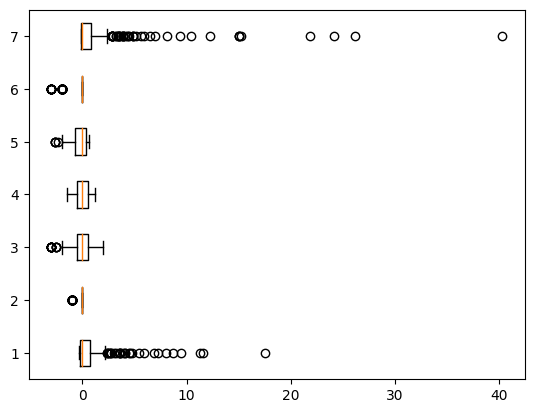

In [249]:
plt.boxplot(x_hf,vert=False)
plt.show()

In [250]:
x_train_hf,x_test_hf,y_train_hf,y_test_hf = train_test_split(x_hf,df_HF['Human fatality'])

In [251]:
print(x_train_hf.shape)
print(x_test_hf.shape)

(223, 7)
(75, 7)


In [252]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [253]:
from sklearn.linear_model import Ridge
model = Ridge()
model.fit(x_train_hf,y_train_hf)
predictions = model.predict(x_test_hf)
print("MAE: ", mean_absolute_error(y_test_hf,predictions))
print("MSE: ", mean_squared_error(y_test_hf,predictions))
print("r2 score: ",r2_score(y_test_hf,predictions))

MAE:  96.31595795149474
MSE:  128629.92582697287
r2 score:  0.47118986316936484


In [263]:
import tensorflow as tf 
from tensorflow import keras
from keras.layers import Dense, PReLU

model=keras.Sequential()
model.add(keras.layers.Dense(128,input_dim=7,activation='relu'))
# model.add(keras.layers.Dense(64,activation='relu'))
model.add(keras.layers.Dense(32,activation='relu'))
# model.add(keras.layers.Dense(16,activation='relu'))
model.add(keras.layers.Dense(1,activation='linear'))

model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 128)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,185 (20.25 KB)

 Trainable params: 5,185 (20.25 KB)

 Non-trainable params: 0 (0.00 B)

In [274]:
history=model.fit(x_train_hf,y_train_hf,validation_split=0.3,epochs=100)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2751.8235 - mae: 29.1321 - val_loss: 18007.2266 - val_mae: 66.3042
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4186.3276 - mae: 34.1529 - val_loss: 18037.9316 - val_mae: 66.4440
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2966.8574 - mae: 31.5022 - val_loss: 18032.3145 - val_mae: 66.5694
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2791.8203 - mae: 30.2006 - val_loss: 18050.9453 - val_mae: 66.4900
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2626.8401 - mae: 28.1762 - val_loss: 18000.4258 - val_mae: 66.5136
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3422.1030 - mae: 30.5085 - val_loss: 18011.3496 - val_mae: 66.5796
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3546.9341 - mae: 32.5282 - val_loss: 18016.8555 - val_mae: 66.3887
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3829.5669 - mae: 33.0155 - val_loss: 17974.5039 - val_mae: 66.3510
Epoch 

In [275]:
predictions = model.predict(x_test_hf)
print("MAE: ", mean_absolute_error(y_test_hf,predictions))
print("MSE: ", mean_squared_error(y_test_hf,predictions))
print("r2 score: ",r2_score(y_test_hf,predictions))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MAE:  87.98757693370183
MSE:  108586.28483558794
r2 score:  0.5535912209179191


In [276]:
y_test_hf

Index
3527      32.0
4936       6.0
678        1.0
4638      32.0
4189       8.0
         ...  
5039       2.0
1620       7.0
35      3083.0
46        40.0
5579       1.0
Name: Human fatality, Length: 75, dtype: float64

In [277]:
predictions

array([[ 3.1865202e+01],
       [ 2.0817301e+01],
       [ 3.2211563e+01],
       [ 6.2971935e+00],
       [ 6.7766247e+00],
       [ 6.5900011e+00],
       [-5.4129353e+00],
       [ 6.5074756e+02],
       [ 4.4611107e+01],
       [ 1.8541483e+01],
       [ 4.5182098e+01],
       [ 2.2809517e+00],
       [ 4.9820507e+01],
       [ 1.8051771e+01],
       [ 3.8289436e+01],
       [ 3.7058487e+01],
       [ 3.2229012e+01],
       [ 3.1801483e+01],
       [ 8.3951082e+00],
       [ 1.0077623e+01],
       [ 5.6473951e+00],
       [ 3.2316223e+01],
       [ 1.9878504e+01],
       [ 3.6038246e+01],
       [ 3.6102776e+01],
       [ 4.8674900e+01],
       [ 1.6943556e+01],
       [-2.6404390e-01],
       [ 2.3714077e+01],
       [ 1.6847326e+01],
       [ 3.1093265e+02],
       [ 1.2727981e+01],
       [ 1.0344393e+01],
       [ 1.4918531e+01],
       [ 3.9696419e+01],
       [ 4.8750305e+01],
       [ 3.0320621e+01],
       [ 1.9496374e+01],
       [ 4.5045250e+01],
       [ 1.6136385e+01],


In [290]:
y_test_hf.shape

(75,)

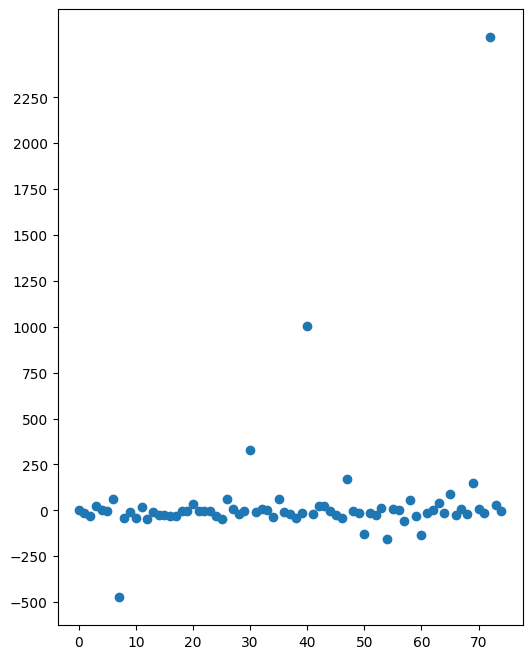

In [326]:
plt.figure(figsize=(6,8))
plt.scatter(np.arange(0,75),np.array(y_test_hf) - predictions.flatten())
plt.yticks(np.arange(-500,2500,250))
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


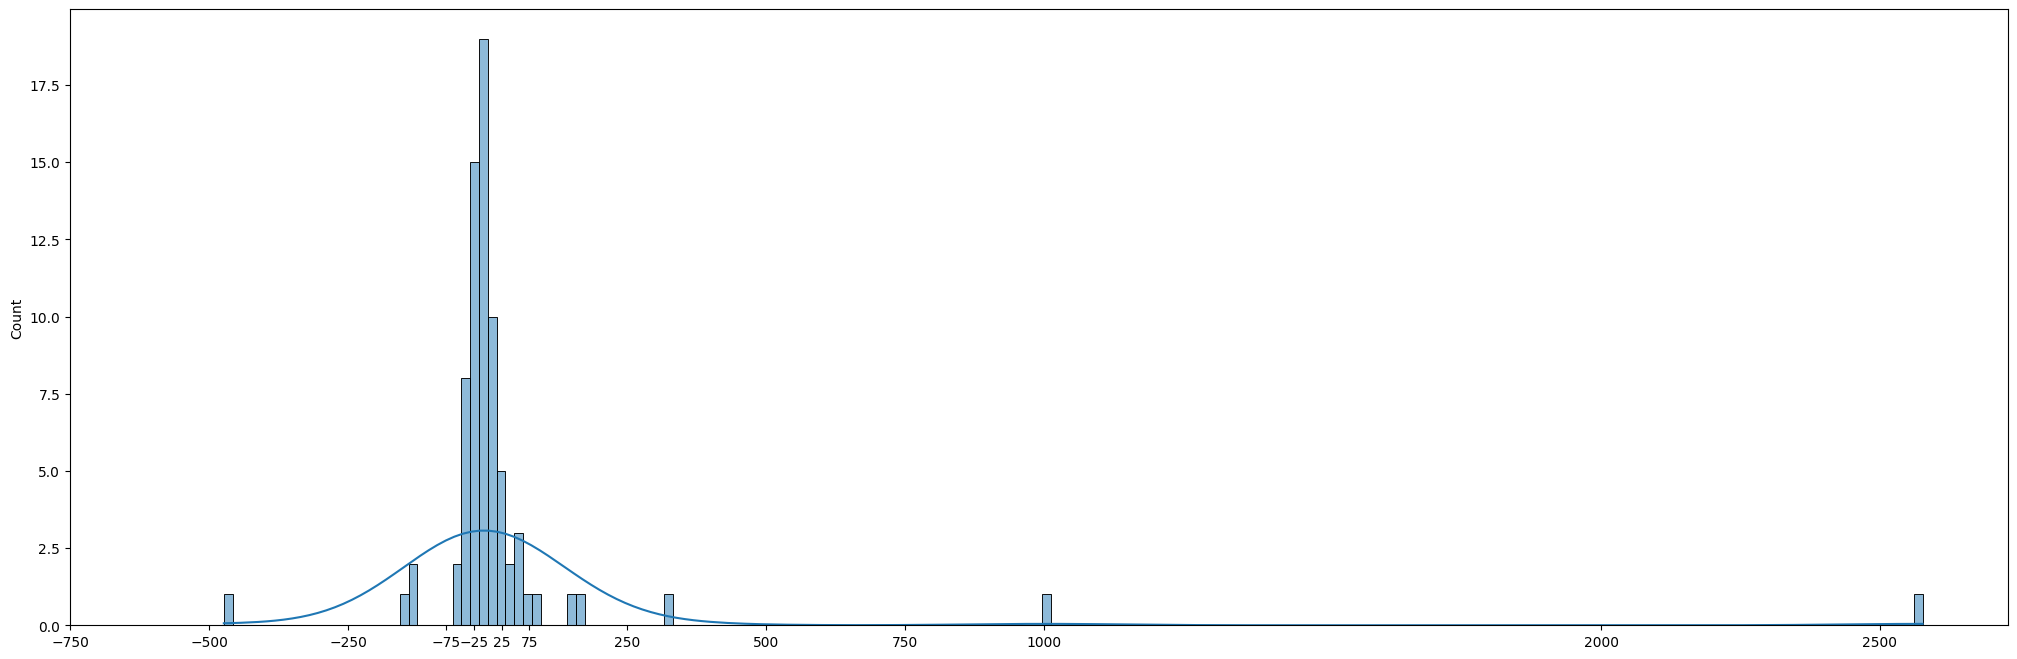

In [325]:
plt.figure(figsize=(25,8))
sns.histplot(np.array(y_test_hf) - predictions.flatten(),kde=True)
plt.xticks([-750,-500,-250,-75,-25,25,75,250,500,750,1000,2000,2500])
plt.show()

Defining other models to predict human displaced

In [271]:
pred = np.array([y_train_hf.median()]*y_test_hf.shape[0])
print("MAE: ", mean_absolute_error(y_test_hf,pred))
print("MSE: ", mean_squared_error(y_test_hf,pred))
print("r2 score: ",r2_score(y_test_hf,pred))

MAE:  117.04
MSE:  254423.6
r2 score:  -0.0459601672313974


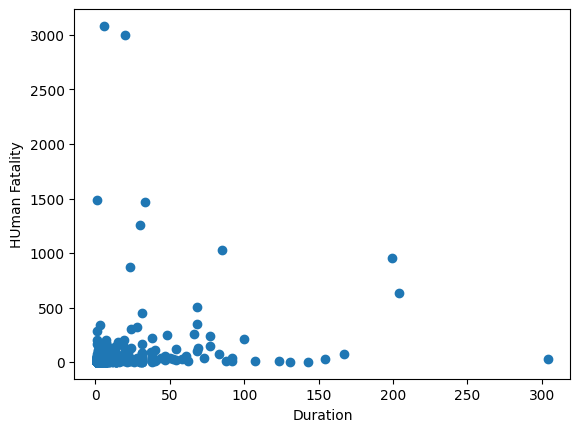

In [55]:
plt.scatter(df_new['Duration(Days)'],df_new['Human fatality'])
plt.xlabel('Duration')
plt.ylabel('HUman Fatality')
plt.show()

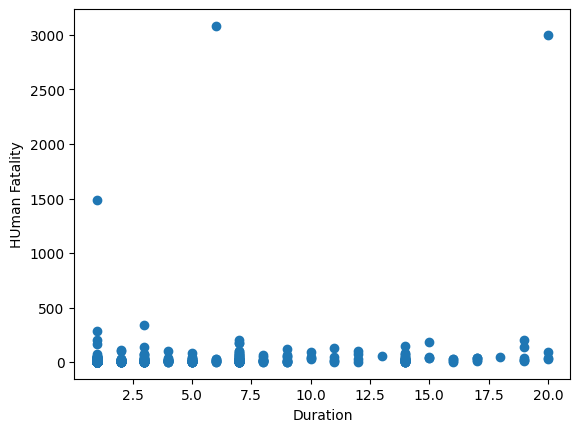

In [60]:
plt.scatter(df_new[df_new['Duration(Days)']<21]['Duration(Days)'],df_new[df_new['Duration(Days)']<21]['Human fatality'])
plt.xlabel('Duration')
plt.ylabel('HUman Fatality')
plt.show()

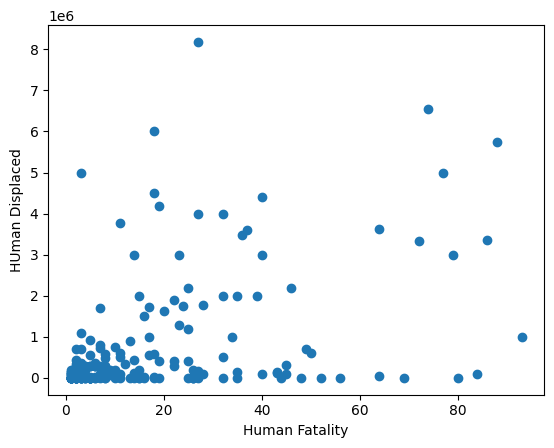

In [63]:
plt.scatter(df_new[(df_new['Duration(Days)']<21) & (df_new['Human fatality']<100)]['Human fatality'],df_new[(df_new['Duration(Days)']<21) & (df_new['Human fatality']<100)]['Human Displaced'])
plt.xlabel('Human Fatality')
plt.ylabel('HUman Displaced')
plt.show()

In [64]:
df_new.columns

Index(['Duration(Days)', 'Severity', 'Area Affected', 'Human fatality',
       'Human injured', 'Human Displaced', 'Animal Fatality', 'Event Source',
       'start_month', 'end_month', 'cause', 'money', 'house', 'village',
       'family'],
      dtype='object')

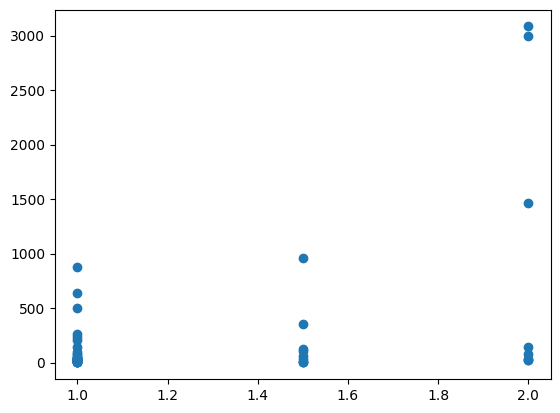

In [66]:
plt.scatter(df_new['Severity'],df_new['Human fatality'])

In [72]:
df_disc = df_new[~df_new['Human Displaced'].isnull()]

In [73]:
df_disc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456 entries, 4 to 7031
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Duration(Days)   456 non-null    float64
 1   Severity         54 non-null     float64
 2   Area Affected    187 non-null    float64
 3   Human fatality   298 non-null    float64
 4   Human injured    66 non-null     float64
 5   Human Displaced  456 non-null    float64
 6   Animal Fatality  56 non-null     float64
 7   Event Source     456 non-null    int64  
 8   start_month      456 non-null    int64  
 9   end_month        456 non-null    int64  
 10  cause            456 non-null    int64  
 11  money            34 non-null     float64
 12  house            94 non-null     float64
 13  village          160 non-null    float64
 14  family           20 non-null     float64
 15  Season           456 non-null    int64  
dtypes: float64(11), int64(5)
memory usage: 60.6 KB


In [74]:
df_disc.isnull().sum()/df_disc.shape[0]*100

Duration(Days)      0.000000
Severity           88.157895
Area Affected      58.991228
Human fatality     34.649123
Human injured      85.526316
Human Displaced     0.000000
Animal Fatality    87.719298
Event Source        0.000000
start_month         0.000000
end_month           0.000000
cause               0.000000
money              92.543860
house              79.385965
village            64.912281
family             95.614035
Season              0.000000
dtype: float64

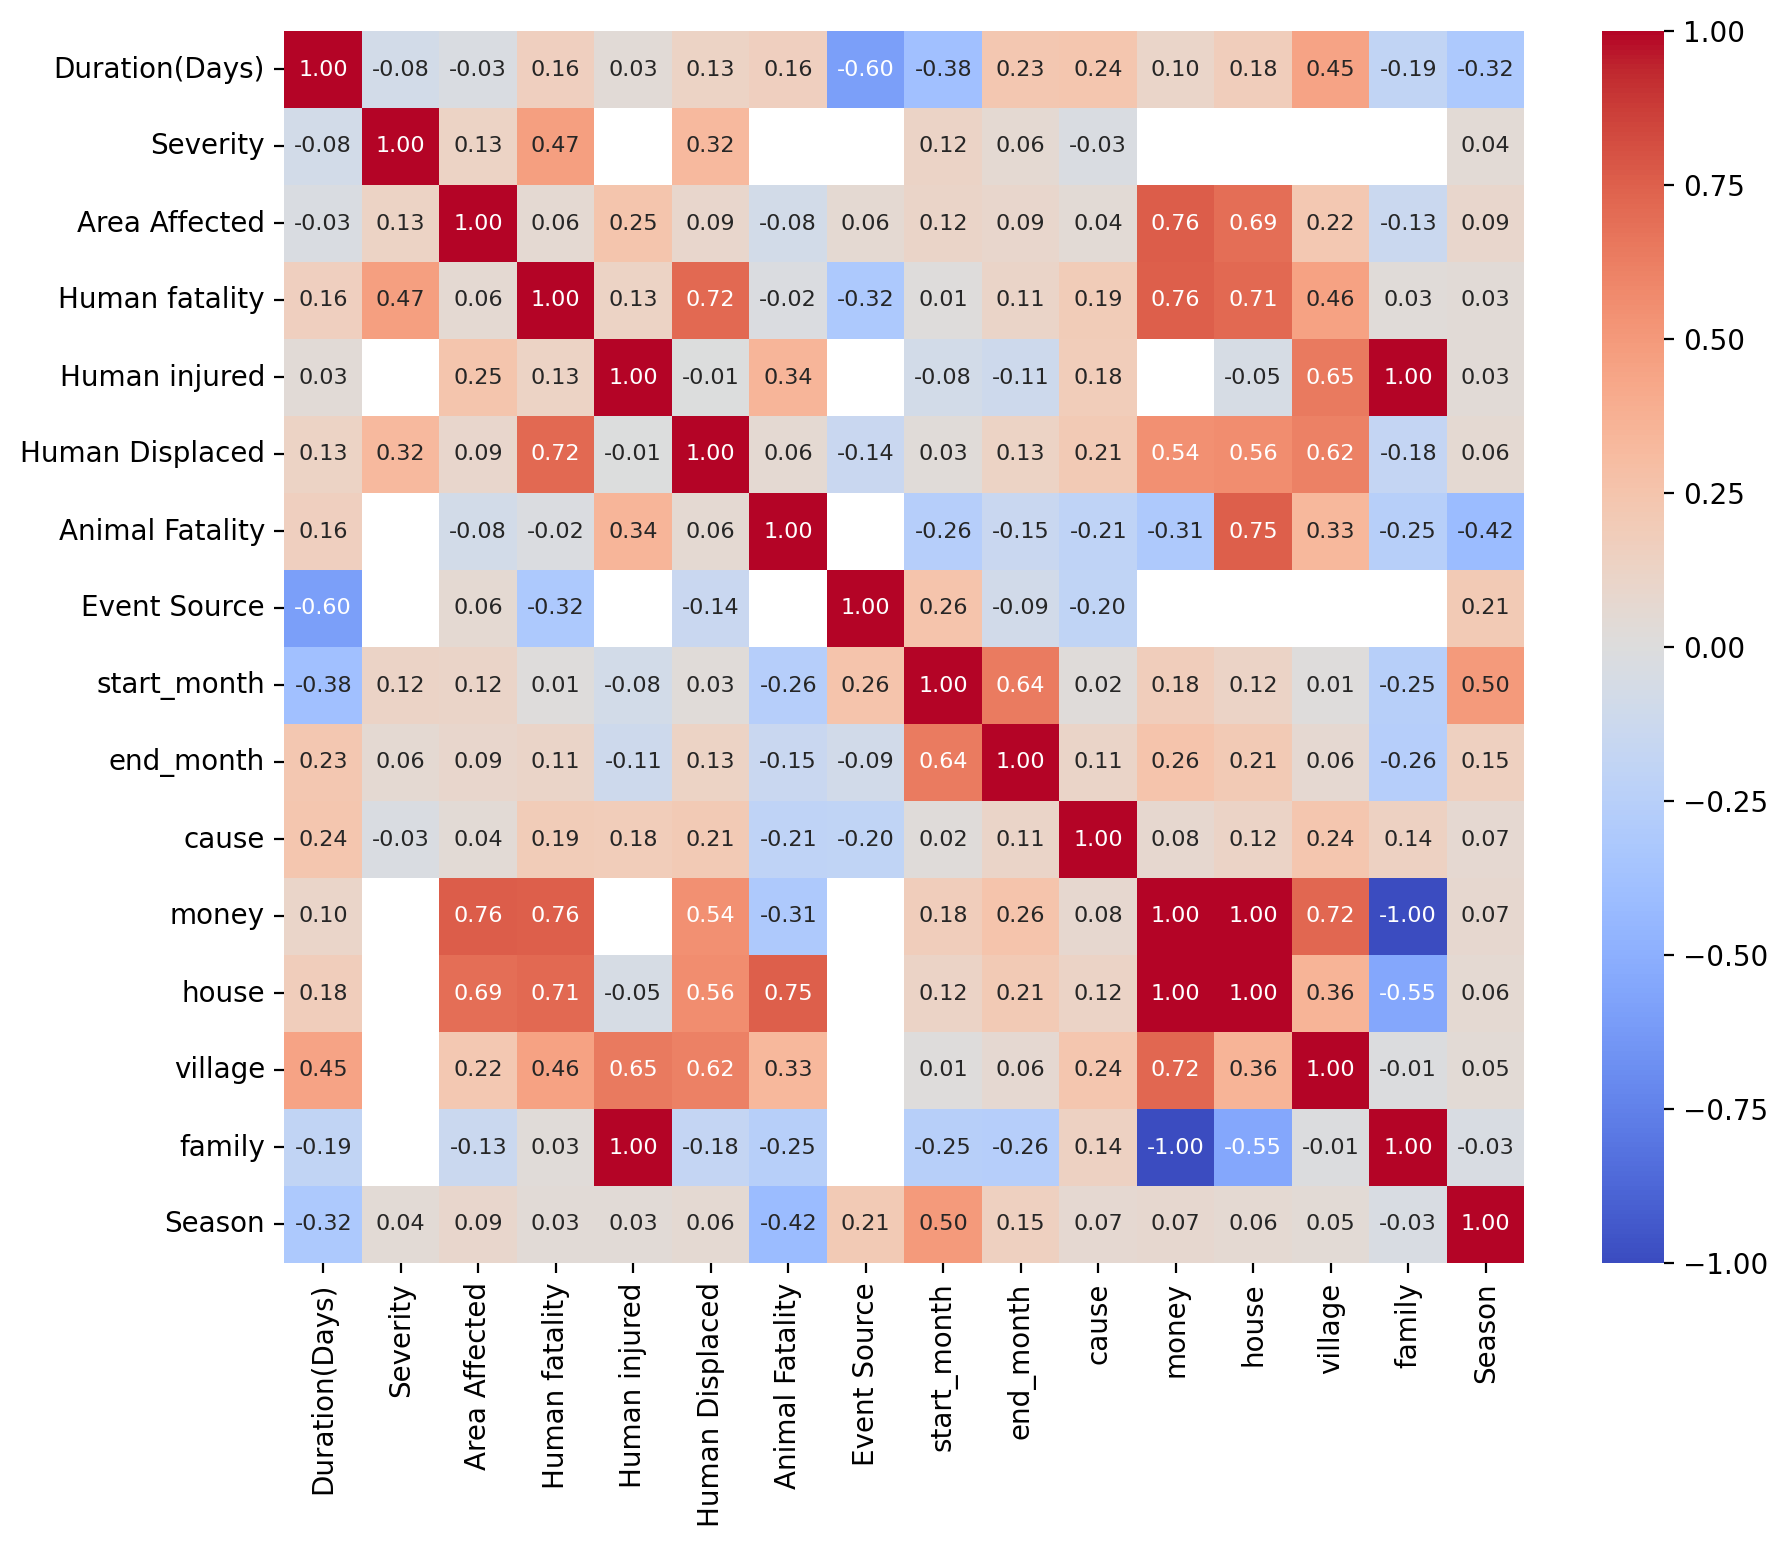

In [75]:
corr = df_disc.corr()

# Set figure size and DPI
plt.figure(figsize=(10, 8), dpi=200)

# Plot heatmap
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 8})

# Rotate y-axis labels for better readability (optional)
plt.yticks(rotation=0)

# Show plot
plt.show()

In [76]:
df_disc[~df_disc['money'].isnull()].info()

<class 'pandas.core.frame.DataFrame'>
Index: 34 entries, 393 to 2715
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Duration(Days)   34 non-null     float64
 1   Severity         0 non-null      float64
 2   Area Affected    14 non-null     float64
 3   Human fatality   25 non-null     float64
 4   Human injured    0 non-null      float64
 5   Human Displaced  34 non-null     float64
 6   Animal Fatality  7 non-null      float64
 7   Event Source     34 non-null     int64  
 8   start_month      34 non-null     int64  
 9   end_month        34 non-null     int64  
 10  cause            34 non-null     int64  
 11  money            34 non-null     float64
 12  house            16 non-null     float64
 13  village          14 non-null     float64
 14  family           2 non-null      float64
 15  Season           34 non-null     int64  
dtypes: float64(11), int64(5)
memory usage: 4.5 KB


In [77]:
df_disc2 = df_disc[['Duration(Days)','Area Affected','Human fatality','Human Displaced','Event Source','start_month','end_month','cause','village','Season']]

In [78]:
df_disc2.describe()

Duration(Days)  Area Affected  Human fatality  Human Displaced  \
count      456.000000   1.870000e+02      298.000000     4.560000e+02   
mean        15.778509   2.861381e+05       75.308725     1.010897e+06   
std         33.622750   1.300115e+06      291.257841     3.298374e+06   
min          1.000000   1.416401e+01        1.000000     1.000000e+00   
25%          1.000000   1.485647e+04        4.000000     3.000000e+03   
50%          7.000000   5.100000e+04       14.000000     6.585850e+04   
75%         14.000000   1.935838e+05       39.000000     4.398800e+05   
max        304.000000   1.601283e+07     3083.000000     4.000000e+07   

       Event Source  start_month   end_month       cause      village  \
count    456.000000   456.000000  456.000000  456.000000   160.000000   
mean       0.881579     6.997807    7.493421    9.350877   827.112500   
std        0.323461     1.957234    1.574509    1.998824  1411.229367   
min        0.000000     1.000000    2.000000    2.000000     5.000000   
25%        1.000000     6.000000    6.000000    8.000000    60.000000   
50%        1.000000     7.000000    7.000000   10.000000   200.000000   
75%        1.000000     8.000000    9.000000   11.000000  1000.000000   
max        1.000000    11.000000   11.000000   12.000000  8500.000000   

           Season  
count  456.000000  
mean     2.506579  
std      0.953859  
min      0.000000  
25%      3.000000  
50%      3.000000  
75%      3.000000  
max      3.000000

In [79]:
df_disc2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456 entries, 4 to 7031
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Duration(Days)   456 non-null    float64
 1   Area Affected    187 non-null    float64
 2   Human fatality   298 non-null    float64
 3   Human Displaced  456 non-null    float64
 4   Event Source     456 non-null    int64  
 5   start_month      456 non-null    int64  
 6   end_month        456 non-null    int64  
 7   cause            456 non-null    int64  
 8   village          160 non-null    float64
 9   Season           456 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 39.2 KB


In [80]:
df_disc2.isnull().sum()/4.56

Duration(Days)      0.000000
Area Affected      58.991228
Human fatality     34.649123
Human Displaced     0.000000
Event Source        0.000000
start_month         0.000000
end_month           0.000000
cause               0.000000
village            64.912281
Season              0.000000
dtype: float64

In [81]:
df_disc2

Duration(Days)  Area Affected  Human fatality  Human Displaced  \
Index                                                                   
4                66.0      507167.44           258.0        3040000.0   
6                18.0      231516.28            49.0         700000.0   
7               167.0       42285.99            76.0          43000.0   
8                23.0       70501.83            34.0        2000000.0   
11               23.0      626872.46           876.0           2000.0   
...               ...            ...             ...              ...   
5709              1.0            NaN             5.0              1.0   
5714              1.0            NaN             3.0              1.0   
5752              1.0            NaN             1.0              1.0   
6161              1.0            NaN            56.0              5.0   
7031              1.0            NaN             8.0             11.0   

       Event Source  start_month  end_month  cause  village  Season  
Index                                                                
4                 0            6          8     12      NaN       3  
6                 0            9         10      8      NaN       3  
7                 0            5         11     12      NaN       1  
8                 0            6          7      8      NaN       3  
11                0            8          9     12      NaN       3  
...             ...          ...        ...    ...      ...     ...  
5709              1            6          6      8      NaN       3  
5714              1            6          6      8      NaN       3  
5752              1            7          7      8      NaN       3  
6161              1            6          6      5      NaN       3  
7031              1            5          5      5      NaN       1  

[456 rows x 10 columns]

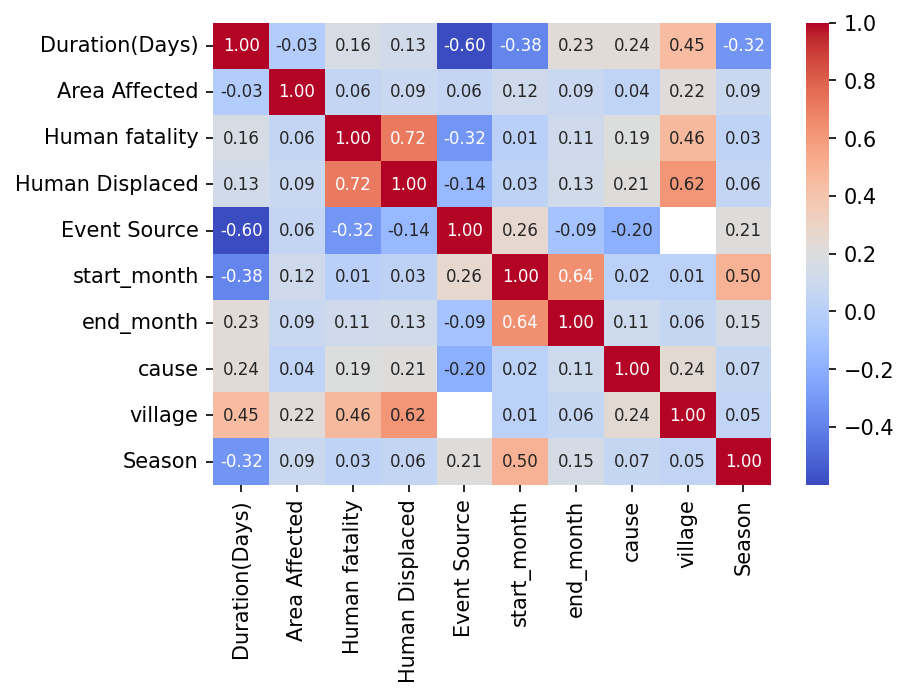

In [82]:
corr = df_disc2.corr()

# Set figure size and DPI
plt.figure(figsize=(6, 4), dpi=150)

# Plot heatmap
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 8})

# Rotate y-axis labels for better readability (optional)
plt.yticks(rotation=0)

# Show plot
plt.show()

In [120]:
# from sklearn.preprocessing import RobustScaler

# columns_to_scale = df_disc2.drop(columns='Human Displaced').columns
# human_displaced_column = df_disc2[['Human Displaced']]
# scaler = RobustScaler()

# df_disc2_scaled = scaler.fit_transform(df_disc2[columns_to_scale])
# df_scaled = pd.DataFrame(df_disc2_scaled, columns=columns_to_scale, index=df_disc2.index)
# X = df_scaled.copy()
# y = human_displaced_column
# df_scaled['Human Displaced'] = human_displaced_column


In [83]:
# X
df_disc2

Duration(Days)  Area Affected  Human fatality  Human Displaced  \
Index                                                                   
4                66.0      507167.44           258.0        3040000.0   
6                18.0      231516.28            49.0         700000.0   
7               167.0       42285.99            76.0          43000.0   
8                23.0       70501.83            34.0        2000000.0   
11               23.0      626872.46           876.0           2000.0   
...               ...            ...             ...              ...   
5709              1.0            NaN             5.0              1.0   
5714              1.0            NaN             3.0              1.0   
5752              1.0            NaN             1.0              1.0   
6161              1.0            NaN            56.0              5.0   
7031              1.0            NaN             8.0             11.0   

       Event Source  start_month  end_month  cause  village  Season  
Index                                                                
4                 0            6          8     12      NaN       3  
6                 0            9         10      8      NaN       3  
7                 0            5         11     12      NaN       1  
8                 0            6          7      8      NaN       3  
11                0            8          9     12      NaN       3  
...             ...          ...        ...    ...      ...     ...  
5709              1            6          6      8      NaN       3  
5714              1            6          6      8      NaN       3  
5752              1            7          7      8      NaN       3  
6161              1            6          6      5      NaN       3  
7031              1            5          5      5      NaN       1  

[456 rows x 10 columns]

In [84]:
# from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer

# # Instantiate the RobustScaler
# scaler = RobustScaler()

# # Fit and transform the data using RobustScaler
# df_disc2_scaled = scaler.fit_transform(df_disc2)
# df_disc2_scaled = pd.DataFrame(df_disc2_scaled,columns = df_disc2.columns)

# # Instantiate the KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Apply imputation
after_imputation = imputer.fit_transform(df_disc2)
# after_imputation = imputer.fit_transform(X)

In [115]:
# df_scaled

Duration(Days)  Area Affected  Human fatality  Event Source  \
Index                                                                
4            4.538462       2.552309        6.971429          -1.0   
6            0.846154       1.010009        1.000000          -1.0   
7           12.307692      -0.048756        1.771429          -1.0   
8            1.230769       0.109115        0.571429          -1.0   
11           1.230769       3.222073       24.628571          -1.0   
...               ...            ...             ...           ...   
5709        -0.461538            NaN       -0.257143           0.0   
5714        -0.461538            NaN       -0.314286           0.0   
5752        -0.461538            NaN       -0.371429           0.0   
6161        -0.461538            NaN        1.200000           0.0   
7031        -0.461538            NaN       -0.171429           0.0   

       start_month  end_month     cause  village  Season  Human Displaced  
Index                                                                      
4             -0.5   0.333333  0.666667      NaN     0.0        3040000.0  
6              1.0   1.000000 -0.666667      NaN     0.0         700000.0  
7             -1.0   1.333333  0.666667      NaN    -2.0          43000.0  
8             -0.5   0.000000 -0.666667      NaN     0.0        2000000.0  
11             0.5   0.666667  0.666667      NaN     0.0           2000.0  
...            ...        ...       ...      ...     ...              ...  
5709          -0.5  -0.333333 -0.666667      NaN     0.0              1.0  
5714          -0.5  -0.333333 -0.666667      NaN     0.0              1.0  
5752           0.0   0.000000 -0.666667      NaN     0.0              1.0  
6161          -0.5  -0.333333 -1.666667      NaN     0.0              5.0  
7031          -1.0  -0.666667 -1.666667      NaN    -2.0             11.0  

[456 rows x 10 columns]

In [98]:
# corr = df_disc2_scaled.corr()

# # Set figure size and DPI
# plt.figure(figsize=(6, 4), dpi=150)

# # Plot heatmap
# sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 8})

# # Rotate y-axis labels for better readability (optional)
# plt.yticks(rotation=0)

# # Show plot
# plt.show()

In [86]:
# df_disc2_scaled
df_disc2

Duration(Days)  Area Affected  Human fatality  Human Displaced  \
Index                                                                   
4                66.0      507167.44           258.0        3040000.0   
6                18.0      231516.28            49.0         700000.0   
7               167.0       42285.99            76.0          43000.0   
8                23.0       70501.83            34.0        2000000.0   
11               23.0      626872.46           876.0           2000.0   
...               ...            ...             ...              ...   
5709              1.0            NaN             5.0              1.0   
5714              1.0            NaN             3.0              1.0   
5752              1.0            NaN             1.0              1.0   
6161              1.0            NaN            56.0              5.0   
7031              1.0            NaN             8.0             11.0   

       Event Source  start_month  end_month  cause  village  Season  
Index                                                                
4                 0            6          8     12      NaN       3  
6                 0            9         10      8      NaN       3  
7                 0            5         11     12      NaN       1  
8                 0            6          7      8      NaN       3  
11                0            8          9     12      NaN       3  
...             ...          ...        ...    ...      ...     ...  
5709              1            6          6      8      NaN       3  
5714              1            6          6      8      NaN       3  
5752              1            7          7      8      NaN       3  
6161              1            6          6      5      NaN       3  
7031              1            5          5      5      NaN       1  

[456 rows x 10 columns]

In [85]:
after_imputation

array([[6.6000000e+01, 5.0716744e+05, 2.5800000e+02, ..., 1.2000000e+01,
        1.9318000e+03, 3.0000000e+00],
       [1.8000000e+01, 2.3151628e+05, 4.9000000e+01, ..., 8.0000000e+00,
        7.7280000e+02, 3.0000000e+00],
       [1.6700000e+02, 4.2285990e+04, 7.6000000e+01, ..., 1.2000000e+01,
        7.0000000e+01, 1.0000000e+00],
       ...,
       [1.0000000e+00, 2.1653450e+04, 1.0000000e+00, ..., 8.0000000e+00,
        3.1400000e+01, 3.0000000e+00],
       [1.0000000e+00, 2.1653450e+04, 5.6000000e+01, ..., 5.0000000e+00,
        3.1400000e+01, 3.0000000e+00],
       [1.0000000e+00, 2.1653450e+04, 8.0000000e+00, ..., 5.0000000e+00,
        3.1400000e+01, 1.0000000e+00]])

In [87]:
df_disc2_imp = pd.DataFrame(after_imputation, columns = df_disc2.columns)
df_disc2_imp

Duration(Days)  Area Affected  Human fatality  Human Displaced  \
0              66.0  507167.440000           258.0        3040000.0   
1              18.0  231516.280000            49.0         700000.0   
2             167.0   42285.990000            76.0          43000.0   
3              23.0   70501.830000            34.0        2000000.0   
4              23.0  626872.460000           876.0           2000.0   
..              ...            ...             ...              ...   
451             1.0   21653.450038             5.0              1.0   
452             1.0   21653.450038             3.0              1.0   
453             1.0   21653.450038             1.0              1.0   
454             1.0   21653.450038            56.0              5.0   
455             1.0   21653.450038             8.0             11.0   

     Event Source  start_month  end_month  cause  village  Season  
0             0.0          6.0        8.0   12.0   1931.8     3.0  
1             0.0          9.0       10.0    8.0    772.8     3.0  
2             0.0          5.0       11.0   12.0     70.0     1.0  
3             0.0          6.0        7.0    8.0   1339.4     3.0  
4             0.0          8.0        9.0   12.0   1658.4     3.0  
..            ...          ...        ...    ...      ...     ...  
451           1.0          6.0        6.0    8.0     31.4     3.0  
452           1.0          6.0        6.0    8.0     31.4     3.0  
453           1.0          7.0        7.0    8.0     31.4     3.0  
454           1.0          6.0        6.0    5.0     31.4     3.0  
455           1.0          5.0        5.0    5.0     31.4     1.0  

[456 rows x 10 columns]

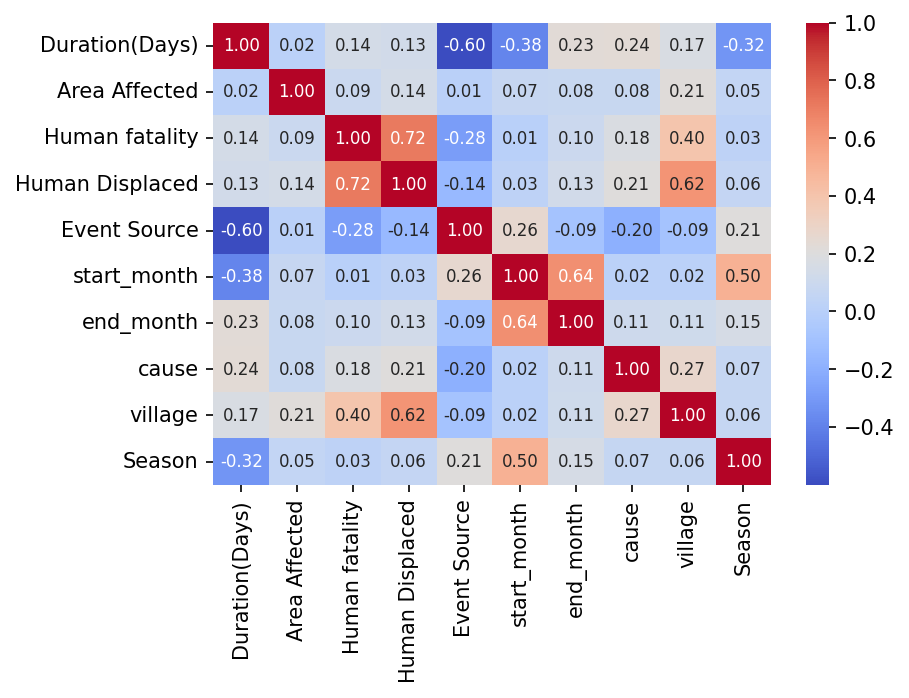

In [88]:
corr = df_disc2_imp.corr()

# Set figure size and DPI
plt.figure(figsize=(6, 4), dpi=150)

# Plot heatmap
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 8})

# Rotate y-axis labels for better readability (optional)
plt.yticks(rotation=0)

# Show plot
plt.show()

In [89]:
df_disc2_imp.describe()

Duration(Days)  Area Affected  Human fatality  Human Displaced  \
count      456.000000   4.560000e+02      456.000000     4.560000e+02   
mean        15.778509   1.776339e+05       58.603509     1.010897e+06   
std         33.622750   8.485018e+05      237.448055     3.298374e+06   
min          1.000000   1.416401e+01        1.000000     1.000000e+00   
25%          1.000000   2.165345e+04        6.000000     3.000000e+03   
50%          7.000000   4.099004e+04       14.200000     6.585850e+04   
75%         14.000000   1.320560e+05       35.000000     4.398800e+05   
max        304.000000   1.601283e+07     3083.000000     4.000000e+07   

       Event Source  start_month   end_month       cause      village  \
count    456.000000   456.000000  456.000000  456.000000   456.000000   
mean       0.881579     6.997807    7.493421    9.350877   810.935088   
std        0.323461     1.957234    1.574509    1.998824  1171.757167   
min        0.000000     1.000000    2.000000    2.000000     5.000000   
25%        1.000000     6.000000    6.000000    8.000000    48.000000   
50%        1.000000     7.000000    7.000000   10.000000   281.600000   
75%        1.000000     8.000000    9.000000   11.000000  1344.850000   
max        1.000000    11.000000   11.000000   12.000000  8500.000000   

           Season  
count  456.000000  
mean     2.506579  
std      0.953859  
min      0.000000  
25%      3.000000  
50%      3.000000  
75%      3.000000  
max      3.000000

In [98]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(df_disc2_imp.drop('Human Displaced',axis =1),df_disc2_imp['Human Displaced'])

In [99]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [124]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train,y_train)
predictions = lr.predict(x_test)
print("MAE: ", mean_absolute_error(y_test,predictions))
print("MSE: ", mean_squared_error(y_test,predictions))
print("r2 score: ",r2_score(y_test,predictions))

MAE:  946866.3849421184
MSE:  3639127052328.4033
r2 score:  0.5216914411250584


In [101]:
y_test

166        7000.0
423      360000.0
379      735829.0
133       55000.0
282    21770000.0
          ...    
160      300000.0
428     1490000.0
328           5.0
198        8000.0
444           3.0
Name: Human Displaced, Length: 114, dtype: float64

In [102]:
predictions

array([-4.63050939e+05,  1.24652464e+06,  1.42747791e+06,  9.64376325e+04,
        1.49687626e+07,  1.30633142e+06,  1.07679910e+06, -5.86587344e+05,
        1.54203152e+06,  2.78209480e+06,  1.44795271e+06, -6.45061735e+04,
        9.16077753e+04,  1.88286872e+06,  1.14329153e+06, -1.17251316e+05,
        2.41949826e+04, -6.48296544e+05, -2.85188113e+05, -4.94212866e+04,
       -2.15920602e+04, -1.74868598e+05,  3.61681267e+06, -1.60522827e+05,
       -5.34733346e+04, -8.76752169e+04, -2.12615318e+05,  1.87190183e+04,
        8.86375389e+06,  3.26880529e+05,  2.23345933e+05,  1.01051384e+06,
        2.62714464e+06,  1.32070053e+05, -5.33683892e+05,  2.39122753e+06,
        6.68175163e+05, -3.53398198e+05,  2.04486855e+05,  2.62921454e+06,
       -6.38004127e+05,  8.78814795e+05,  1.46890471e+05, -2.80500336e+05,
        2.92419493e+06,  1.86547900e+06, -5.22235298e+05,  5.38700996e+05,
        5.72557309e+05, -3.10873838e+05,  5.75734595e+05,  2.10985973e+06,
        1.73304509e+05, -

In [126]:
df_disc3 = df_new[['Duration(Days)','Human fatality','Human Displaced','Event Source','start_month','end_month','cause','Season']]

In [141]:
df_disc3=df_disc3[~df_disc3['Human Displaced'].isnull()]

In [142]:
df_disc3

Duration(Days)  Human fatality  Human Displaced  Event Source  \
Index                                                                  
4                66.0           258.0        3040000.0             0   
6                18.0            49.0         700000.0             0   
7               167.0            76.0          43000.0             0   
8                23.0            34.0        2000000.0             0   
11               23.0           876.0           2000.0             0   
...               ...             ...              ...           ...   
5709              1.0             5.0              1.0             1   
5714              1.0             3.0              1.0             1   
5752              1.0             1.0              1.0             1   
6161              1.0            56.0              5.0             1   
7031              1.0             8.0             11.0             1   

       start_month  end_month  cause  Season  
Index                                         
4                6          8     12       3  
6                9         10      8       3  
7                5         11     12       1  
8                6          7      8       3  
11               8          9     12       3  
...            ...        ...    ...     ...  
5709             6          6      8       3  
5714             6          6      8       3  
5752             7          7      8       3  
6161             6          6      5       3  
7031             5          5      5       1  

[298 rows x 8 columns]

In [143]:
imputer = KNNImputer(n_neighbors=5)

# Apply imputation
after_imputation = imputer.fit_transform(df_disc3)

In [144]:
df_disc3_imp = pd.DataFrame(after_imputation, columns = df_disc3.columns)
df_disc3_imp

Duration(Days)  Human fatality  Human Displaced  Event Source  \
0              66.0           258.0        3040000.0           0.0   
1              18.0            49.0         700000.0           0.0   
2             167.0            76.0          43000.0           0.0   
3              23.0            34.0        2000000.0           0.0   
4              23.0           876.0           2000.0           0.0   
..              ...             ...              ...           ...   
293             1.0             5.0              1.0           1.0   
294             1.0             3.0              1.0           1.0   
295             1.0             1.0              1.0           1.0   
296             1.0            56.0              5.0           1.0   
297             1.0             8.0             11.0           1.0   

     start_month  end_month  cause  Season  
0            6.0        8.0   12.0     3.0  
1            9.0       10.0    8.0     3.0  
2            5.0       11.0   12.0     1.0  
3            6.0        7.0    8.0     3.0  
4            8.0        9.0   12.0     3.0  
..           ...        ...    ...     ...  
293          6.0        6.0    8.0     3.0  
294          6.0        6.0    8.0     3.0  
295          7.0        7.0    8.0     3.0  
296          6.0        6.0    5.0     3.0  
297          5.0        5.0    5.0     1.0  

[298 rows x 8 columns]

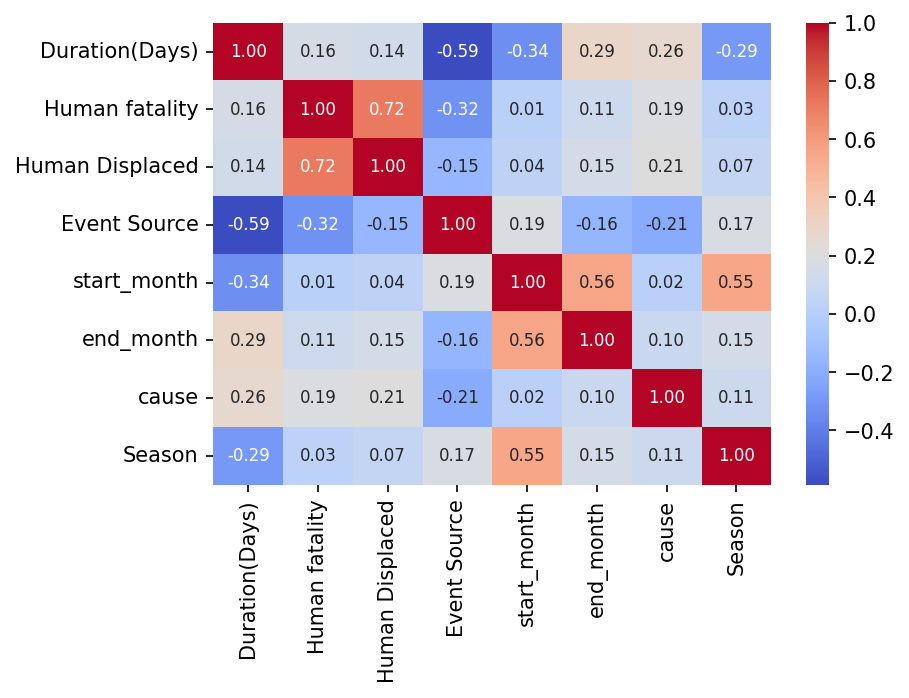

In [145]:
corr = df_disc3_imp.corr()

# Set figure size and DPI
plt.figure(figsize=(6, 4), dpi=150)

# Plot heatmap
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', annot_kws={"size": 8})

# Rotate y-axis labels for better readability (optional)
plt.yticks(rotation=0)

# Show plot
plt.show()

In [146]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(df_disc3_imp.drop('Human Displaced',axis =1),df_disc3['Human Displaced'])

In [147]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train,y_train)
predictions = lr.predict(x_test)
print("MAE: ", mean_absolute_error(y_test,predictions))
print("MSE: ", mean_squared_error(y_test,predictions))
print("r2 score: ",r2_score(y_test,predictions))

MAE:  1853031.2190495292
MSE:  11261735248924.457
r2 score:  0.5884796017184323


Next approcah : try incorporating state and district column as well . Label encoding tru karo , one hot encoding . Population and gdp factor if possible try karo laane ka

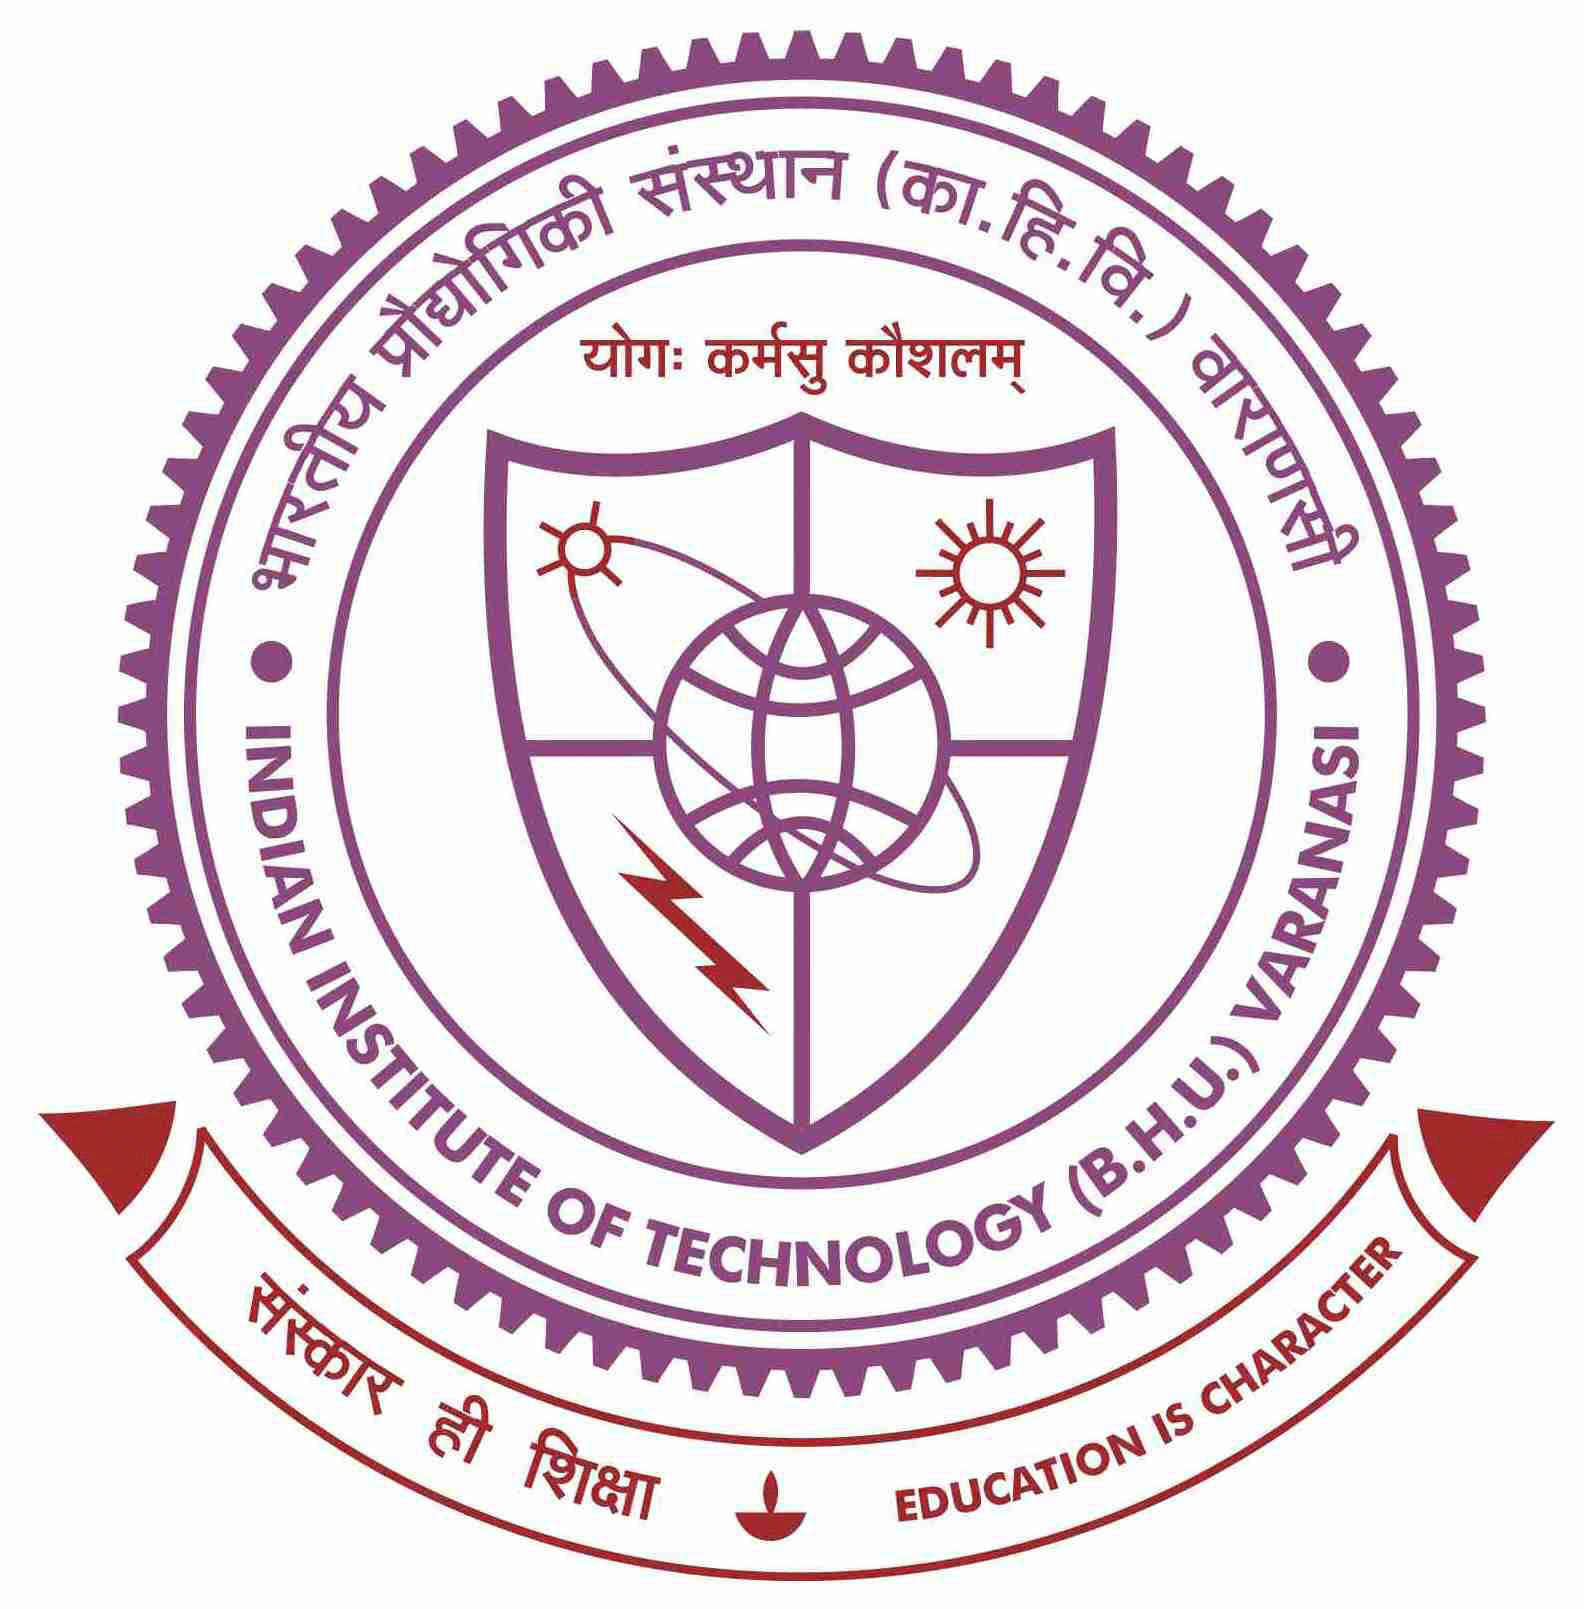

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_loc = pd.read_csv("/kaggle/input/ugp-data-with-address/Fetched_Address (1).csv")
df_loc.rename(columns = {'Unnamed: 0':'Index'}, inplace = True)
df_loc.set_index("Index",inplace= True)
df_loc.head()

Duration(Days)  Latitude  Longitude  Severity  Area Affected  \
Index                                                                 
4                66.0   25.6339    84.0726       1.0      507167.44   
6                18.0   23.6547    89.4296       1.0      231516.28   
7               167.0   26.4813    92.0622       1.0       42285.99   
8                23.0   26.9880    92.9260       1.0       70501.83   
11               23.0   26.5037    86.5429       1.0      626872.46   

       Human fatality  Human injured  Human Displaced  Animal Fatality  \
Index                                                                    
4               258.0            NaN        3040000.0              NaN   
6                49.0            NaN         700000.0              NaN   
7                76.0            NaN          43000.0              NaN   
8                34.0            NaN        2000000.0              NaN   
11              876.0            NaN           2000.0              NaN   

      Description of Casualties/injured  ... end_month      cause  money  \
Index                                    ...                               
4                                   NaN  ...         8  monsoonal    0.0   
6                                   NaN  ...        10      heavy    0.0   
7                                   NaN  ...        11  monsoonal    0.0   
8                                   NaN  ...         7      heavy    0.0   
11                                  NaN  ...         9  monsoonal    0.0   

       house  village  family       District              State  Start Date  \
Index                                                                         
4        0.0      0.0     0.0          Buxar              Bihar  15-06-1986   
6        0.0      0.0     0.0         Magura    Khulna Division  22-09-1986   
7        0.0      0.0     0.0        Darrang              Assam  23-05-1988   
8        0.0      0.0     0.0  Pakke-Kessang  Arunachal Pradesh  21-06-1988   
11       0.0      0.0     0.0      Madhubani              Bihar  23-08-1988   

         End Date  
Index              
4      20-08-1986  
6      10-10-1986  
7      06-11-1988  
8      14-07-1988  
11     15-09-1988  

[5 rows x 25 columns]

In [3]:
df_loc['State'] = df_loc['State'].str.strip().str.lower()
df_loc['District'] = df_loc['District'].str.strip().str.lower()

In [4]:
df_loc = df_loc.replace([0],[np.nan])

In [5]:
df_loc

Duration(Days)   Latitude  Longitude  Severity  Area Affected  \
Index                                                                  
4                66.0  25.633900  84.072600       1.0      507167.44   
6                18.0  23.654700  89.429600       1.0      231516.28   
7               167.0  26.481300  92.062200       1.0       42285.99   
8                23.0  26.988000  92.926000       1.0       70501.83   
11               23.0  26.503700  86.542900       1.0      626872.46   
...               ...        ...        ...       ...            ...   
7070              1.0  27.128016  88.272793       NaN            NaN   
7127              1.0  26.485157  89.524693       NaN            NaN   
7157              1.0  23.385892  92.930599       NaN            NaN   
7160              1.0  27.418517  88.180834       NaN            NaN   
7161              1.0  27.037755  88.263176       NaN            NaN   

       Human fatality  Human injured  Human Displaced  Animal Fatality  \
Index                                                                    
4               258.0            NaN        3040000.0              NaN   
6                49.0            NaN         700000.0              NaN   
7                76.0            NaN          43000.0              NaN   
8                34.0            NaN        2000000.0              NaN   
11              876.0            NaN           2000.0              NaN   
...               ...            ...              ...              ...   
7070              1.0            NaN              NaN              NaN   
7127              2.0            NaN              NaN              NaN   
7157              1.0            1.0              NaN              NaN   
7160              1.0            NaN              NaN              NaN   
7161              1.0            NaN              NaN              NaN   

      Description of Casualties/injured  ... end_month      cause  money  \
Index                                    ...                               
4                                   NaN  ...         8  monsoonal    NaN   
6                                   NaN  ...        10      heavy    NaN   
7                                   NaN  ...        11  monsoonal    NaN   
8                                   NaN  ...         7      heavy    NaN   
11                                  NaN  ...         9  monsoonal    NaN   
...                                 ...  ...       ...        ...    ...   
7070                                NaN  ...         6      other    NaN   
7127                                NaN  ...         7      heavy    NaN   
7157                                NaN  ...         9  landslide    NaN   
7160                                NaN  ...         8  landslide    NaN   
7161                                NaN  ...         8  landslide    NaN   

       house  village  family       District              State  Start Date  \
Index                                                                         
4        NaN      NaN     NaN          buxar              bihar  15-06-1986   
6        NaN      NaN     NaN         magura    khulna division  22-09-1986   
7        NaN      NaN     NaN        darrang              assam  23-05-1988   
8        NaN      NaN     NaN  pakke-kessang  arunachal pradesh  21-06-1988   
11       NaN      NaN     NaN      madhubani              bihar  23-08-1988   
...      ...      ...     ...            ...                ...         ...   
7070     NaN      NaN     NaN    west sikkim             sikkim  15-06-2023   
7127     NaN      NaN     NaN     alipurduar        west bengal  13-07-2023   
7157     NaN      NaN     NaN       serchhip            mizoram  10-09-2023   
7160     NaN      NaN     NaN      gyalshing             sikkim  25-08-2023   
7161     NaN      NaN     NaN     darjeeling        west bengal  25-08-2023   

         End Date  
Index              
4      20-08-1986  
6      10-10-1986  
7      06-

In [6]:
df_loc[~df_loc['Human fatality'].isnull()]['Human fatality']

Index
4       258.0
6        49.0
7        76.0
8        34.0
11      876.0
        ...  
7070      1.0
7127      2.0
7157      1.0
7160      1.0
7161      1.0
Name: Human fatality, Length: 861, dtype: float64

In [7]:
import numpy as np
import pandas as pd
import folium
from folium.plugins import HeatMap
from IPython.display import display

# List of columns to iterate through
cols = ['Duration(Days)', 'Severity', 'Area Affected', 'Human fatality', 'Human injured', 'Human Displaced', 'Animal Fatality']

for col in cols:
    print("\n")
    print(col)
    df_clean = df_loc[~df_loc[col].isnull()]
    q1, q3 = np.percentile(df_clean[col], [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

    data = {
        'Latitude': df_clean['Latitude'],
        'Longitude': df_clean['Longitude'],
        col: df_clean[col]
    }
    df = pd.DataFrame(data)

    # Create a folium map centered around the mean latitude and longitude
    center_lat = df['Latitude'].mean()
    center_lon = df['Longitude'].mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

    # Convert DataFrame to list of lists (latitude, longitude, weight)
    heat_data = [[row['Latitude'], row['Longitude'], row[col]] for index, row in df.iterrows()]

    # Plot heatmap
    HeatMap(heat_data, radius=15, blur=20).add_to(m)
    
    # Display the map
    display(m)




Duration(Days)




Severity




Area Affected




Human fatality




Human injured




Human Displaced




Animal Fatality


In [9]:
assam = pd.read_excel('/kaggle/input/assam-pop/pop_data.xlsx')
assam.head()

Unnamed: 0    District        Town  Population
0         1.0  KOKRAJHAR   Gossaigaon        9068
1         NaN  KOKRAJHAR     Padmabil        6874
2         NaN  KOKRAJHAR    Kokrajhar       34136
3         NaN  KOKRAJHAR     Salakati        4863
4         2.0     DHUBRI    Golokganj        8244

In [10]:
assam.drop('Unnamed: 0',axis =1, inplace = True)

In [11]:
assam['District'] = assam['District'].str.title()

In [12]:
# assam['address'] = assam['Town']+ ', '+ assam['District']+ ", Assam, India"

In [13]:
assam

District                   Town  Population
0    Kokrajhar              Gossaigaon        9068
1    Kokrajhar                Padmabil        6874
2    Kokrajhar               Kokrajhar       34136
3    Kokrajhar                Salakati        4863
4       Dhubri               Golokganj        8244
..          ...                    ...         ...
238     Darrang       Gerimari Chapori       11004
239     Darrang             Kharupatia       18501
240    Udalguri  Kalaigaon Town (Part)        5112
241    Udalguri                 Tangla       17183
242    Udalguri               Udalguri       15279

[243 rows x 3 columns]

In [15]:
import geopandas as gpd
import folium
from folium import Marker
from geopy.geocoders import Nominatim

If geolocator is able to fetch the coordinates of Town,District,State,Country then well and good but if not then continue with District, State, Country.

In [16]:
# assam.drop('address', axis = 1)
assam['latitude'] = 0.0
assam['longitude'] = 0.0

In [23]:
geolocator = Nominatim(user_agent="kaggle_learn")

In [24]:
ind = 0 
address = assam.loc[ind,'Town']+ ', '+ assam.loc[ind,'District']+ ", Assam, India"
point = geolocator.geocode(address).point
(point.latitude,point.longitude)

(26.5406517, 89.98104807950088)

In [25]:
Town = 0
District = 0
Nothing = []
for ind in assam.index:
    print(ind)
    execution = True
    try:
        address = assam.loc[ind,'Town']+ ', '+ assam.loc[ind,'District']+ ", Assam, India"
        point = geolocator.geocode(address).point
        execution = False
        Town=Town + 1
        assam.loc[ind,'latitude'] = point.latitude
        assam.loc[ind,'longitude'] = point.longitude
    except:
        pass
    if execution:
        try:
            address = assam.loc[ind,'District']+ ", Assam, India"
            point = geolocator.geocode(address).point
            execution = False
            District = District +1
            assam.loc[ind,'latitude'] = point.latitude
            assam.loc[ind,'longitude'] = point.longitude
        except:
            pass
    if execution:
        Nothing.append(ind)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242


In [26]:
assam

District                   Town  Population   latitude  longitude
0    Kokrajhar              Gossaigaon        9068  26.540652  89.981048
1    Kokrajhar                Padmabil        6874  26.468172  90.424347
2    Kokrajhar               Kokrajhar       34136  26.400375  90.271041
3    Kokrajhar                Salakati        4863  26.442509  90.353796
4       Dhubri               Golokganj        8244  26.181783  89.968769
..          ...                    ...         ...        ...        ...
238     Darrang       Gerimari Chapori       11004  26.750000  92.500000
239     Darrang             Kharupatia       18501  26.750000  92.500000
240    Udalguri  Kalaigaon Town (Part)        5112  26.750381  92.097724
241    Udalguri                 Tangla       17183  26.657191  91.905208
242    Udalguri               Udalguri       15279  26.744596  92.097183

[243 rows x 5 columns]

In [27]:
Town

93

In [28]:
District

150

In [29]:
Nothing

[]

In [30]:
assam.to_csv('final_assam.csv')

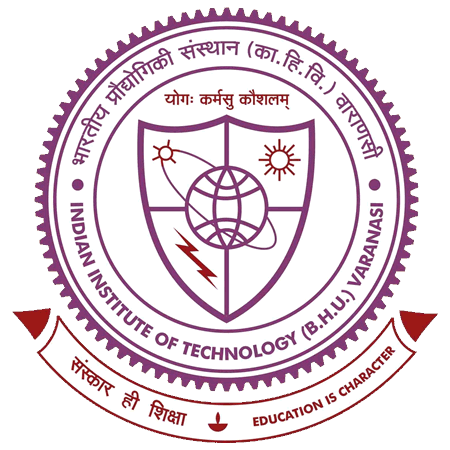

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [136]:
import geopandas as gpd
from folium import Marker
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap
from IPython.display import display

In [137]:
assam = pd.read_csv(r"/kaggle/input/assam-fetched-coordinates/final_assam.csv")
assam.drop('Unnamed: 0',axis=1, inplace = True)
assam.head()

District        Town  Population   latitude  longitude
0  Kokrajhar   Gossaigaon        9068  26.540652  89.981048
1  Kokrajhar     Padmabil        6874  26.468172  90.424347
2  Kokrajhar    Kokrajhar       34136  26.400375  90.271041
3  Kokrajhar     Salakati        4863  26.442509  90.353796
4     Dhubri    Golokganj        8244  26.181783  89.968769

In [138]:
col = 'Population'
data = {
    'Latitude': assam['latitude'],
    'Longitude': assam['longitude'],
    col: assam['Population']
}
df = pd.DataFrame(data)

# Create a folium map centered around the mean latitude and longitude
center_lat = df['Latitude'].mean()
center_lon = df['Longitude'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# Convert DataFrame to list of lists (latitude, longitude, weight)
heat_data = [[row['Latitude'], row['Longitude'], row[col]] for index, row in df.iterrows()]

# Plot heatmap
HeatMap(heat_data, radius=15, blur=20).add_to(m)
display(m)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

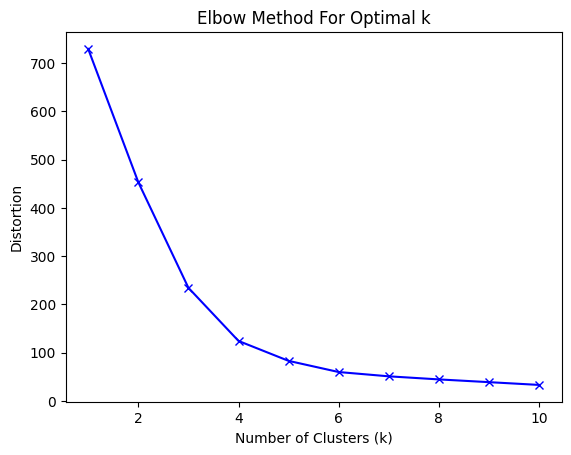

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


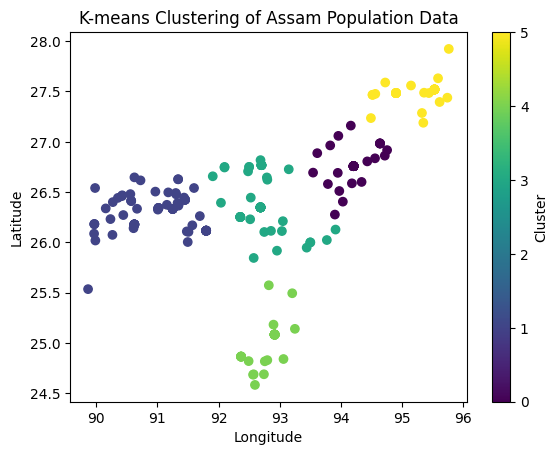

In [139]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select features for clustering
X = assam[['latitude', 'longitude', 'Population']]

# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Determine the optimal value of k using the elbow method
distortions = []
K = range(1, 11)
for k in K:
    kmeans_model = KMeans(n_clusters=k)
    kmeans_model.fit(X_normalized)
    distortions.append(kmeans_model.inertia_)

# Plot the elbow curve to find the optimal number of clusters
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal k')
plt.show()

# Based on the elbow curve, choose the optimal number of clusters (k)
optimal_k = 6# Adjust this based on the elbow curve

# Apply K-means clustering with the optimal value of k
kmeans = KMeans(n_clusters=optimal_k)
clusters = kmeans.fit_predict(X_normalized)
centroids = kmeans.cluster_centers_

# Visualize the clustering results
plt.scatter(assam['longitude'], assam['latitude'], c=clusters, cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-means Clustering of Assam Population Data')
plt.colorbar(label='Cluster')
plt.show()


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


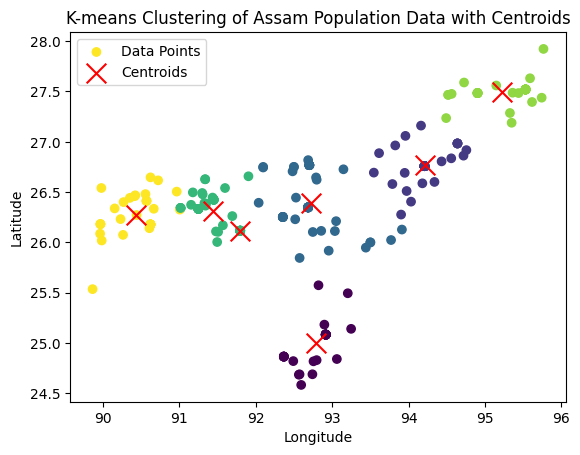

In [199]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select features for clustering
X = assam[['latitude', 'longitude', 'Population']]

# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Based on the elbow curve, choose the optimal number of clusters (k)
optimal_k = 7  # Adjust this based on the elbow curve

# Apply K-means clustering with the optimal value of k
kmeans = KMeans(n_clusters=optimal_k)
clusters = kmeans.fit_predict(X_normalized)

# Get cluster centroids
centroids = kmeans.cluster_centers_
centroids_original_scale = scaler.inverse_transform(centroids)

# Visualize the clustering results with centroids
plt.scatter(assam['longitude'], assam['latitude'], c=clusters, cmap='viridis', label='Data Points')
plt.scatter(centroids_original_scale[:, 1], centroids_original_scale[:, 0], marker='x', s=200, c='red', label='Centroids')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-means Clustering of Assam Population Data with Centroids')
plt.legend()
plt.show()


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


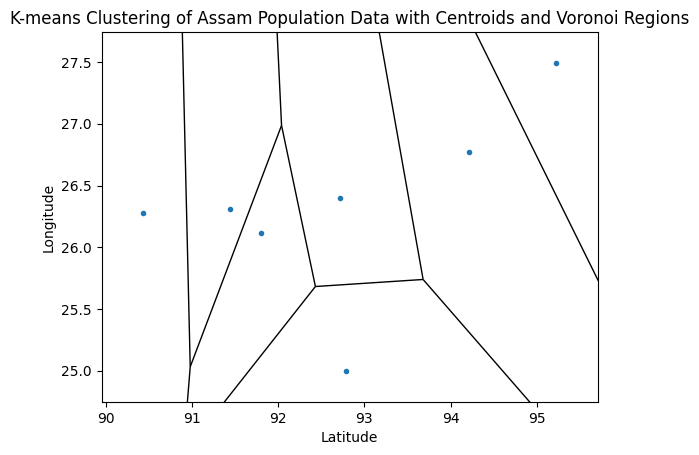

In [198]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

# Select features for clustering
X = assam[['latitude', 'longitude', 'Population']]

# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Based on the elbow curve, choose the optimal number of clusters (k)
optimal_k = 7  # Adjust this based on the elbow curve

# Apply K-means clustering with the optimal value of k
kmeans = KMeans(n_clusters=optimal_k)
clusters = kmeans.fit_predict(X_normalized)

# Get cluster centroids
centroids = kmeans.cluster_centers_
centroids_original_scale = scaler.inverse_transform(centroids)

# Extract 2D coordinates of centroids
centroids_2d = centroids_original_scale[:, [1, 0]]  # Switching latitude and longitude

# Create a Voronoi diagram
vor = Voronoi(centroids_2d)

# Plot the clustering results with Voronoi diagram
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax, show_vertices=False)

# Plot data points and centroids
# plt.scatter(assam['longitude'], assam['latitude'], c=clusters, cmap='viridis', label='Data Points')
# plt.scatter(centroids_original_scale[:, 1], centroids_original_scale[:, 0], marker='x', s=200, c='red', label='Centroids')

plt.xlabel('Latitude')  # Switching x and y labels
plt.ylabel('Longitude')
plt.title('K-means Clustering of Assam Population Data with Centroids and Voronoi Regions')
# plt.legend()
plt.show()


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


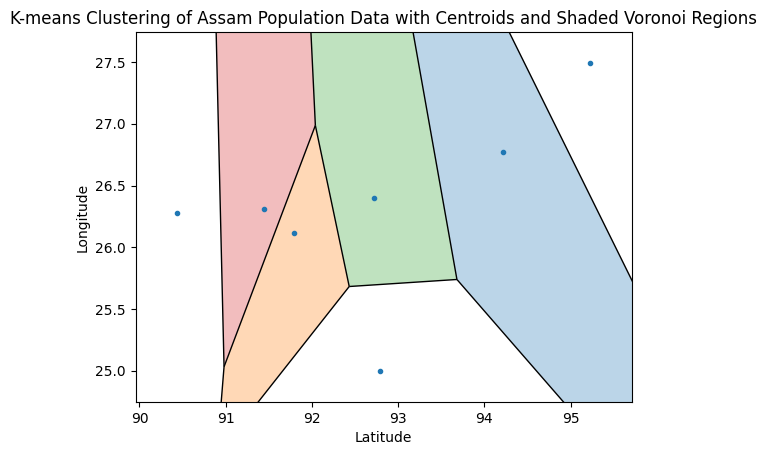

In [210]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

# Select features for clustering
X = assam[['latitude', 'longitude', 'Population']]

# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Based on the elbow curve, choose the optimal number of clusters (k)
optimal_k = 7  # Adjust this based on the elbow curve

# Apply K-means clustering with the optimal value of k
kmeans = KMeans(n_clusters=optimal_k)
clusters = kmeans.fit_predict(X_normalized)

# Get cluster centroids
centroids = kmeans.cluster_centers_
centroids_original_scale = scaler.inverse_transform(centroids)

# Extract 2D coordinates of centroids
centroids_2d = centroids_original_scale[:, [1, 0]]  # Switching latitude and longitude

# Create a Voronoi diagram
vor = Voronoi(centroids_2d)

# Plot the clustering results with Voronoi diagram
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax, show_vertices=False)

# Shade the Voronoi regions
for region in vor.regions:
    if -1 not in region and len(region) > 0:
        polygon = [vor.vertices[i] for i in region]
        plt.fill(*zip(*polygon), alpha=0.3)

plt.xlabel('Latitude')  # Switching x and y labels
plt.ylabel('Longitude')
plt.title('K-means Clustering of Assam Population Data with Centroids and Shaded Voronoi Regions')
plt.show()


In [207]:
centroids_2d 

array([[90.43361868, 26.27367911],
       [95.22726255, 27.49262023],
       [91.7972171 , 26.1161709 ],
       [92.78705142, 24.99856273],
       [92.72335337, 26.39498927],
       [94.21131101, 26.77316475],
       [91.44360307, 26.30777076]])

In [147]:
assam[assam['District']=='Kamrup ']

District             Town  Population   latitude  longitude
195  Kamrup            Rangia       27889  26.540527  91.598840
196  Kamrup            Udiana        4644  26.333333  91.250000
197  Kamrup         Sualkuchi       13898  26.169913  91.570852
198  Kamrup   Bamun Sualkuchi        7628  26.333333  91.250000
199  Kamrup          Niz-Hajo       15188  26.333333  91.250000
200  Kamrup         Majarkuri        4727  26.333333  91.250000
201  Kamrup         Palasbari        4925  26.003712  91.496090
202  Kamrup          Kochpara        7540  26.333333  91.250000
203  Kamrup            Nahira       11790  26.109115  91.480619
204  Kamrup          Uparhali        7095  26.104620  91.508407
205  Kamrup            Dahali        8397  26.333333  91.250000
206  Kamrup           Sarpara        6529  26.333333  91.250000
207  Kamrup       Parlli Part        5788  26.333333  91.250000
208  Kamrup           Sanpara        4534  26.333333  91.250000
209  Kamrup        Changsari         5354  26.261561  91.694030
210  Kamrup             Jalah        6468  26.333333  91.250000

In [148]:
assam_dic= {'Rangia':(26.437252, 91.620110),
            'Udiana':(26.51214 , 91.62537),
            'Sualkuchi':(26.16806, 91.57111),
            'Bamun Sualkuchi':(26.097300,91.521896),
            'Niz-Hajo':(26.247400,91.536750),
            'Majarkuri':(26.240730,91.503210),
            'Palasbari':(26.130787,91.532967),
            'Kochpara':(26.095252,91.513849),
            'Nahira':(26.109115,91.480619),
            'Uparhali':(26.104620,91.508407),
            'Dahali':(26.109123,91.484971),
            'Sarpara':(26.093986,91.517625),
            'Parlli Part': (26.107192,91.543072),
            'Sanpara':(26.048440,91.478857),
            'Changsari':(26.261561,91.694030),
            'Jalah':(26.239855,91.721583)}

In [155]:
lat = []
lon = []
for key in assam_dic.keys():
    lat.append(assam_dic[key][0])
    lon.append(assam_dic[key][1])

In [158]:
col = 'Population'
data = {
    'Latitude': lat,
    'Longitude': lon,
    col: assam[assam['District']=='Kamrup ']['Population']
}
df = pd.DataFrame(data)

# Create a folium map centered around the mean latitude and longitude
center_lat = df['Latitude'].mean()
center_lon = df['Longitude'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# Convert DataFrame to list of lists (latitude, longitude, weight)
heat_data = [[row['Latitude'], row['Longitude'], row[col]] for index, row in df.iterrows()]

# Plot heatmap
HeatMap(heat_data, radius=15, blur=20).add_to(m)
display(m)

In [159]:
df

Latitude  Longitude  Population
195  26.437252  91.620110       27889
196  26.512140  91.625370        4644
197  26.168060  91.571110       13898
198  26.097300  91.521896        7628
199  26.247400  91.536750       15188
200  26.240730  91.503210        4727
201  26.130787  91.532967        4925
202  26.095252  91.513849        7540
203  26.109115  91.480619       11790
204  26.104620  91.508407        7095
205  26.109123  91.484971        8397
206  26.093986  91.517625        6529
207  26.107192  91.543072        5788
208  26.048440  91.478857        4534
209  26.261561  91.694030        5354
210  26.239855  91.721583        6468

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

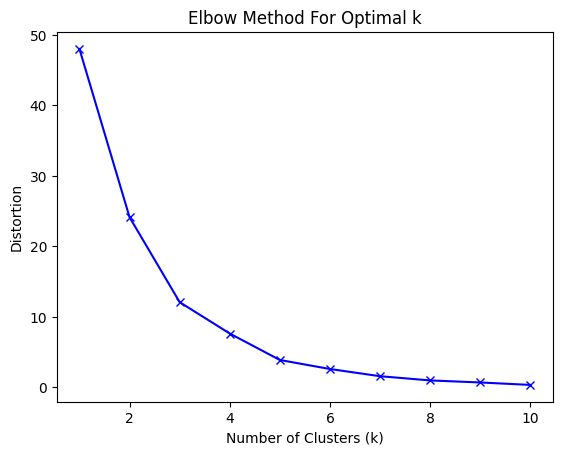

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


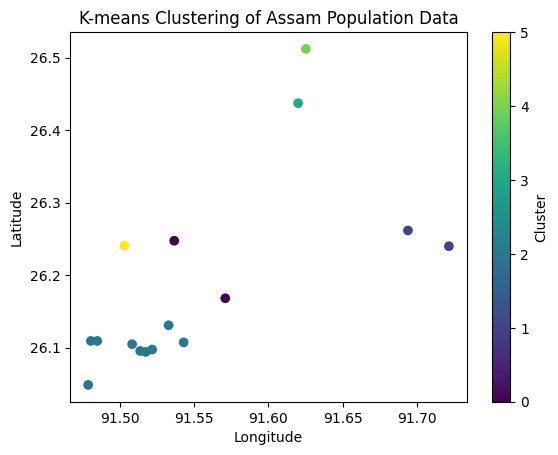

In [160]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select features for clustering
X = df[['Latitude', 'Longitude', 'Population']]

# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Determine the optimal value of k using the elbow method
distortions = []
K = range(1, 11)
for k in K:
    kmeans_model = KMeans(n_clusters=k)
    kmeans_model.fit(X_normalized)
    distortions.append(kmeans_model.inertia_)

# Plot the elbow curve to find the optimal number of clusters
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal k')
plt.show()

# Based on the elbow curve, choose the optimal number of clusters (k)
optimal_k = 6# Adjust this based on the elbow curve

# Apply K-means clustering with the optimal value of k
kmeans = KMeans(n_clusters=optimal_k)
clusters = kmeans.fit_predict(X_normalized)
centroids = kmeans.cluster_centers_

# Visualize the clustering results
plt.scatter(df['Longitude'], df['Latitude'], c=clusters, cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-means Clustering of Assam Population Data')
plt.colorbar(label='Cluster')
plt.show()


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


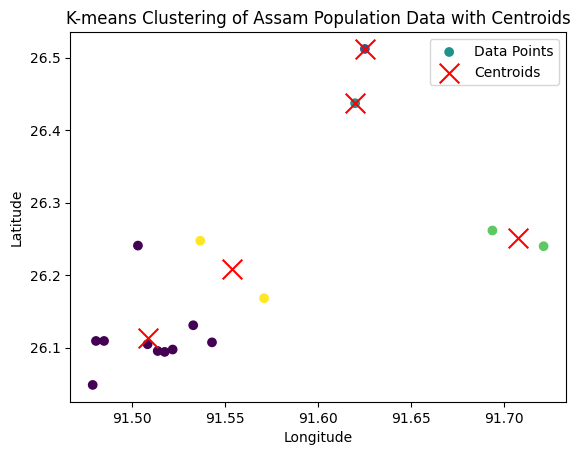

In [202]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select features for clustering
X = df[['Latitude', 'Longitude', 'Population']]

# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Based on the elbow curve, choose the optimal number of clusters (k)
optimal_k = 5  # Adjust this based on the elbow curve

# Apply K-means clustering with the optimal value of k
kmeans = KMeans(n_clusters=optimal_k)
clusters = kmeans.fit_predict(X_normalized)

# Get cluster centroids
centroids = kmeans.cluster_centers_
centroids_original_scale = scaler.inverse_transform(centroids)

# Visualize the clustering results with centroids
plt.scatter(df['Longitude'], df['Latitude'], c=clusters, cmap='viridis', label='Data Points')
plt.scatter(centroids_original_scale[:, 1], centroids_original_scale[:, 0], marker='x', s=200, c='red', label='Centroids')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-means Clustering of Assam Population Data with Centroids')
plt.legend()
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


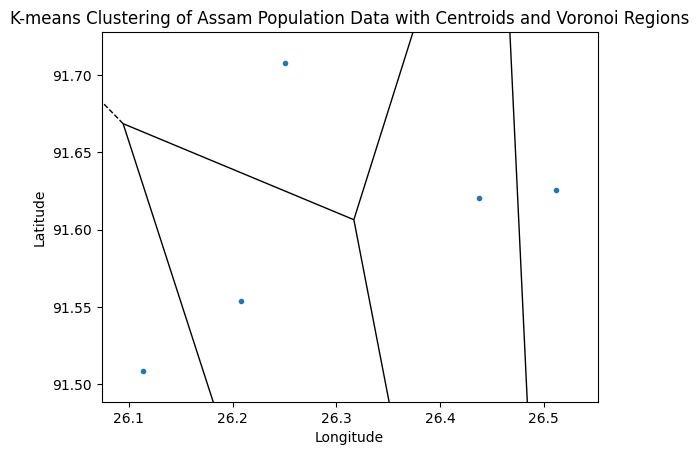

In [201]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

# Select features for clustering
X = df[['Latitude', 'Longitude', 'Population']]

# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Based on the elbow curve, choose the optimal number of clusters (k)
optimal_k = 5  # Adjust this based on the elbow curve

# Apply K-means clustering with the optimal value of k
kmeans = KMeans(n_clusters=optimal_k)
clusters = kmeans.fit_predict(X_normalized)

# Get cluster centroids
centroids = kmeans.cluster_centers_
centroids_original_scale = scaler.inverse_transform(centroids)

# Extract 2D coordinates of centroids
centroids_2d = centroids_original_scale[:, :2]  # Latitude and Longitude only

# Create a Voronoi diagram
vor = Voronoi(centroids_2d)

# Plot the clustering results with Voronoi diagram
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax, show_vertices=False)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-means Clustering of Assam Population Data with Centroids and Voronoi Regions')
# plt.legend()
plt.show()


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


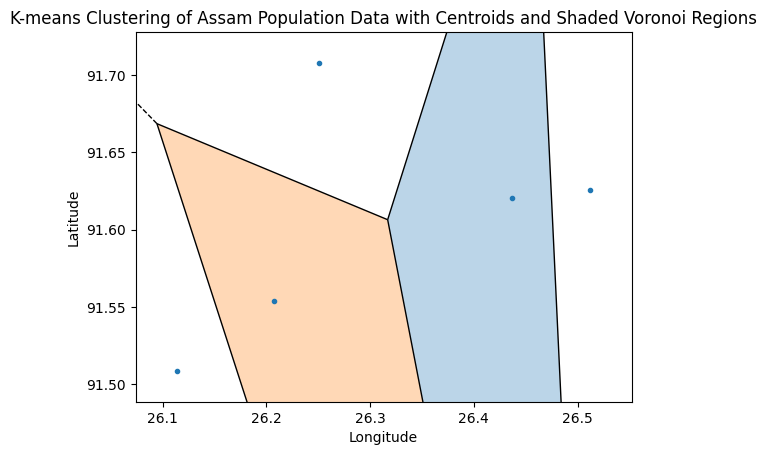

In [200]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

# Select features for clustering
X = df[['Latitude', 'Longitude', 'Population']]

# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Based on the elbow curve, choose the optimal number of clusters (k)
optimal_k = 5  # Adjust this based on the elbow curve

# Apply K-means clustering with the optimal value of k
kmeans = KMeans(n_clusters=optimal_k)
clusters = kmeans.fit_predict(X_normalized)

# Get cluster centroids
centroids = kmeans.cluster_centers_
centroids_original_scale = scaler.inverse_transform(centroids)

# Extract 2D coordinates of centroids
centroids_2d = centroids_original_scale[:, :2]  # Latitude and Longitude only

# Create a Voronoi diagram
vor = Voronoi(centroids_2d)

# Plot the clustering results with Voronoi diagram
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax, show_vertices=False)

# Shade the Voronoi regions
for region in vor.regions:
    if -1 not in region and len(region) > 0:
        polygon = [vor.vertices[i] for i in region]
        plt.fill(*zip(*polygon), alpha=0.3)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-means Clustering of Assam Population Data with Centroids and Shaded Voronoi Regions')
plt.show()
